In [3]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import math
import numpy as np

class DataSet():
    def __init__(self, num_words=None, seed=113, maxlen=100, train_portion=0.5, long_first=False):
        """
        :param num_words: Size of vocabulary, all words out-of-vocabulary will be marked as [unk]
        :param seed: Seed for randomly shuffling dataset
        :param maxlen: Maximum length of review, reviews longer than maxlen will be truncated, reviews shorter than
        maxlen will be padded to maxlen
        :param train_portion: Portion of dataset to allocate to training data, test data will be 1-train_portion
        :param long_first: Sort reviews by length
        """
        # retrieve IMDb data, x is a sequence containing movie review,
        # y is a label indicating if it is positive or negative sentiment
        (self.x_train, self.y_train), (self.x_test, self.y_test) = imdb.load_data(num_words=num_words, seed=seed)

        if long_first:
            self.y_train = [y for _, y in sorted(zip(self.x_train, self.y_train), key=lambda s: len(s[0]), reverse=True)]
            self.x_train = sorted(self.x_train, key=len, reverse=True)

            self.y_test = [y for _, y in sorted(zip(self.x_test, self.y_test), key=lambda s: len(s[0]), reverse=True)]
            self.x_test = sorted(self.x_test, key=len, reverse=True)

        self.total_length = [len(x) for x in self.x_train]
        temp = [len(x) for x in self.x_test]
        self.total_length.extend(temp)

        # padding sequences to all be of the same length
        self.x_train = pad_sequences(self.x_train, maxlen=maxlen, padding='post', truncating='post')
        self.x_test = pad_sequences(self.x_test, maxlen=maxlen, padding='post', truncating='post')

        self.split_data(train_portion)

        self.word_index = imdb.get_word_index()
        self.word_to_index = {word:id + 3 for word, id in self.word_index.items()}
        self.word_to_index["[pad]"] = 0
        self.word_to_index["[start]"] = 1
        self.word_to_index["[unk]"] = 2
        self.word_to_index["[unused]"] = 3
        self.index_to_word = {i:word for (word, i) in self.word_to_index.items()}
        self.form_vocab()

    def form_vocab(self):
        i2w_vocab = {}
        w2i_vocab = {}

        for sentence in self.x_train:
            for id in sentence:
                if id not in i2w_vocab:
                    word = self.index_to_word[id]
                    i2w_vocab[id] = word
                    w2i_vocab[word] = id

        for sentence in self.x_test:
            for id in sentence:
                if id not in i2w_vocab:
                    word = self.index_to_word[id]
                    i2w_vocab[id] = word
                    w2i_vocab[word] = id
        self.i2w_vocab = i2w_vocab
        self.w2i_vocab = w2i_vocab

    def get_data(self):
        return (self.x_train, self.y_train), (self.x_test, self.y_test), (self.train_length, self.test_length)

    def get_vocab_length(self):
        return len(self.i2w_vocab)

    # splits data into ratio train:test -> (train_portion:1-train_portion)
    def split_data(self, train_portion):
        x = np.concatenate((self.x_train, self.x_test), axis=0)
        y = np.concatenate((self.y_train, self.y_test), axis=0)
        self.train_length, self.test_length = self.total_length[:math.floor(train_portion * len(x))], \
                                              self.total_length[math.floor(train_portion * len(x)):]
        self.x_train, self.x_test = x[:math.floor(train_portion * len(x))], \
                                    x[math.floor(train_portion * len(x)):]
        self.y_train, self.y_test = y[:math.floor(train_portion * len(y))], \
                                    y[math.floor(train_portion * len(y)):]
        return None


In [ ]:
    
import numpy
import random
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, Model
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
import multiprocessing
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import models, Model
import numpy as np
from numba import guvectorize,cuda,jit

def get_mean_vector(h_set):
    """
    :param h_set: list of vectors h, each vector is output of LSTM layer at a timestep
    :return: mean vector hbar
    """
    hbar = h_set[0]
    for i in range(1, len(h_set)):
        hbar += h_set[i]
    hbar = hbar / len(h_set)
    return hbar

def get_magnitude(vector):
    """
    :param vector: 1D numpy array
    :return: magnitude of vector
    """
    magnitude = 0
    for element in vector:
        magnitude += element ** 2
    return math.sqrt(magnitude)

def get_norm(vector):
    return vector / get_magnitude(vector)

def project(vector, basis):
    """
    :param vector: vector to project onto basis
    :param basis: basis for poincare map
    :return: vector projected onto basis (dot product)
    """
    return vector.dot(basis)


def get_poincare_mapping(lstm, start, num_steps, intermediate_inputs=None):
    if intermediate_inputs is None:
        intermediate_inputs = [np.zeros(len(start), dtype=np.float64) for _ in range(num_steps - 1)]


    h_t = [lstm.step(start)[-1]]
    h_t_1 = [] # h_{t+1}
    for i in range(num_steps - 1):
        curr_h = lstm.step(intermediate_inputs[i])[-1]
        h_t.append(curr_h)
        h_t_1.append(curr_h)
    h_t.pop() # remove last element so h_t and h_{t+1} aligns
    return h_t, h_t_1



def main(n):       
    # numbers setup
    class LSTM_layer():
        @staticmethod
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        @staticmethod
        def tanh(x): # for consistency
            return np.tanh(x)

        def __init__(self, weights):
            """
            :param weights: weights of LSTM layer
            """
            # transposing matrices for dot product
            self.W, self.U, self.b = np.transpose(weights[0]), np.transpose(weights[1]), np.transpose(weights[2])
            self.num_units = int(self.U.shape[1])
            self.split_weights()
            # LSTM trained stateless, initial C and h are zero vectors
            self.C = np.zeros((self.num_units), dtype=np.float64)
            self.h = np.zeros((self.num_units), dtype=np.float64)

        def split_weights(self):
            # weights are stored as (neuron_num, (i, f, c, o))
            self.W_i = np.ascontiguousarray(self.W[:self.num_units, :])
            self.W_f = np.ascontiguousarray(self.W[self.num_units:self.num_units * 2, :])
            self.W_c = np.ascontiguousarray(self.W[self.num_units * 2:self.num_units * 3, :])
            self.W_o = np.ascontiguousarray(self.W[self.num_units * 3:, :])

            self.U_i = np.ascontiguousarray(self.U[:self.num_units, :])
            self.U_f = np.ascontiguousarray(self.U[self.num_units:self.num_units * 2, :])
            self.U_c = np.ascontiguousarray(self.U[self.num_units * 2:self.num_units * 3, :])
            self.U_o = np.ascontiguousarray(self.U[self.num_units * 3:, :])

            self.b_i = np.ascontiguousarray(self.b[:self.num_units])
            self.b_f = np.ascontiguousarray(self.b[self.num_units:self.num_units * 2])
            self.b_c = np.ascontiguousarray(self.b[self.num_units * 2:self.num_units * 3])
            self.b_o = np.ascontiguousarray(self.b[self.num_units * 3:])

        def step(self, x_t):
            """
            Performs a timestep (propagating new input through layer)
            :return: array of activations [ft, it, cc, cc_update, c_out, ot, ht]
            """
            activations = []
            # forget step
            ft = self.get_ft(x_t)
            activations.append(ft)
            self.forget(ft)

            # "remembering" step
            it = self.get_it(x_t)
            activations.append(it)
            cc = self.get_CC(x_t)
            activations.append(cc)
            cc_update = self.get_CC_update(it, cc)
            activations.append(cc_update)
            self.remember(cc_update)

            # output step
            c_out = self.get_C_output()
            activations.append(c_out)
            ot = self.get_ot(x_t)
            activations.append(ot)
            output = self.output(c_out, ot)
            activations.append(output)

            return activations

        def reset(self):
            # call when done with one input (with all timesteps completed)
            # resets internal cell state and starting hidden state
            self.C = np.zeros((self.num_units), dtype=np.float64)
            self.h = np.zeros((self.num_units), dtype=np.float64)


        # vectorized activation propagation
        @staticmethod
        @guvectorize(
            ["float64[:, :], float64[:, :], float64[:], float64[:], float64[:], float64[:]"],
            "(n, m),(n, n),(m),(n),(n)->(n)" 
        )
        def get_ft_vec(W_f, U_f, x_t, h, b_f, res):
            wfx = W_f.dot(x_t)
            ufh = U_f.dot(h)
            sum_int = wfx + ufh
            sum_f = sum_int + b_f
            res[:] = 1 / (1 + np.exp(-sum_f))
        @staticmethod
        @guvectorize(
            ["float64[:, :], float64[:, :], float64[:], float64[:], float64[:], float64[:]"],
            "(n, m),(n, n),(m),(n),(n)->(n)"
    
        )
        def get_it_vec(W_i, U_i, x_t, h, b_i, res):
            wix = W_i.dot(x_t)
            uih = U_i.dot(h)
            sum_int = wix + uih
            sum_f = sum_int + b_i
            res[:] = 1 / (1 + np.exp(-sum_f))

        @staticmethod
        @guvectorize(
            ["float64[:, :], float64[:, :], float64[:], float64[:], float64[:], float64[:]"],
            "(n, m),(n, n),(m),(n),(n)->(n)"
     
        )
        def get_CC_vec(W_c, U_c, x_t, h, b_c, res):
            wcx = W_c.dot(x_t)
            uch = U_c.dot(h)
            sum_int = wcx + uch
            sum_f = sum_int + b_c
            res[:] = np.tanh(sum_f)

        @staticmethod
        @guvectorize(
            ["float64[:, :], float64[:, :], float64[:], float64[:], float64[:], float64[:]"],
            "(n, m),(n, n),(m),(n),(n)->(n)"
   
        )
        def get_ot_vec(W_o, U_o, x_t, h, b_o, res):
            wox = W_o.dot(x_t)
            uoh = U_o.dot(h)
            sum_int = wox + uoh
            sum_f = sum_int + b_o
            res[:] = 1 / (1 + np.exp(-sum_f))

        # activations start
        # tanh activations don't see an improvement from vectorization (probably because tanh is already vectorized)
        def get_ft(self, x_t):
            # sigmoid(W_f . x_t + U_f . h_(t-1) + b_f) . is dot product
            # wfx = self.W_f.dot(x_t)
            # ufh = self.U_f.dot(self.h)
            # return LSTM_layer.sigmoid(wfx + ufh + self.b_f)
            return LSTM_layer.get_ft_vec(self.W_f, self.U_f, x_t, self.h, self.b_f)

        def get_it(self, x_t):
            # sigmoid(W_i . x_t + U_i . h_(t-1) + b_i)
            # wix = self.W_i.dot(x_t)
            # uih = self.U_i.dot(self.h)
            # return LSTM_layer.sigmoid(wix + uih + self.b_i)
            return LSTM_layer.get_it_vec(self.W_i, self.U_i, x_t, self.h, self.b_i)

        def get_CC(self, x_t):
            # candidate cell state before proportion
            # tanh(W_c . x_t + U_c . h_(t-1) + b_c)
            wcx = self.W_c.dot(x_t)
            uch = self.U_c.dot(self.h)
            return LSTM_layer.tanh(wcx + uch + self.b_c)
            # return LSTM_layer.get_CC_vec(self.W_c, self.U_c, x_t, self.h, self.b_c)

        def get_ot(self, x_t):
            # sigmoid(W_o . x_t + U_o . h_(t-1) + b_o)
            # wox = self.W_o.dot(x_t)
            # uoh = self.U_o.dot(self.h)
            # return LSTM_layer.sigmoid(wox + uoh + self.b_o)
            return LSTM_layer.get_ot_vec(self.W_o, self.U_o, x_t, self.h, self.b_o)

        def get_C_output(self):
            # cell state output before proportion
            # tanh(C_t)
            return LSTM_layer.tanh(self.C)

        def get_CC_update(self, it, cc):
            # candidate cell state after proportion, for updating cell state
            # it * cc, * is Hadamard product
            return it * cc
        # activations end


        # state updates start
        def forget(self, ft):
            # update old cell state in the forget step
            self.C = self.C * ft

        def remember(self, cc_update):
            # update old cell state with new information
            self.C = self.C + cc_update

        def output(self, c_output, ot):
            # proportionate the cell output vector for new output and hidden state
            self.h = c_output * ot
            return self.h


    
    # state updates end
    num_timesteps = 500
    len_sequence = 800
    num_cells = 60
    av=[]
    with open('paper2weights/dataset_4000_70.pkl', 'rb') as f:
        dataset = pickle.load(f)
  
    #i=950
    _, x, length = dataset.get_data()
    _, length = length
    x, y = x

    if n<10:
        filepath='paper2weights/weights.0'+str(n)+'.hdf5'
    else:
        filepath='paper2weights/weights.'+str(n)+'.hdf5'
    model= models.load_model(filepath,compile=False)
    embed_layer = Model(inputs=model.input, outputs=model.layers[1-1].output)
    lm=[]
    for i in range(118,1181,20):
        #x_in=np.zeros((1,500),int).tolist()
        # print(length[i])
        # if length[i] < 350:
        #     continue
        #x_in_gau = x[i].reshape((1, num_timesteps))+ random.gauss(0,1e-15)
        #x_in_gau = x_in + random.gauss(0,0.0001)
        #print(x_in[0])
        #print(x_in_gau)
        x_in = x[i].reshape((1,num_timesteps))
        #x_in=np.zeros((1,500),int).tolist()
        # print(length[i])
        # if length[i] < 350:
        #     continue
        #x_in_gau = x[i].reshape((1, num_timesteps))+ random.gauss(0,1e-15)
        #x_in_gau = x_in + random.gauss(0,0.0001)
        #print(x_in[0])
        #print(x_in_gau)
        lstm_in = embed_layer.predict(x_in)[0]
        lstm_in=np.float64(lstm_in)
        lstm_in_gau=embed_layer.predict(x_in)[0]
        a=model.layers[1].get_weights()
        for e in range(len(a)):
                a[e]=np.float64(a[e])
        c=model.layers[1].get_weights()
        for e in range(len(c)):
                c[e]=np.float64(c[e])
        lstm = LSTM_layer(a)
        lstm_gau = LSTM_layer(c)
        start = lstm_in[1-1]
        random.seed(42)
        start_gau=lstm_in_gau[1-1]+random.gauss(0,0.5)
                #print(np.array(start).shape)
                    #inte rmediate_steps = np.zeros((75000,32))
        xt=np.zeros((75000,32))
        intermediate_steps = lstm_in[1:].tolist()+xt.tolist()
        intermediate_steps_gau= lstm_in[1:].tolist()+xt.tolist()
                #print(intermediate_steps)
        h_t_late, h_t_1_late = get_poincare_mapping(lstm, start,len_sequence,intermediate_steps)
        h_t_late.append(h_t_1_late[-1])
        hbar_late = get_mean_vector(h_t_late)
        h_t_late_gau, h_t_1_late_gau = get_poincare_mapping(lstm_gau, start_gau,len_sequence,intermediate_steps)
                #print(h_t_late_gau[
        h_t_late_gau.append(h_t_1_late_gau[-1])
        late_set=[]
                    #print(len(h_t_late_gau))
                #print(len(h_t_late))
        for j in range(len(h_t_late)-3, len(h_t_late)):

                        vec1=np.array(h_t_late[j])

                        vec2=np.array(h_t_late_gau[j])
                        dist = numpy.linalg.norm(vec1 - vec2)

                        dist_late=numpy.log(dist+numpy.exp(-25))

                        late_set.append(dist_late)

        lm.append(np.mean(late_set))
        print(np.mean(late_set))
    return lm
            
    
if __name__ == "__main__":
    #pool=multiprocessing.Pool(processes=8)
    #for i in range(233,420):
        #pool.apply_async(main, (i, ))
        x=[]
        for i in range(1,1101):
            x.append(main(i))
        with open('lstm4.pkl','wb') as f:
            pickle.dump(x,f)

1/1 [==============================] - 0s 23ms/step


2023-10-24 05:49:53.970227: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-24 05:49:53.972115: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-24 05:49:53.973915: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99999905940702
1/1 [==============================] - 0s 22ms/step
-24.99999900440547
1/1 [==============================] - 0s 23ms/step
-24.999999438528317
1/1 [==============================] - 0s 22ms/step
-24.999999116355383
1/1 [==============================] - 0s 22ms/step
-24.999999169596254
1/1 [==============================] - 0s 22ms/step
-24.99999938833196
1/1 [==============================] - 0s 23ms/step
-24.99999967925605
1/1 [==============================] - 0s 22ms/step
-24.99999927417898
1/1 [==============================] - 0s 23ms/step
-24.999999123134526
1/1 [==============================] - 0s 22ms/step
-24.999999286665787
1/1 [==============================] - 0s 24ms/step
-24.999999181298424
1/1 [==============================] - 0s 22ms/step
-24.99999967367096
1/1 [==============================] - 0s 22ms/step
-24.999999458589617
1/1 [==============================] - 0s 22ms/step
-24.999999248930077
1/1 [==============================] - 0s 22ms/ste

2023-10-24 05:50:47.999944: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-24 05:50:48.002116: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-24 05:50:48.003720: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99999860258961
1/1 [==============================] - 0s 22ms/step
-24.99999922434488
1/1 [==============================] - 0s 22ms/step
-24.999998507953308
1/1 [==============================] - 0s 23ms/step
-24.999998756956774
1/1 [==============================] - 0s 22ms/step
-24.999998636177665
1/1 [==============================] - 0s 23ms/step
-24.99999937850707
1/1 [==============================] - 0s 23ms/step
-24.999999375820096
1/1 [==============================] - 0s 22ms/step
-24.999999306856107
1/1 [==============================] - 0s 22ms/step
-24.999999017964566
1/1 [==============================] - 0s 22ms/step
-24.9999986276802
1/1 [==============================] - 0s 22ms/step
-24.99999874701088
1/1 [==============================] - 0s 22ms/step
-24.999998657124852
1/1 [==============================] - 0s 22ms/step
-24.99999872040334
1/1 [==============================] - 0s 22ms/step
-24.999998840018307
1/1 [==============================] - 0s 22ms/step

2023-10-24 05:51:41.457442: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-24 05:51:41.459725: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-24 05:51:41.461347: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 23ms/step
-24.99999946585098
1/1 [==============================] - 0s 22ms/step
-24.999999189674565
1/1 [==============================] - 0s 23ms/step
-24.999999360193105
1/1 [==============================] - 0s 23ms/step
-24.999999448335313
1/1 [==============================] - 0s 23ms/step
-24.999999447384237
1/1 [==============================] - 0s 23ms/step
-24.99999917845689
1/1 [==============================] - 0s 23ms/step
-24.999999345894523
1/1 [==============================] - 0s 22ms/step
-24.999999311417213
1/1 [==============================] - 0s 23ms/step
-24.999999217146723
1/1 [==============================] - 0s 22ms/step
-24.999999307654907
1/1 [==============================] - 0s 22ms/step
-24.999999271847983
1/1 [==============================] - 0s 22ms/step
-24.999999124567577
1/1 [==============================] - 0s 22ms/step
-24.99999929504548
1/1 [==============================] - 0s 23ms/step
-24.99999918236

2023-10-24 05:52:38.050761: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-24 05:52:38.052967: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-24 05:52:38.054548: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999999558689286
1/1 [==============================] - 0s 23ms/step
-24.999999613417287
1/1 [==============================] - 0s 22ms/step
-24.999999943441438
1/1 [==============================] - 0s 24ms/step
-24.999999460293107
1/1 [==============================] - 0s 23ms/step
-24.999999498061843
1/1 [==============================] - 0s 23ms/step
-24.999999712968147
1/1 [==============================] - 0s 22ms/step
-24.99999958568836
1/1 [==============================] - 0s 22ms/step
-24.999999728753192
1/1 [==============================] - 0s 23ms/step
-24.99999972999383
1/1 [==============================] - 0s 22ms/step
-24.99999968342341
1/1 [==============================] - 0s 22ms/step
-24.99999913098918
1/1 [==============================] - 0s 23ms/step
-24.999999002621887
1/1 [==============================] - 0s 23ms/step
-24.99999943834865
1/1 [==============================] - 0s 23ms/step
-24.999999608143856
1/1 [==============================] - 0s 24ms/st

2023-10-24 05:53:31.177109: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-24 05:53:31.179365: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-24 05:53:31.180959: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999992513779407
1/1 [==============================] - 0s 23ms/step
-24.999985066220063
1/1 [==============================] - 0s 22ms/step
-24.999990041465548
1/1 [==============================] - 0s 22ms/step
-24.99999170224628
1/1 [==============================] - 0s 22ms/step
-24.999989381931766
1/1 [==============================] - 0s 22ms/step
-24.99998940313164
1/1 [==============================] - 0s 23ms/step
-24.9999917527947
1/1 [==============================] - 0s 22ms/step
-24.99999444053073
1/1 [==============================] - 0s 23ms/step
-24.999992810454113
1/1 [==============================] - 0s 22ms/step
-24.999995893074612
1/1 [==============================] - 0s 22ms/step
-24.999988756114423
1/1 [==============================] - 0s 22ms/step
-24.99999214392335
1/1 [==============================] - 0s 22ms/step
-24.999986714024285
1/1 [==============================] - 0s 22ms/step
-24.999987457161698
1/1 [==============================] - 0s 22ms/ste

2023-10-24 05:54:24.414513: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-24 05:54:24.416503: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-24 05:54:24.418422: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 23ms/step
-24.99998955306876
1/1 [==============================] - 0s 22ms/step
-24.99998813290631
1/1 [==============================] - 0s 22ms/step
-24.999983608499935
1/1 [==============================] - 0s 22ms/step
-24.99998791755579
1/1 [==============================] - 0s 23ms/step
-24.999981036093278
1/1 [==============================] - 0s 22ms/step
-24.999976858395172
1/1 [==============================] - 0s 23ms/step
-24.99998537066391
1/1 [==============================] - 0s 26ms/step
-24.99998202198596
1/1 [==============================] - 0s 23ms/step
-24.99998750878638
1/1 [==============================] - 0s 23ms/step
-24.9999780303969
1/1 [==============================] - 0s 24ms/step
-24.999990563366726
1/1 [==============================] - 0s 23ms/step
-24.915349794256795
1/1 [==============================] - 0s 22ms/step
-24.999989342777038
1/1 [==============================] - 0s 22ms/step
-24.999991827730152


2023-10-24 05:55:18.009818: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-24 05:55:18.012084: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-24 05:55:18.013736: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-25.0
1/1 [==============================] - 0s 23ms/step
-24.999986043927226
1/1 [==============================] - 0s 24ms/step
-24.9999899958097
1/1 [==============================] - 0s 24ms/step
-24.99998806577034
1/1 [==============================] - 0s 23ms/step
-24.99999053303129
1/1 [==============================] - 0s 23ms/step
-24.999983589340488
1/1 [==============================] - 0s 23ms/step
-24.999987178928976
1/1 [==============================] - 0s 23ms/step
-24.999985595804464
1/1 [==============================] - 0s 23ms/step
-24.99998807114927
1/1 [==============================] - 0s 23ms/step
-24.998829251529
1/1 [==============================] - 0s 23ms/step
-24.99999007813057
1/1 [==============================] - 0s 23ms/step
-24.998771503683354
1/1 [==============================] - 0s 22ms/step
-24.99998640299866
1/1 [==============================] - 0s 23ms/step
-24.999990401836055
1/1 [==============================] - 0s 22ms/step
-24.999990849986

2023-10-24 05:56:11.383605: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-24 05:56:11.385503: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-24 05:56:11.387384: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999991505173174
1/1 [==============================] - 0s 23ms/step
-24.999990989511264
1/1 [==============================] - 0s 23ms/step
-24.99998860553653
1/1 [==============================] - 0s 23ms/step
-24.9999923568641
1/1 [==============================] - 0s 23ms/step
-24.999989063719354
1/1 [==============================] - 0s 22ms/step
-24.99998252027753
1/1 [==============================] - 0s 22ms/step
-24.999987800768718
1/1 [==============================] - 0s 22ms/step
-24.999992714619093
1/1 [==============================] - 0s 22ms/step
-24.999992409849956
1/1 [==============================] - 0s 22ms/step
-24.90575932517814
1/1 [==============================] - 0s 23ms/step
-24.999986389759517
1/1 [==============================] - 0s 22ms/step
-23.86405927528304
1/1 [==============================] - 0s 23ms/step
-24.999988986639465
1/1 [==============================] - 0s 22ms/step
-24.99998411438749
1/1 [==============================] - 0s 22ms/step

2023-10-24 05:57:08.629012: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-24 05:57:08.631209: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-24 05:57:08.632818: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99999854344306
1/1 [==============================] - 0s 22ms/step
-24.99999819948818
1/1 [==============================] - 0s 22ms/step
-24.99999848000048
1/1 [==============================] - 0s 22ms/step
-24.999997690119205
1/1 [==============================] - 0s 22ms/step
-24.999998539349715
1/1 [==============================] - 0s 24ms/step
-24.999998413185192
1/1 [==============================] - 0s 22ms/step
-24.999998589283962
1/1 [==============================] - 0s 24ms/step
-24.999998959749433
1/1 [==============================] - 0s 22ms/step
-24.999998890097356
1/1 [==============================] - 0s 22ms/step
-24.999998089351223
1/1 [==============================] - 0s 22ms/step
-24.99999828227457
1/1 [==============================] - 0s 24ms/step
-24.99999839538337
1/1 [==============================] - 0s 23ms/step
-24.9999985398823
1/1 [==============================] - 0s 23ms/step
-24.999998761344745
1/1 [==============================] - 0s 22ms/step

2023-10-24 05:58:02.057059: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-24 05:58:02.059364: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-24 05:58:02.060990: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 23ms/step
-24.999998231443925
1/1 [==============================] - 0s 23ms/step
-24.999998603015097
1/1 [==============================] - 0s 22ms/step
-24.999998578547444
1/1 [==============================] - 0s 23ms/step
-24.99999879175166
1/1 [==============================] - 0s 23ms/step
-24.99999844758948
1/1 [==============================] - 0s 22ms/step
-24.99999805257781
1/1 [==============================] - 0s 23ms/step
-24.999998902220824
1/1 [==============================] - 0s 22ms/step
-24.999999206448393
1/1 [==============================] - 0s 23ms/step
-24.99999858728067
1/1 [==============================] - 0s 24ms/step
-24.999999224186492
1/1 [==============================] - 0s 22ms/step
-24.99999811965722
1/1 [==============================] - 0s 23ms/step
-24.999998311496437
1/1 [==============================] - 0s 22ms/step
-24.999998768314654
1/1 [==============================] - 0s 22ms/step
-24.9999982733818

2023-10-24 05:58:55.241860: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-24 05:58:55.244110: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-24 05:58:55.245709: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99999874484402
1/1 [==============================] - 0s 22ms/step
-24.999999386767072
1/1 [==============================] - 0s 22ms/step
-24.99999911410329
1/1 [==============================] - 0s 22ms/step
-24.999999225147963
1/1 [==============================] - 0s 22ms/step
-24.99999910300355
1/1 [==============================] - 0s 22ms/step
-24.999998921945217
1/1 [==============================] - 0s 23ms/step
-24.999999291018394
1/1 [==============================] - 0s 23ms/step
-24.999998561942917
1/1 [==============================] - 0s 23ms/step
-24.999999236561838
1/1 [==============================] - 0s 23ms/step
-24.999997968031693
1/1 [==============================] - 0s 24ms/step
-24.999998966938467
1/1 [==============================] - 0s 23ms/step
-24.99999882756263
1/1 [==============================] - 0s 23ms/step
-24.999998744349032
1/1 [==============================] - 0s 22ms/step
-24.99999914923502
1/1 [==============================] - 0s 24ms/st

2023-10-24 05:59:48.321004: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-24 05:59:48.322860: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-24 05:59:48.324705: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99998500024046
1/1 [==============================] - 0s 22ms/step
-24.999975661394036
1/1 [==============================] - 0s 22ms/step
-24.999987084021296
1/1 [==============================] - 0s 22ms/step
-24.99998832997821
1/1 [==============================] - 0s 22ms/step
-24.999980423420997
1/1 [==============================] - 0s 23ms/step
-24.999982127347778
1/1 [==============================] - 0s 22ms/step
-24.999984815739353
1/1 [==============================] - 0s 22ms/step
-24.99998454515766
1/1 [==============================] - 0s 22ms/step
-24.999984453387885
1/1 [==============================] - 0s 22ms/step
-24.999981261890625
1/1 [==============================] - 0s 23ms/step
-24.999981133947568
1/1 [==============================] - 0s 23ms/step
-24.99999017527998
1/1 [==============================] - 0s 23ms/step
-24.999988146090086
1/1 [==============================] - 0s 22ms/step
-24.999977006451886
1/1 [==============================] - 0s 22ms/s

2023-10-24 06:00:41.446534: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-24 06:00:41.448938: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-24 06:00:41.451060: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999988362095618
1/1 [==============================] - 0s 23ms/step
-24.99997474217811
1/1 [==============================] - 0s 23ms/step
-24.99997523672207
1/1 [==============================] - 0s 23ms/step
-24.999983186382124
1/1 [==============================] - 0s 24ms/step
-24.99997742610208
1/1 [==============================] - 0s 22ms/step
-24.999984148363747
1/1 [==============================] - 0s 23ms/step
-24.999976786049263
1/1 [==============================] - 0s 22ms/step
-24.999976686414325
1/1 [==============================] - 0s 23ms/step
-24.999977877282827
1/1 [==============================] - 0s 22ms/step
-24.999984569883257
1/1 [==============================] - 0s 22ms/step
-24.99997638946324
1/1 [==============================] - 0s 23ms/step
-24.999982825358554
1/1 [==============================] - 0s 23ms/step
-24.999971684895275
1/1 [==============================] - 0s 22ms/step
-24.999988971730748
1/1 [==============================] - 0s 23ms/s

2023-10-24 06:01:38.574126: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-24 06:01:38.576002: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-24 06:01:38.577843: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999985118662
1/1 [==============================] - 0s 22ms/step
-24.999982985722067
1/1 [==============================] - 0s 22ms/step
-24.99998155939129
1/1 [==============================] - 0s 23ms/step
-24.99998659710774
1/1 [==============================] - 0s 22ms/step
-24.999986541835508
1/1 [==============================] - 0s 23ms/step
-24.999984317966536
1/1 [==============================] - 0s 22ms/step
-24.99998623314332
1/1 [==============================] - 0s 24ms/step
-24.999990460883748
1/1 [==============================] - 0s 22ms/step
-24.999979126843233
1/1 [==============================] - 0s 22ms/step
-24.999986935443104
1/1 [==============================] - 0s 22ms/step
-24.999985652302215
1/1 [==============================] - 0s 23ms/step
-24.9999870965482
1/1 [==============================] - 0s 22ms/step
-24.999982532947623
1/1 [==============================] - 0s 24ms/step
-24.999985555302658
1/1 [==============================] - 0s 22ms/step


2023-10-24 06:02:32.046384: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-24 06:02:32.048585: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-24 06:02:32.050210: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 23ms/step
-24.999984458935987
1/1 [==============================] - 0s 22ms/step
-24.99998142756768
1/1 [==============================] - 0s 23ms/step
-24.999985634520527
1/1 [==============================] - 0s 22ms/step
-24.99998802873888
1/1 [==============================] - 0s 22ms/step
-24.99998658162974
1/1 [==============================] - 0s 22ms/step
-24.9999904937594
1/1 [==============================] - 0s 34ms/step
-24.99998781284879
1/1 [==============================] - 0s 22ms/step
-24.999984447536736
1/1 [==============================] - 0s 23ms/step
-24.999988380508515
1/1 [==============================] - 0s 23ms/step
-24.999983371465294
1/1 [==============================] - 0s 23ms/step
-24.99998988413328
1/1 [==============================] - 0s 23ms/step
-24.999982788735206
1/1 [==============================] - 0s 22ms/step
-24.99998827161518
1/1 [==============================] - 0s 22ms/step
-24.99998550629429
1

In [ ]:
import math
import numpy
import random
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, Model
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
import multiprocessing
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import models, Model
import numpy as np


from numba import guvectorize
def get_mean_vector(h_set):
    """
    :param h_set: list of vectors h, each vector is output of LSTM layer at a timestep
    :return: mean vector hbar
    """
    hbar = h_set[0]
    for i in range(1, len(h_set)):
        hbar += h_set[i]
    hbar = hbar / len(h_set)
    return hbar

def get_magnitude(vector):
    """
    :param vector: 1D numpy array
    :return: magnitude of vector
    """
    magnitude = 0
    for element in vector:
        magnitude += element ** 2
    return math.sqrt(magnitude)

def get_norm(vector):
    """
    :param vector: vector to normalise
    :return: norm of vector
    """
    return vector / get_magnitude(vector)

def project(vector, basis):
    """
    :param vector: vector to project onto basis
    :param basis: basis for poincare map
    :return: vector projected onto basis (dot product)
    """
    return vector.dot(basis)

def get_poincare_mapping(lstm, start, num_steps, intermediate_inputs=None):
    """
    get poincare mapping (projections at h_t, projections at h_{t+1})
    :param lstm: trained LSTM_layer
    :param start: starting input
    :param num_steps: number of iterations to perform, length of intermediate_inputs has to be num_steps - 1
    :param intermediate_inputs: list of x_t to input at each timestep, zero vectors if None, each vector has to be length start
    :return: poincare mapping
    """
    if intermediate_inputs is None:
        intermediate_inputs = [np.zeros(len(start), dtype=np.float64) for _ in range(num_steps - 1)]

    # get h_t at each timestep
    h_t = [lstm.step(start)[-1]]
    h_t_1 = [] # h_{t+1}
    for i in range(num_steps - 1):
        curr_h = lstm.step(intermediate_inputs[i])[-1]
        h_t.append(curr_h)
        h_t_1.append(curr_h)

    h_t.pop() # remove last element so h_t and h_{t+1} aligns
    return h_t, h_t_1

def main(n):       
    # numbers setup
    class LSTM_layer():
        @staticmethod
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        @staticmethod
        def tanh(x): # for consistency
            return np.tanh(x)
        

        def __init__(self, weights):
            """
            :param weights: weights of LSTM layer
            """
            # transposing matrices for dot product
            self.W, self.U, self.b = np.transpose(weights[0]), np.transpose(weights[1]), np.transpose(weights[2])
            self.num_units = int(self.U.shape[1])
            self.split_weights()
            # LSTM trained stateless, initial C and h are zero vectors
            self.C = np.zeros((self.num_units), dtype=np.float64)
            self.h = np.zeros((self.num_units), dtype=np.float64)

        def split_weights(self):
            # weights are stored as (neuron_num, (i, f, c, o))
            self.W_i = np.ascontiguousarray(self.W[:self.num_units, :])
            self.W_f = np.ascontiguousarray(self.W[self.num_units:self.num_units * 2, :])
            self.W_c = np.ascontiguousarray(self.W[self.num_units * 2:self.num_units * 3, :])
            self.W_o = np.ascontiguousarray(self.W[self.num_units * 3:, :])

            self.U_i = np.ascontiguousarray(self.U[:self.num_units, :])
            self.U_f = np.ascontiguousarray(self.U[self.num_units:self.num_units * 2, :])
            self.U_c = np.ascontiguousarray(self.U[self.num_units * 2:self.num_units * 3, :])
            self.U_o = np.ascontiguousarray(self.U[self.num_units * 3:, :])

            self.b_i = np.ascontiguousarray(self.b[:self.num_units])
            self.b_f = np.ascontiguousarray(self.b[self.num_units:self.num_units * 2])
            self.b_c = np.ascontiguousarray(self.b[self.num_units * 2:self.num_units * 3])
            self.b_o = np.ascontiguousarray(self.b[self.num_units * 3:])

        def step(self, x_t):
            """
            Performs a timestep (propagating new input through layer)
            :return: array of activations [ft, it, cc, cc_update, c_out, ot, ht]
            """
            activations = []
            # forget step
            ft = self.get_ft(x_t)
            activations.append(ft)
            self.forget(ft)

            # "remembering" step
            it = self.get_it(x_t)
            activations.append(it)
            cc = self.get_CC(x_t)
            activations.append(cc)
            cc_update = self.get_CC_update(it, cc)
            activations.append(cc_update)
            self.remember(cc_update)

            # output step
            c_out = self.get_C_output()
            activations.append(c_out)
            ot = self.get_ot(x_t)
            activations.append(ot)
            output = self.output(c_out, ot)
            activations.append(output)

            return activations

        def reset(self):
            # call when done with one input (with all timesteps completed)
            # resets internal cell state and starting hidden state
            self.C = np.zeros((self.num_units), dtype=np.float64)
            self.h = np.zeros((self.num_units), dtype=np.float64)


        # vectorized activation propagation
        @staticmethod
        @guvectorize(
            ["float64[:, :], float64[:, :], float64[:], float64[:], float64[:], float64[:]"],
            "(n, m),(n, n),(m),(n),(n)->(n)",
            nopython=True
        )
        def get_ft_vec(W_f, U_f, x_t, h, b_f, res):
            wfx = W_f.dot(x_t)
            ufh = U_f.dot(h)
            sum_int = wfx + ufh
            sum_f = sum_int + b_f
            res[:] = 1 / (1 + np.exp(-sum_f))

        @staticmethod
        @guvectorize(
            ["float64[:, :], float64[:, :], float64[:], float64[:], float64[:], float64[:]"],
            "(n, m),(n, n),(m),(n),(n)->(n)",
            nopython=True
        )
        def get_it_vec(W_i, U_i, x_t, h, b_i, res):
            wix = W_i.dot(x_t)
            uih = U_i.dot(h)
            sum_int = wix + uih
            sum_f = sum_int + b_i
            res[:] = 1 / (1 + np.exp(-sum_f))

        @staticmethod
        @guvectorize(
            ["float64[:, :], float64[:, :], float64[:], float64[:], float64[:], float64[:]"],
            "(n, m),(n, n),(m),(n),(n)->(n)",
            nopython=True
        )
        def get_CC_vec(W_c, U_c, x_t, h, b_c, res):
            wcx = W_c.dot(x_t)
            uch = U_c.dot(h)
            sum_int = wcx + uch
            sum_f = sum_int + b_c
            res[:] = np.tanh(sum_f)

        @staticmethod
        @guvectorize(
            ["float64[:, :], float64[:, :], float64[:], float64[:], float64[:], float64[:]"],
            "(n, m),(n, n),(m),(n),(n)->(n)",
            nopython=True
        )
        def get_ot_vec(W_o, U_o, x_t, h, b_o, res):
            wox = W_o.dot(x_t)
            uoh = U_o.dot(h)
            sum_int = wox + uoh
            sum_f = sum_int + b_o
            res[:] = 1 / (1 + np.exp(-sum_f))

        # activations start
        # tanh activations don't see an improvement from vectorization (probably because tanh is already vectorized)
        def get_ft(self, x_t):
            # sigmoid(W_f . x_t + U_f . h_(t-1) + b_f) . is dot product
            # wfx = self.W_f.dot(x_t)
            # ufh = self.U_f.dot(self.h)
            # return LSTM_layer.sigmoid(wfx + ufh + self.b_f)
            return LSTM_layer.get_ft_vec(self.W_f, self.U_f, x_t, self.h, self.b_f)

        def get_it(self, x_t):
            # sigmoid(W_i . x_t + U_i . h_(t-1) + b_i)
            # wix = self.W_i.dot(x_t)
            # uih = self.U_i.dot(self.h)
            # return LSTM_layer.sigmoid(wix + uih + self.b_i)
            return LSTM_layer.get_it_vec(self.W_i, self.U_i, x_t, self.h, self.b_i)

        def get_CC(self, x_t):
            # candidate cell state before proportion
            # tanh(W_c . x_t + U_c . h_(t-1) + b_c)
            wcx = self.W_c.dot(x_t)
            uch = self.U_c.dot(self.h)
            return LSTM_layer.tanh(wcx + uch + self.b_c)
            # return LSTM_layer.get_CC_vec(self.W_c, self.U_c, x_t, self.h, self.b_c)

        def get_ot(self, x_t):
            # sigmoid(W_o . x_t + U_o . h_(t-1) + b_o)
            # wox = self.W_o.dot(x_t)
            # uoh = self.U_o.dot(self.h)
            # return LSTM_layer.sigmoid(wox + uoh + self.b_o)
            return LSTM_layer.get_ot_vec(self.W_o, self.U_o, x_t, self.h, self.b_o)

        def get_C_output(self):
            # cell state output before proportion
            # tanh(C_t)
            return LSTM_layer.tanh(self.C)

        def get_CC_update(self, it, cc):
            # candidate cell state after proportion, for updating cell state
            # it * cc, * is Hadamard product
            return it * cc
        # activations end


        # state updates start
        def forget(self, ft):
            # update old cell state in the forget step
            self.C = self.C * ft

        def remember(self, cc_update):
            # update old cell state with new information
            self.C = self.C + cc_update

        def output(self, c_output, ot):
            # proportionate the cell output vector for new output and hidden state
            self.h = c_output * ot
            return self.h
    
    # state updates end
    trace_length = 25 # number of newest lines to draw
    ppf = 1 #4 # datapoints per frame
    num_timesteps = 500
    len_sequence = 45000
    start_point = 0 #99500
    end_point = 45000
    num_cells = 60
    data_index = 3 # which review to use
    start_count = 0 # number to start counting points from
    
    

    with open('paper(2 and3)/paper2/dataset_4000_70.pkl', 'rb') as file:
        dataset = pickle.load(file)
        
    _, x, length = dataset.get_data()
    _, length = length
    x, y = x
    a=[]
    for i in range(len(x)):
        if 0 not in x[i]:
            a.append(i) 
   # while i<1101:
    if n<10:
        filepath='paper(2 and3)/paper2/weights.0'+str(n)+'.hdf5'
    else:
        filepath='paper(2 and3)/paper2/weights.'+str(n)+'.hdf5'
    model= models.load_model(filepath,compile=False)
    
    
    embed_layer = Model(inputs=model.input, outputs=model.layers[0].output)
    lm=[]
    for i in a[1:1000:50]:
        #x_in=np.zeros((1,500),int).tolist()
        # print(length[i])
        # if length[i] < 350:
        #     continue
        #x_in_gau = x[i].reshape((1, num_timesteps))+ random.gauss(0,1e-15)
        #x_in_gau = x_in + random.gauss(0,0.0001)
        #print(x_in[0])
        #print(x_in_gau)
        x_in = x[i].reshape((1,num_timesteps))
        #x_in=np.zeros((1,500),int).tolist()
        # print(length[i])
        # if length[i] < 350:
        #     continue
        #x_in_gau = x[i].reshape((1, num_timesteps))+ random.gauss(0,1e-15)
        #x_in_gau = x_in + random.gauss(0,0.0001)
        #print(x_in[0])
        #print(x_in_gau)
        lstm_in = embed_layer.predict(x_in)[0]
        lstm_in=np.float64(lstm_in)
    
        lstm_in_gau=np.float64(embed_layer.predict(x_in))[0]
    #print(len(x))
        a=model.layers[1].get_weights()
        np.random.seed(42)
        a=np.random.normal(0,0.3,(92*240,))
        al=[]
        al.append(np.array(a[:32*240]).reshape((32,240)))
        al.append(np.array(a[32*240:92*240]).reshape((60,240)))
        al.append(np.zeros((240,)))
        a=al
        c=a
        for i in range(len(a)):
            a[i]=np.float64(a[i])
               
            #print(a[i].dtype)
        for i in range(len(c)):
            c[i]=np.float64(c[i])
        lstm = LSTM_layer(a)
        lstm_gau= LSTM_layer(c)
        start = lstm_in[0]
    #print(np.array(start).shape)
        np.random.seed(42)
        start_gau=lstm_in_gau[0]+np.float64(random.gauss(1-1,1e-5))
        #print(lstm_in_late)
        #print(start,start_gau)
        intermediate_steps = np.concatenate((lstm_in[1:], np.tile(lstm_in, (int((len_sequence-num_timesteps) / num_timesteps), 1))))
        intermediate_steps_gau = np.concatenate((lstm_in[1:], np.tile(lstm_in, (int((len_sequence-num_timesteps) / num_timesteps), 1))))
        #print(intermediate_steps.dtype)
        h_t_late, h_t_1_late = get_poincare_mapping(lstm, start, len_sequence, intermediate_steps)
        h_t_late.append(h_t_1_late[-1])
        hbar_late = get_mean_vector(h_t_late)
        h_t_late_gau, h_t_1_late_gau = get_poincare_mapping(lstm_gau, start_gau, len_sequence, intermediate_steps)
        #print(h_t_late_gau[0])
        h_t_late_gau.append(h_t_1_late_gau[-1])
        late_set=[]
        #print(len(h_t_late_gau))
        #print(len(h_t_late))
        for j in range(len(h_t_late)-10, len(h_t_late)):

            vec1=np.array(h_t_late[j])
            vec2=np.array(h_t_late_gau[j])
            dist = numpy.linalg.norm(vec1 - vec2)
            #print(vec1.dtype,vec2.dtype,dist.dtype)
            #if dist<=np.finfo(np.float32).eps:
                #dist=np.float32(0)
            dist_late=numpy.log(dist+numpy.exp(-25))
            
            late_set.append(dist_late)
        
        lm.append(np.mean(late_set))
        print(np.mean(late_set))
    return [lm]
        
        #if np.mean(late)<=np.float32(np.log(np.finfo(np.float32).eps)):
            #me=np.float32(-25)
        
         
        #plt.figure(figsize=(15,8)) 
        #plt.scatter(np.arange(len(late)),late,c='blue')
        #plt.scatter(h_t_late_gau[0:-2],h_t_late_gau[1:-1],c='grey')
        #plt.plot(h_t_late[-2],h_t_late[-1],'d',c='yellow')
        #plt.plot(h_t_late_gau[-2],h_t_late[-1],'s',c='orange')
        #plt.ylim(-30,2,32)
        #plt.xlabel('len_sequence')
        #plt.ylabel('log distance between ht` and ht')
        #plt.plot(h_t_late_gau[-2],h_t_late_gau[-1],'s',c='green')
        #plt.legend()
        #plt.savefig('LSTM70/str(n)_multiplier.png')
        #plt.title('distance of the optimal epoch')
        #a=str(n)+''+'opt'+'-'+'times'+'-'+'multilier'
        #plt.savefig(os.path.join('lstmmmmmmmm', a+'.png' ))
        #plt.show()
        
        
    
if __name__ == "__main__":
    #for e in range(200,460):
        #pool.apply_async(main, (e/200, ))

        
    x=[]    
    for i in range(14-13,1000):
        x.append(main(i))
        with open('0.3selfgauiinpulmlstm2.pkl','wb') as f:
            pickle.dump(x,f)

/tmp/ipykernel_2798398/2752691058.py:168: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, A))
  wfx = W_f.dot(x_t)


1/1 [==============================] - 0s 76ms/step


2023-09-12 08:46:50.912024: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 08:46:50.914236: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 08:46:50.915881: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 22ms/step
-24.999968620332456
1/1 [==============================] - 0s 19ms/step
-24.999963563416934
1/1 [==============================] - 0s 19ms/step
-24.999963583660595
1/1 [==============================] - 0s 19ms/step
-24.999848561470763
1/1 [==============================] - 0s 19ms/step
-24.999963067794425
1/1 [==============================] - 0s 19ms/step
-24.99986184611825
1/1 [==============================] - 0s 19ms/step
-24.99996605278161
1/1 [==============================] - 0s 19ms/step
-24.999902724800148
1/1 [==============================] - 0s 19ms/step
-24.999969598014598
1/1 [==============================] - 0s 19ms/step
-24.999965968993312
1/1 [==============================] - 0s 19ms/step
-24.999964472471905
1/1 [==============================] - 0s 20ms/step
-24.999958250526646
1/1 [==============================] - 0s 19ms/step
-24.999513388763795
1/1 [==============================] - 0s 19ms/step
-24.9999688893

2023-09-12 08:49:05.195370: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 08:49:05.197543: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 08:49:05.199153: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999959876384032
1/1 [==============================] - 0s 19ms/step
-24.999965692137458
1/1 [==============================] - 0s 19ms/step
-24.999965569661917
1/1 [==============================] - 0s 19ms/step
-24.999907034359936
1/1 [==============================] - 0s 19ms/step
-24.999970574951064
1/1 [==============================] - 0s 19ms/step
-24.99986914842465
1/1 [==============================] - 0s 19ms/step
-24.99996981105101
1/1 [==============================] - 0s 19ms/step
-24.99993103821599
1/1 [==============================] - 0s 19ms/step
-24.999965939456345
1/1 [==============================] - 0s 18ms/step
-24.999956705796208
1/1 [==============================] - 0s 19ms/step
-24.999968323229332
1/1 [==============================] - 0s 18ms/step
-24.999967153049333
1/1 [==============================] - 0s 20ms/step
-24.99907141102846
1/1 [==============================] - 0s 18ms/step
-24.99996688889197
1/1 [==============================] - 0s 19ms/st

2023-09-12 08:51:19.615504: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 08:51:19.617708: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 08:51:19.619299: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999770142785092
1/1 [==============================] - 0s 19ms/step
-24.999964605611368
1/1 [==============================] - 0s 18ms/step
-24.999961378621887
1/1 [==============================] - 0s 19ms/step
-24.999810179295263
1/1 [==============================] - 0s 19ms/step
-24.9999604276937
1/1 [==============================] - 0s 18ms/step
-24.999627982587658
1/1 [==============================] - 0s 19ms/step
-24.999969794981578
1/1 [==============================] - 0s 19ms/step
-24.999953755458673
1/1 [==============================] - 0s 19ms/step
-24.999957242653583
1/1 [==============================] - 0s 19ms/step
-24.999927549032908
1/1 [==============================] - 0s 18ms/step
-24.99988575075677
1/1 [==============================] - 0s 19ms/step
-24.999801716785488
1/1 [==============================] - 0s 19ms/step
-24.999936612339667
1/1 [==============================] - 0s 20ms/step
-24.99996443605076
1/1 [==============================] - 0s 19ms/s

2023-09-12 08:53:38.632338: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 08:53:38.634623: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 08:53:38.636258: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999931460177315
1/1 [==============================] - 0s 19ms/step
-24.999954363779214
1/1 [==============================] - 0s 19ms/step
-24.99990312092681
1/1 [==============================] - 0s 19ms/step
-24.999820272564936
1/1 [==============================] - 0s 19ms/step
-24.99915544296629
1/1 [==============================] - 0s 20ms/step
-24.999956298569536
1/1 [==============================] - 0s 19ms/step
-24.99989149083
1/1 [==============================] - 0s 20ms/step
-24.999433902737756
1/1 [==============================] - 0s 19ms/step
-24.999766347920936
1/1 [==============================] - 0s 19ms/step
-24.999952376923684
1/1 [==============================] - 0s 19ms/step
-24.999945772187175
1/1 [==============================] - 0s 19ms/step
-24.99991647535173
1/1 [==============================] - 0s 19ms/step
-24.999918110558788
1/1 [==============================] - 0s 19ms/step
-24.999886029695926
1/1 [==============================] - 0s 20ms/step

2023-09-12 08:55:55.058519: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 08:55:55.060815: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 08:55:55.062424: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999749030001247
1/1 [==============================] - 0s 19ms/step
-24.999942310127768
1/1 [==============================] - 0s 19ms/step
-24.999900061402116
1/1 [==============================] - 0s 19ms/step
-24.99765775560146
1/1 [==============================] - 0s 19ms/step
-24.999920665378756
1/1 [==============================] - 0s 19ms/step
-24.99984425605017
1/1 [==============================] - 0s 18ms/step
-24.999855286231817
1/1 [==============================] - 0s 19ms/step
-24.999882298237587
1/1 [==============================] - 0s 18ms/step
-24.99986682849887
1/1 [==============================] - 0s 18ms/step
-24.999901199207795
1/1 [==============================] - 0s 19ms/step
-24.99994277513941
1/1 [==============================] - 0s 19ms/step
-24.999942766949054
1/1 [==============================] - 0s 19ms/step
-24.999735711475292
1/1 [==============================] - 0s 18ms/step
-24.999800448501468
1/1 [==============================] - 0s 18ms/s

2023-09-12 08:58:13.196619: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 08:58:13.198618: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 08:58:13.200180: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99992416035861
1/1 [==============================] - 0s 19ms/step
-24.999935926814864
1/1 [==============================] - 0s 18ms/step
-24.999925995578277
1/1 [==============================] - 0s 19ms/step
-24.999611024147992
1/1 [==============================] - 0s 18ms/step
-24.999840965127053
1/1 [==============================] - 0s 18ms/step
-24.999320343319123
1/1 [==============================] - 0s 19ms/step
-24.99948652488312
1/1 [==============================] - 0s 20ms/step
-24.999436175488846
1/1 [==============================] - 0s 19ms/step
-24.999912634024803
1/1 [==============================] - 0s 19ms/step
-24.999965435631943
1/1 [==============================] - 0s 19ms/step
-24.999903759133492
1/1 [==============================] - 0s 18ms/step
-24.999897220736408
1/1 [==============================] - 0s 20ms/step
-24.99985579004332
1/1 [==============================] - 0s 18ms/step
-24.999950583487653
1/1 [==============================] - 0s 18ms/

2023-09-12 09:00:29.814383: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:00:29.816655: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:00:29.818284: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999868438376854
1/1 [==============================] - 0s 19ms/step
-24.999886184568663
1/1 [==============================] - 0s 19ms/step
-24.999959908067137
1/1 [==============================] - 0s 18ms/step
-24.988027883091164
1/1 [==============================] - 0s 19ms/step
-24.999913677985248
1/1 [==============================] - 0s 19ms/step
-24.99988730388666
1/1 [==============================] - 0s 19ms/step
-24.99994748857017
1/1 [==============================] - 0s 19ms/step
-2.140125986649736
1/1 [==============================] - 0s 19ms/step
-24.99994514901278
1/1 [==============================] - 0s 19ms/step
-24.999840866561343
1/1 [==============================] - 0s 18ms/step
-24.9999065164558
1/1 [==============================] - 0s 18ms/step
-24.999798100946677
1/1 [==============================] - 0s 19ms/step
-24.999911884578705
1/1 [==============================] - 0s 20ms/step
-24.999943206548643
1/1 [==============================] - 0s 18ms/ste

2023-09-12 09:02:49.065390: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:02:49.067544: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:02:49.069103: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999863037674125
1/1 [==============================] - 0s 19ms/step
-24.999920522321442
1/1 [==============================] - 0s 19ms/step
-24.99988020042847
1/1 [==============================] - 0s 19ms/step
-16.71494664574498
1/1 [==============================] - 0s 19ms/step
-24.999933131992517
1/1 [==============================] - 0s 18ms/step
-24.99978412852365
1/1 [==============================] - 0s 19ms/step
-24.999869099595053
1/1 [==============================] - 0s 19ms/step
-3.811149387119282
1/1 [==============================] - 0s 18ms/step
-24.99987318223583
1/1 [==============================] - 0s 18ms/step
-24.999952504137433
1/1 [==============================] - 0s 19ms/step
-24.99996614205555
1/1 [==============================] - 0s 19ms/step
-24.999894584309885
1/1 [==============================] - 0s 19ms/step
-24.99989691751583
1/1 [==============================] - 0s 19ms/step
-24.999861877375416
1/1 [==============================] - 0s 19ms/step

2023-09-12 09:05:01.209656: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:05:01.211942: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:05:01.213583: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999810991068234
1/1 [==============================] - 0s 19ms/step
-24.999894964382854
1/1 [==============================] - 0s 18ms/step
-24.99993899730303
1/1 [==============================] - 0s 19ms/step
-24.99849810023714
1/1 [==============================] - 0s 18ms/step
-24.999582368656828
1/1 [==============================] - 0s 19ms/step
-1.5387589173740168
1/1 [==============================] - 0s 19ms/step
-24.999933059948184
1/1 [==============================] - 0s 19ms/step
-24.999073434258833
1/1 [==============================] - 0s 19ms/step
-24.999917059812596
1/1 [==============================] - 0s 19ms/step
-24.99993233055097
1/1 [==============================] - 0s 19ms/step
-24.999805204181914
1/1 [==============================] - 0s 19ms/step
-24.999939213877326
1/1 [==============================] - 0s 19ms/step
-24.999877079059253
1/1 [==============================] - 0s 19ms/step
-24.999922853789684
1/1 [==============================] - 0s 19ms/

2023-09-12 09:07:15.643465: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:07:15.645738: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:07:15.647402: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99981019483918
1/1 [==============================] - 0s 19ms/step
-24.99993780617169
1/1 [==============================] - 0s 19ms/step
-24.999869358434516
1/1 [==============================] - 0s 19ms/step
-24.999710464068368
1/1 [==============================] - 0s 20ms/step
-24.999866070719033
1/1 [==============================] - 0s 19ms/step
-24.99975693914996
1/1 [==============================] - 0s 19ms/step
-24.999841733479535
1/1 [==============================] - 0s 19ms/step
-24.999880835972007
1/1 [==============================] - 0s 19ms/step
-24.99993125841936
1/1 [==============================] - 0s 19ms/step
-24.99989005490973
1/1 [==============================] - 0s 19ms/step
-24.999890926688987
1/1 [==============================] - 0s 19ms/step
-24.999942281849165
1/1 [==============================] - 0s 19ms/step
-24.99993418671152
1/1 [==============================] - 0s 19ms/step
-24.999904766323198
1/1 [==============================] - 0s 19ms/ste

2023-09-12 09:09:30.493289: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:09:30.495482: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:09:30.497104: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999939038313453
1/1 [==============================] - 0s 19ms/step
-24.99994660270275
1/1 [==============================] - 0s 18ms/step
-24.99977772714792
1/1 [==============================] - 0s 19ms/step
-24.999819719974518
1/1 [==============================] - 0s 18ms/step
-24.999912772405906
1/1 [==============================] - 0s 19ms/step
-24.999952420236713
1/1 [==============================] - 0s 20ms/step
-24.999922825206607
1/1 [==============================] - 0s 18ms/step
-24.99965810512811
1/1 [==============================] - 0s 18ms/step
-24.9994216724295
1/1 [==============================] - 0s 19ms/step
-24.999908223238574
1/1 [==============================] - 0s 18ms/step
-24.99993428167393
1/1 [==============================] - 0s 19ms/step
-24.999947968249
1/1 [==============================] - 0s 19ms/step
-24.999948619509933
1/1 [==============================] - 0s 19ms/step
-24.99996805831262
1/1 [==============================] - 0s 20ms/step
-2

2023-09-12 09:11:43.614422: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:11:43.616658: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:11:43.618254: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99960904308511
1/1 [==============================] - 0s 19ms/step
-24.999953279624872
1/1 [==============================] - 0s 18ms/step
-24.99972789250829
1/1 [==============================] - 0s 18ms/step
-24.998026883256987
1/1 [==============================] - 0s 18ms/step
-24.999846868789806
1/1 [==============================] - 0s 19ms/step
-24.99989632821839
1/1 [==============================] - 0s 19ms/step
-24.999893051087295
1/1 [==============================] - 0s 19ms/step
-24.99995676544893
1/1 [==============================] - 0s 19ms/step
-24.99994088979883
1/1 [==============================] - 0s 19ms/step
-24.99989286864017
1/1 [==============================] - 0s 19ms/step
-24.99993370159438
1/1 [==============================] - 0s 19ms/step
-24.999768002496275
1/1 [==============================] - 0s 19ms/step
-24.999956536705348
1/1 [==============================] - 0s 19ms/step
-24.99989813517694
1/1 [==============================] - 0s 19ms/step


2023-09-12 09:13:54.793165: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:13:54.795386: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:13:54.796973: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99991419796896
1/1 [==============================] - 0s 18ms/step
-24.99989328188901
1/1 [==============================] - 0s 18ms/step
-24.99979057737938
1/1 [==============================] - 0s 19ms/step
-24.99992050125273
1/1 [==============================] - 0s 18ms/step
-24.999874285655622
1/1 [==============================] - 0s 18ms/step
-24.99980035749953
1/1 [==============================] - 0s 18ms/step
-24.999949233454597
1/1 [==============================] - 0s 19ms/step
-24.999292126992874
1/1 [==============================] - 0s 19ms/step
-24.99904853820825
1/1 [==============================] - 0s 19ms/step
-24.99992540865599
1/1 [==============================] - 0s 19ms/step
-24.999906693337888
1/1 [==============================] - 0s 18ms/step
-24.999932760865317
1/1 [==============================] - 0s 23ms/step
-24.999906409634143
1/1 [==============================] - 0s 19ms/step
-24.99988116888715
1/1 [==============================] - 0s 19ms/step


2023-09-12 09:16:08.253650: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:16:08.255705: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:16:08.257409: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999952307871038
1/1 [==============================] - 0s 19ms/step
-24.999945923634705
1/1 [==============================] - 0s 18ms/step
-24.999874561449026
1/1 [==============================] - 0s 19ms/step
-24.999928509950763
1/1 [==============================] - 0s 19ms/step
-24.99982084684936
1/1 [==============================] - 0s 18ms/step
-24.999782444522076
1/1 [==============================] - 0s 18ms/step
-24.99994571532704
1/1 [==============================] - 0s 18ms/step
-24.999667632984078
1/1 [==============================] - 0s 19ms/step
-24.999791942777435
1/1 [==============================] - 0s 19ms/step
-24.99987893888425
1/1 [==============================] - 0s 18ms/step
-24.999959519858134
1/1 [==============================] - 0s 18ms/step
-24.99980378946911
1/1 [==============================] - 0s 19ms/step
-24.999945435967017
1/1 [==============================] - 0s 19ms/step
-24.99976609825084
1/1 [==============================] - 0s 19ms/st

2023-09-12 09:18:23.207405: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:18:23.209664: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:18:23.211319: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99992099633311
1/1 [==============================] - 0s 19ms/step
-24.99992734829649
1/1 [==============================] - 0s 19ms/step
-24.999792883761945
1/1 [==============================] - 0s 19ms/step
-24.999887432740515
1/1 [==============================] - 0s 19ms/step
-24.99987809942742
1/1 [==============================] - 0s 19ms/step
-24.99981102805179
1/1 [==============================] - 0s 20ms/step
-24.99968356704125
1/1 [==============================] - 0s 19ms/step
-24.99973412523975
1/1 [==============================] - 0s 19ms/step
-24.99991748940278
1/1 [==============================] - 0s 19ms/step
-24.999885085626353
1/1 [==============================] - 0s 19ms/step
-24.999889313101228
1/1 [==============================] - 0s 19ms/step
-24.999752564754527
1/1 [==============================] - 0s 19ms/step
-24.999876405873145
1/1 [==============================] - 0s 19ms/step
-24.999823394852434
1/1 [==============================] - 0s 19ms/step

2023-09-12 09:20:37.631109: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:20:37.633458: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:20:37.635105: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999841190177413
1/1 [==============================] - 0s 19ms/step
-24.999953891255714
1/1 [==============================] - 0s 19ms/step
-24.99957380274174
1/1 [==============================] - 0s 19ms/step
-24.99985677329529
1/1 [==============================] - 0s 19ms/step
-24.999812624946223
1/1 [==============================] - 0s 19ms/step
-24.999887628900687
1/1 [==============================] - 0s 19ms/step
-24.999971665598387
1/1 [==============================] - 0s 19ms/step
-24.999898652525356
1/1 [==============================] - 0s 19ms/step
-24.999921922850806
1/1 [==============================] - 0s 19ms/step
-24.999888954540758
1/1 [==============================] - 0s 19ms/step
-24.999949551223963
1/1 [==============================] - 0s 19ms/step
-24.999837961931636
1/1 [==============================] - 0s 19ms/step
-24.99986485344022
1/1 [==============================] - 0s 19ms/step
-24.999946547399897
1/1 [==============================] - 0s 19ms/

2023-09-12 09:22:52.893573: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:22:52.895811: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:22:52.897435: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999895413844076
1/1 [==============================] - 0s 19ms/step
-24.99996102974687
1/1 [==============================] - 0s 19ms/step
-22.03779709412574
1/1 [==============================] - 0s 19ms/step
-24.999952170935128
1/1 [==============================] - 0s 18ms/step
-24.999932087173494
1/1 [==============================] - 0s 18ms/step
-24.99994604894834
1/1 [==============================] - 0s 19ms/step
-24.999969391801482
1/1 [==============================] - 0s 19ms/step
-24.999923618551982
1/1 [==============================] - 0s 19ms/step
-24.999940771655723
1/1 [==============================] - 0s 19ms/step
-24.999895157543552
1/1 [==============================] - 0s 18ms/step
-24.99989509591044
1/1 [==============================] - 0s 19ms/step
-24.999885340364056
1/1 [==============================] - 0s 19ms/step
-24.99990145624542
1/1 [==============================] - 0s 18ms/step
-24.999951550249243
1/1 [==============================] - 0s 18ms/st

2023-09-12 09:25:05.822821: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:25:05.825094: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:25:05.826692: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999845682192493
1/1 [==============================] - 0s 19ms/step
-24.99997362748921
1/1 [==============================] - 0s 18ms/step
-24.999880912675653
1/1 [==============================] - 0s 20ms/step
-24.99995048412231
1/1 [==============================] - 0s 19ms/step
-24.999888348552176
1/1 [==============================] - 0s 18ms/step
-24.999974671916345
1/1 [==============================] - 0s 19ms/step
-24.99997250006952
1/1 [==============================] - 0s 19ms/step
-24.999915757604732
1/1 [==============================] - 0s 19ms/step
-24.999942671396017
1/1 [==============================] - 0s 20ms/step
-24.999904562072004
1/1 [==============================] - 0s 19ms/step
-24.999912313727066
1/1 [==============================] - 0s 19ms/step
-24.999805946298075
1/1 [==============================] - 0s 23ms/step
-24.999942587369272
1/1 [==============================] - 0s 20ms/step
-24.99996502621611
1/1 [==============================] - 0s 19ms/s

2023-09-12 09:27:20.290603: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:27:20.292777: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:27:20.294373: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999803227333416
1/1 [==============================] - 0s 19ms/step
-24.999970258040015
1/1 [==============================] - 0s 19ms/step
-24.999874782235963
1/1 [==============================] - 0s 19ms/step
-24.9999123005842
1/1 [==============================] - 0s 19ms/step
-24.999851940053926
1/1 [==============================] - 0s 19ms/step
-24.999966776868963
1/1 [==============================] - 0s 19ms/step
-24.99996697507934
1/1 [==============================] - 0s 19ms/step
-1.8397024095931063
1/1 [==============================] - 0s 19ms/step
-24.999957722110153
1/1 [==============================] - 0s 19ms/step
-24.99996114238328
1/1 [==============================] - 0s 19ms/step
-24.99966966026326
1/1 [==============================] - 0s 19ms/step
-24.9999660874226
1/1 [==============================] - 0s 19ms/step
-24.99991146301767
1/1 [==============================] - 0s 19ms/step
-24.999934688541295
1/1 [==============================] - 0s 19ms/step


2023-09-12 09:29:36.444781: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:29:36.447037: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:29:36.448681: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999942615916556
1/1 [==============================] - 0s 19ms/step
-24.999952440753653
1/1 [==============================] - 0s 19ms/step
-24.99992267904092
1/1 [==============================] - 0s 20ms/step
-24.999875434855788
1/1 [==============================] - 0s 19ms/step
-24.999957441121616
1/1 [==============================] - 0s 19ms/step
-24.999962628678766
1/1 [==============================] - 0s 19ms/step
-24.999961119786793
1/1 [==============================] - 0s 19ms/step
-24.99991109867277
1/1 [==============================] - 0s 19ms/step
-24.99995800504449
1/1 [==============================] - 0s 19ms/step
-24.99996306993888
1/1 [==============================] - 0s 19ms/step
-24.99995275305695
1/1 [==============================] - 0s 19ms/step
-24.999904728715727
1/1 [==============================] - 0s 19ms/step
-24.999909477302797
1/1 [==============================] - 0s 19ms/step
-24.99996994922617
1/1 [==============================] - 0s 19ms/ste

2023-09-12 09:31:52.027635: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:31:52.029853: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:31:52.031484: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999960277808224
1/1 [==============================] - 0s 19ms/step
-24.99996444087347
1/1 [==============================] - 0s 19ms/step
-24.999847232666827
1/1 [==============================] - 0s 19ms/step
-24.999919373642346
1/1 [==============================] - 0s 19ms/step
-24.999898224891048
1/1 [==============================] - 0s 19ms/step
-24.99996762186949
1/1 [==============================] - 0s 19ms/step
-24.9999670738294
1/1 [==============================] - 0s 19ms/step
-24.999932965542985
1/1 [==============================] - 0s 19ms/step
-24.999938754600805
1/1 [==============================] - 0s 19ms/step
-24.999874270559218
1/1 [==============================] - 0s 19ms/step
-24.999956682999464
1/1 [==============================] - 0s 19ms/step
-24.99994790440364
1/1 [==============================] - 0s 19ms/step
-24.99994961424221
1/1 [==============================] - 0s 19ms/step
-24.99997110408333
1/1 [==============================] - 0s 19ms/step

2023-09-12 09:34:08.090753: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:34:08.093050: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:34:08.094647: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999867114554604
1/1 [==============================] - 0s 22ms/step
-24.999960742965254
1/1 [==============================] - 0s 19ms/step
-24.99996263951428
1/1 [==============================] - 0s 19ms/step
-24.999900725049926
1/1 [==============================] - 0s 19ms/step
-24.999909996258772
1/1 [==============================] - 0s 18ms/step
-24.999969478738368
1/1 [==============================] - 0s 19ms/step
-24.999962533999746
1/1 [==============================] - 0s 19ms/step
-2.702088627365454
1/1 [==============================] - 0s 19ms/step
-24.999957815727416
1/1 [==============================] - 0s 19ms/step
-24.999927484980336
1/1 [==============================] - 0s 19ms/step
-24.9999743293016
1/1 [==============================] - 0s 19ms/step
-24.99992619662294
1/1 [==============================] - 0s 19ms/step
-24.999898677621598
1/1 [==============================] - 0s 19ms/step
-24.999969267887725
1/1 [==============================] - 0s 18ms/st

2023-09-12 09:36:24.889334: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:36:24.891594: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:36:24.893212: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.998673715630904
1/1 [==============================] - 0s 19ms/step
-24.999965225616144
1/1 [==============================] - 0s 18ms/step
-24.999929849092364
1/1 [==============================] - 0s 18ms/step
-24.99993805056517
1/1 [==============================] - 0s 19ms/step
-24.999925229200123
1/1 [==============================] - 0s 19ms/step
-24.99993720626918
1/1 [==============================] - 0s 19ms/step
-24.99996020901196
1/1 [==============================] - 0s 19ms/step
-19.354337893982926
1/1 [==============================] - 0s 19ms/step
-24.999964968969877
1/1 [==============================] - 0s 19ms/step
-24.99987992356414
1/1 [==============================] - 0s 19ms/step
-24.999953273376196
1/1 [==============================] - 0s 18ms/step
-24.999910316085085
1/1 [==============================] - 0s 19ms/step
-24.999813831009398
1/1 [==============================] - 0s 19ms/step
-24.999963772577942
1/1 [==============================] - 0s 19ms/s

2023-09-12 09:38:45.628813: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:38:45.631094: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:38:45.632755: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99969259506468
1/1 [==============================] - 0s 19ms/step
-24.999965467192943
1/1 [==============================] - 0s 19ms/step
-24.999948306434405
1/1 [==============================] - 0s 19ms/step
-24.9999339672875
1/1 [==============================] - 0s 19ms/step
-24.999875796911063
1/1 [==============================] - 0s 19ms/step
-24.999883694153745
1/1 [==============================] - 0s 19ms/step
-24.99996277513137
1/1 [==============================] - 0s 19ms/step
-24.999934850517988
1/1 [==============================] - 0s 19ms/step
-24.999941471941334
1/1 [==============================] - 0s 19ms/step
-24.999856338084545
1/1 [==============================] - 0s 19ms/step
-24.99989186049728
1/1 [==============================] - 0s 19ms/step
-24.999935118653955
1/1 [==============================] - 0s 19ms/step
-24.99977142170244
1/1 [==============================] - 0s 19ms/step
-24.999960900715486
1/1 [==============================] - 0s 18ms/ste

2023-09-12 09:41:00.825861: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:41:00.828103: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:41:00.829696: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999064455633864
1/1 [==============================] - 0s 19ms/step
-24.99995097897488
1/1 [==============================] - 0s 18ms/step
-24.99896146490429
1/1 [==============================] - 0s 19ms/step
-24.999913024662366
1/1 [==============================] - 0s 19ms/step
-24.999940774477142
1/1 [==============================] - 0s 19ms/step
-24.999880485050454
1/1 [==============================] - 0s 19ms/step
-24.99996893193227
1/1 [==============================] - 0s 19ms/step
-24.999888629013086
1/1 [==============================] - 0s 19ms/step
-24.999951670729246
1/1 [==============================] - 0s 20ms/step
-24.999343361033603
1/1 [==============================] - 0s 19ms/step
-24.999953500337263
1/1 [==============================] - 0s 19ms/step
-24.9999241898008
1/1 [==============================] - 0s 19ms/step
-24.999786131040192
1/1 [==============================] - 0s 20ms/step
-24.999940500702607
1/1 [==============================] - 0s 19ms/st

2023-09-12 09:43:16.658863: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:43:16.660675: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:43:16.662623: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999484933167786
1/1 [==============================] - 0s 19ms/step
-24.999965492205273
1/1 [==============================] - 0s 19ms/step
-24.99995490625161
1/1 [==============================] - 0s 19ms/step
-24.999893352374876
1/1 [==============================] - 0s 19ms/step
-24.999905974419423
1/1 [==============================] - 0s 19ms/step
-24.999919841415135
1/1 [==============================] - 0s 19ms/step
-24.999963485994705
1/1 [==============================] - 0s 19ms/step
-24.999759086009696
1/1 [==============================] - 0s 19ms/step
-24.99997269509428
1/1 [==============================] - 0s 19ms/step
-24.999955525429094
1/1 [==============================] - 0s 19ms/step
-24.99995615707642
1/1 [==============================] - 0s 18ms/step
-24.999962227520626
1/1 [==============================] - 0s 19ms/step
-24.999788551070388
1/1 [==============================] - 0s 18ms/step
-24.999952324569747
1/1 [==============================] - 0s 22ms/

2023-09-12 09:45:31.313325: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:45:31.315669: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:45:31.317323: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999912039873536
1/1 [==============================] - 0s 18ms/step
-24.999959930186105
1/1 [==============================] - 0s 19ms/step
-24.999888617657223
1/1 [==============================] - 0s 18ms/step
-24.999949534432147
1/1 [==============================] - 0s 18ms/step
-24.99989763133882
1/1 [==============================] - 0s 19ms/step
-24.999947122692312
1/1 [==============================] - 0s 19ms/step
-24.9999655767746
1/1 [==============================] - 0s 20ms/step
-24.999925824792307
1/1 [==============================] - 0s 19ms/step
-24.999964623178595
1/1 [==============================] - 0s 19ms/step
-24.999836840961887
1/1 [==============================] - 0s 19ms/step
-24.999960824536224
1/1 [==============================] - 0s 19ms/step
-24.999946055724724
1/1 [==============================] - 0s 19ms/step
-24.999930620061928
1/1 [==============================] - 0s 19ms/step
-24.9999619660474
1/1 [==============================] - 0s 19ms/st

2023-09-12 09:47:49.414878: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:47:49.417146: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:47:49.418767: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999928396321092
1/1 [==============================] - 0s 19ms/step
-24.999931516586088
1/1 [==============================] - 0s 19ms/step
-24.999812430589515
1/1 [==============================] - 0s 20ms/step
-24.999933440439325
1/1 [==============================] - 0s 20ms/step
-24.999535226809535
1/1 [==============================] - 0s 19ms/step
-24.999954690836724
1/1 [==============================] - 0s 19ms/step
-24.999961857404504
1/1 [==============================] - 0s 20ms/step
-24.999878003177617
1/1 [==============================] - 0s 20ms/step
-24.999969396430835
1/1 [==============================] - 0s 19ms/step
-24.999967854208485
1/1 [==============================] - 0s 19ms/step
-24.999967247289298
1/1 [==============================] - 0s 18ms/step
-24.999963758542783
1/1 [==============================] - 0s 19ms/step
-24.999951445010755
1/1 [==============================] - 0s 28ms/step
-24.999958377118606
1/1 [==============================] - 0s 18

2023-09-12 09:50:05.183637: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:50:05.185723: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:50:05.187475: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.9999607390035
1/1 [==============================] - 0s 19ms/step
-24.999954760533992
1/1 [==============================] - 0s 19ms/step
-24.999559254971523
1/1 [==============================] - 0s 19ms/step
-24.99993182504452
1/1 [==============================] - 0s 19ms/step
-24.999883014638236
1/1 [==============================] - 0s 18ms/step
-24.99996743611545
1/1 [==============================] - 0s 18ms/step
-24.999966759875765
1/1 [==============================] - 0s 18ms/step
-24.999827669081135
1/1 [==============================] - 0s 19ms/step
-24.999959465598675
1/1 [==============================] - 0s 19ms/step
-24.999706732788752
1/1 [==============================] - 0s 18ms/step
-24.999969500610238
1/1 [==============================] - 0s 18ms/step
-24.99997011882199
1/1 [==============================] - 0s 19ms/step
-24.99985597728664
1/1 [==============================] - 0s 19ms/step
-24.999969646022898
1/1 [==============================] - 0s 19ms/ste

2023-09-12 09:52:22.134432: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:52:22.136689: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:52:22.138273: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996331760458
1/1 [==============================] - 0s 18ms/step
-24.999962889720468
1/1 [==============================] - 0s 18ms/step
-24.99981864891086
1/1 [==============================] - 0s 19ms/step
-24.9999255479591
1/1 [==============================] - 0s 19ms/step
-24.999946443728916
1/1 [==============================] - 0s 19ms/step
-24.999968855416533
1/1 [==============================] - 0s 19ms/step
-24.999959832190797
1/1 [==============================] - 0s 18ms/step
-24.999945969528135
1/1 [==============================] - 0s 19ms/step
-24.999953359356976
1/1 [==============================] - 0s 18ms/step
-24.999822716286793
1/1 [==============================] - 0s 19ms/step
-24.99994700549065
1/1 [==============================] - 0s 30ms/step
-24.999962204579298
1/1 [==============================] - 0s 19ms/step
-24.999763320317697
1/1 [==============================] - 0s 18ms/step
-24.99995730546092
1/1 [==============================] - 0s 19ms/ste

2023-09-12 09:54:37.011056: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:54:37.013285: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:54:37.014891: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999953198294442
1/1 [==============================] - 0s 19ms/step
-24.999960441677093
1/1 [==============================] - 0s 18ms/step
-24.999908642828483
1/1 [==============================] - 0s 19ms/step
-24.999904388559713
1/1 [==============================] - 0s 18ms/step
-24.999871252419087
1/1 [==============================] - 0s 18ms/step
-24.999962958623545
1/1 [==============================] - 0s 19ms/step
-24.99995942216306
1/1 [==============================] - 0s 19ms/step
-24.999351660849936
1/1 [==============================] - 0s 18ms/step
-24.99995406779978
1/1 [==============================] - 0s 19ms/step
-24.999954703198814
1/1 [==============================] - 0s 19ms/step
-24.999954132686867
1/1 [==============================] - 0s 18ms/step
-24.999944609222165
1/1 [==============================] - 0s 18ms/step
-24.9999326568946
1/1 [==============================] - 0s 19ms/step
-24.999975927335235
1/1 [==============================] - 0s 19ms/s

2023-09-12 09:56:51.070517: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:56:51.072753: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:56:51.074346: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999975215981078
1/1 [==============================] - 0s 18ms/step
-24.99994885823148
1/1 [==============================] - 0s 18ms/step
-24.999956159928903
1/1 [==============================] - 0s 19ms/step
-24.999913106771064
1/1 [==============================] - 0s 19ms/step
-24.999847673742345
1/1 [==============================] - 0s 19ms/step
-24.99997359070834
1/1 [==============================] - 0s 19ms/step
-24.99996556453641
1/1 [==============================] - 0s 19ms/step
-24.99986562259742
1/1 [==============================] - 0s 19ms/step
-24.999961611073353
1/1 [==============================] - 0s 18ms/step
-24.99996044825172
1/1 [==============================] - 0s 19ms/step
-24.999920909125304
1/1 [==============================] - 0s 18ms/step
-24.999948652730332
1/1 [==============================] - 0s 19ms/step
-24.999590765878306
1/1 [==============================] - 0s 18ms/step
-24.99996234431486
1/1 [==============================] - 0s 19ms/ste

2023-09-12 09:59:06.296473: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 09:59:06.298740: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 09:59:06.300342: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999154647130915
1/1 [==============================] - 0s 19ms/step
-24.999954417882932
1/1 [==============================] - 0s 19ms/step
-24.999867459590124
1/1 [==============================] - 0s 18ms/step
-24.99994030337258
1/1 [==============================] - 0s 19ms/step
-24.999958458725775
1/1 [==============================] - 0s 19ms/step
-24.999967693038933
1/1 [==============================] - 0s 19ms/step
-24.99995607915855
1/1 [==============================] - 0s 19ms/step
-24.99991653818119
1/1 [==============================] - 0s 18ms/step
-24.999962239647004
1/1 [==============================] - 0s 19ms/step
-24.999910367995916
1/1 [==============================] - 0s 18ms/step
-24.999969015738138
1/1 [==============================] - 0s 19ms/step
-24.999968755984973
1/1 [==============================] - 0s 18ms/step
-24.99996917146391
1/1 [==============================] - 0s 19ms/step
-24.999958317242818
1/1 [==============================] - 0s 19ms/s

2023-09-12 10:01:26.576956: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:01:26.579005: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:01:26.580597: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999946649131925
1/1 [==============================] - 0s 19ms/step
-24.999876847370118
1/1 [==============================] - 0s 22ms/step
-24.999872859693088
1/1 [==============================] - 0s 19ms/step
-24.999931675534015
1/1 [==============================] - 0s 19ms/step
-24.99971031534135
1/1 [==============================] - 0s 20ms/step
-24.999953233581913
1/1 [==============================] - 0s 19ms/step
-24.999960897489032
1/1 [==============================] - 0s 19ms/step
-24.99995467666385
1/1 [==============================] - 0s 19ms/step
-24.99995565840305
1/1 [==============================] - 0s 20ms/step
-24.999948317679024
1/1 [==============================] - 0s 19ms/step
-24.99996451567344
1/1 [==============================] - 0s 19ms/step
-24.999943051493155
1/1 [==============================] - 0s 19ms/step
-24.99993299445672
1/1 [==============================] - 0s 19ms/step
-24.999956232692643
1/1 [==============================] - 0s 19ms/st

2023-09-12 10:03:43.568911: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:03:43.571343: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:03:43.573041: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999948275512956
1/1 [==============================] - 0s 19ms/step
-24.999959811416378
1/1 [==============================] - 0s 19ms/step
-24.999960050331477
1/1 [==============================] - 0s 19ms/step
-24.999922760182407
1/1 [==============================] - 0s 19ms/step
-24.999946396720983
1/1 [==============================] - 0s 19ms/step
-24.999966113122017
1/1 [==============================] - 0s 19ms/step
-24.9999557641635
1/1 [==============================] - 0s 19ms/step
-24.999950288092
1/1 [==============================] - 0s 19ms/step
-24.99996977059123
1/1 [==============================] - 0s 19ms/step
-24.999945492684027
1/1 [==============================] - 0s 19ms/step
-24.99991618537469
1/1 [==============================] - 0s 19ms/step
-24.999967878755246
1/1 [==============================] - 0s 19ms/step
-24.999920989363382
1/1 [==============================] - 0s 19ms/step
-24.9999691108298
1/1 [==============================] - 0s 19ms/step
-

2023-09-12 10:05:58.310958: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:05:58.313168: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:05:58.314791: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 19ms/step
-24.999940260420537
1/1 [==============================] - 0s 19ms/step
-24.999956304753546
1/1 [==============================] - 0s 22ms/step
-24.999890887684767
1/1 [==============================] - 0s 19ms/step
-24.999929313363165
1/1 [==============================] - 0s 19ms/step
-24.999929719929114
1/1 [==============================] - 0s 19ms/step
-24.99996575579315
1/1 [==============================] - 0s 19ms/step
-24.999962176219146
1/1 [==============================] - 0s 19ms/step
-24.999877704701568
1/1 [==============================] - 0s 20ms/step
-24.999972157425496
1/1 [==============================] - 0s 19ms/step
-24.99990232979433
1/1 [==============================] - 0s 19ms/step
-24.9999620463136
1/1 [==============================] - 0s 19ms/step
-24.999920404448215
1/1 [==============================] - 0s 19ms/step
-24.999907727276558
1/1 [==============================] - 0s 19ms/step
-24.999963875480

2023-09-12 10:08:15.570842: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:08:15.573106: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:08:15.574743: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996761871339
1/1 [==============================] - 0s 19ms/step
-24.999929680678065
1/1 [==============================] - 0s 18ms/step
-24.999940281290044
1/1 [==============================] - 0s 19ms/step
-24.99996213718386
1/1 [==============================] - 0s 19ms/step
-24.999841897017866
1/1 [==============================] - 0s 18ms/step
-24.99996861260153
1/1 [==============================] - 0s 18ms/step
-24.999969906698716
1/1 [==============================] - 0s 18ms/step
-24.999928060308626
1/1 [==============================] - 0s 18ms/step
-24.999970643377114
1/1 [==============================] - 0s 19ms/step
-24.99995210308143
1/1 [==============================] - 0s 18ms/step
-24.999601218340523
1/1 [==============================] - 0s 19ms/step
-24.999972065028523
1/1 [==============================] - 0s 19ms/step
-24.99971916672653
1/1 [==============================] - 0s 19ms/step
-24.99997155214292
1/1 [==============================] - 0s 19ms/ste

2023-09-12 10:10:28.827384: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:10:28.829641: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:10:28.831244: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999973666726802
1/1 [==============================] - 0s 19ms/step
-24.999941913206836
1/1 [==============================] - 0s 18ms/step
-24.99984689862226
1/1 [==============================] - 0s 19ms/step
-24.999935125785704
1/1 [==============================] - 0s 19ms/step
-24.99985933717999
1/1 [==============================] - 0s 18ms/step
-24.999967968667374
1/1 [==============================] - 0s 19ms/step
-24.999959821981683
1/1 [==============================] - 0s 19ms/step
-24.99990020913332
1/1 [==============================] - 0s 18ms/step
-24.999961744606267
1/1 [==============================] - 0s 18ms/step
-24.999937522113065
1/1 [==============================] - 0s 19ms/step
-24.999923565380477
1/1 [==============================] - 0s 18ms/step
-24.99995982705791
1/1 [==============================] - 0s 19ms/step
-24.999910901549978
1/1 [==============================] - 0s 18ms/step
-24.999966412550375
1/1 [==============================] - 0s 19ms/s

2023-09-12 10:12:43.184285: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:12:43.186502: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:12:43.188115: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999898998981656
1/1 [==============================] - 0s 18ms/step
-24.999958667683774
1/1 [==============================] - 0s 19ms/step
-24.99991991985025
1/1 [==============================] - 0s 18ms/step
-24.999883878798045
1/1 [==============================] - 0s 19ms/step
-24.9998801519037
1/1 [==============================] - 0s 19ms/step
-24.999950513294774
1/1 [==============================] - 0s 18ms/step
-24.999970633596387
1/1 [==============================] - 0s 19ms/step
-24.999882723936132
1/1 [==============================] - 0s 18ms/step
-24.99994915142117
1/1 [==============================] - 0s 18ms/step
-24.999950273987942
1/1 [==============================] - 0s 18ms/step
-24.999851267104585
1/1 [==============================] - 0s 19ms/step
-24.999950120888588
1/1 [==============================] - 0s 19ms/step
-24.999781232149104
1/1 [==============================] - 0s 19ms/step
-24.999957582954288
1/1 [==============================] - 0s 18ms/s

2023-09-12 10:14:56.998026: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:14:57.000147: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:14:57.001729: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99994600633277
1/1 [==============================] - 0s 18ms/step
-24.999961709018503
1/1 [==============================] - 0s 19ms/step
-24.99993513929986
1/1 [==============================] - 0s 18ms/step
-24.99995254755034
1/1 [==============================] - 0s 19ms/step
-24.999940126791046
1/1 [==============================] - 0s 19ms/step
-24.999964100668983
1/1 [==============================] - 0s 18ms/step
-24.999959042028088
1/1 [==============================] - 0s 18ms/step
-24.999957156972027
1/1 [==============================] - 0s 19ms/step
-24.99995218015559
1/1 [==============================] - 0s 19ms/step
-24.999956461985253
1/1 [==============================] - 0s 18ms/step
-24.99993541079775
1/1 [==============================] - 0s 19ms/step
-24.999844448309016
1/1 [==============================] - 0s 19ms/step
-24.999806585049317
1/1 [==============================] - 0s 19ms/step
-24.99996413335102
1/1 [==============================] - 0s 18ms/ste

2023-09-12 10:17:10.340395: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:17:10.342573: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:17:10.344182: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.996953306815882
1/1 [==============================] - 0s 18ms/step
-24.99996653204611
1/1 [==============================] - 0s 18ms/step
-24.999922784835544
1/1 [==============================] - 0s 18ms/step
-24.999924243950677
1/1 [==============================] - 0s 18ms/step
-24.99991976637586
1/1 [==============================] - 0s 19ms/step
-24.999973770636373
1/1 [==============================] - 0s 19ms/step
-24.999971452607326
1/1 [==============================] - 0s 18ms/step
-24.99989326989505
1/1 [==============================] - 0s 18ms/step
-24.99995921720873
1/1 [==============================] - 0s 18ms/step
-24.99995233660207
1/1 [==============================] - 0s 19ms/step
-24.999849884612125
1/1 [==============================] - 0s 18ms/step
-24.999530930038993
1/1 [==============================] - 0s 18ms/step
-24.99991688434133
1/1 [==============================] - 0s 18ms/step
-24.999971562773712
1/1 [==============================] - 0s 19ms/ste

2023-09-12 10:19:23.662423: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:19:23.664607: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:19:23.666196: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999881133403022
1/1 [==============================] - 0s 19ms/step
-24.999961638431873
1/1 [==============================] - 0s 18ms/step
-24.999931708575275
1/1 [==============================] - 0s 18ms/step
-24.99994388142391
1/1 [==============================] - 0s 19ms/step
-24.99996314863658
1/1 [==============================] - 0s 19ms/step
-24.999966939178616
1/1 [==============================] - 0s 19ms/step
-24.99996659661442
1/1 [==============================] - 0s 19ms/step
-24.99993215804529
1/1 [==============================] - 0s 19ms/step
-24.999963703035096
1/1 [==============================] - 0s 19ms/step
-24.99994768708052
1/1 [==============================] - 0s 19ms/step
-24.999901231541614
1/1 [==============================] - 0s 19ms/step
-24.999880538687044
1/1 [==============================] - 0s 19ms/step
-24.999802344581216
1/1 [==============================] - 0s 19ms/step
-24.999965280825283
1/1 [==============================] - 0s 19ms/st

2023-09-12 10:21:37.890150: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:21:37.892264: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:21:37.893843: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999969037065878
1/1 [==============================] - 0s 19ms/step
-24.99992518538757
1/1 [==============================] - 0s 19ms/step
-24.99994223498443
1/1 [==============================] - 0s 19ms/step
-24.999961667902735
1/1 [==============================] - 0s 19ms/step
-24.99993833672636
1/1 [==============================] - 0s 19ms/step
-24.99995873322458
1/1 [==============================] - 0s 18ms/step
-24.999968660710746
1/1 [==============================] - 0s 19ms/step
-24.999949673953644
1/1 [==============================] - 0s 19ms/step
-24.99996640933567
1/1 [==============================] - 0s 19ms/step
-24.999949438767153
1/1 [==============================] - 0s 19ms/step
-24.99983382836933
1/1 [==============================] - 0s 19ms/step
-24.99828504365126
1/1 [==============================] - 0s 19ms/step
-24.999953594548895
1/1 [==============================] - 0s 19ms/step
-24.999960570961143
1/1 [==============================] - 0s 19ms/step

2023-09-12 10:23:52.827069: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:23:52.828837: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:23:52.830731: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999929339511265
1/1 [==============================] - 0s 18ms/step
-24.999869327837168
1/1 [==============================] - 0s 18ms/step
-24.99987843444258
1/1 [==============================] - 0s 18ms/step
-24.999941144166606
1/1 [==============================] - 0s 19ms/step
-24.999956772949087
1/1 [==============================] - 0s 18ms/step
-24.99996005333151
1/1 [==============================] - 0s 19ms/step
-24.99995707134983
1/1 [==============================] - 0s 18ms/step
-24.999931280035774
1/1 [==============================] - 0s 18ms/step
-24.999961222085183
1/1 [==============================] - 0s 19ms/step
-24.99994780015917
1/1 [==============================] - 0s 19ms/step
-24.999743128460857
1/1 [==============================] - 0s 18ms/step
-24.99990035235551
1/1 [==============================] - 0s 18ms/step
-24.99980395881579
1/1 [==============================] - 0s 20ms/step
-24.999964939834886
1/1 [==============================] - 0s 19ms/ste

2023-09-12 10:26:07.749419: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:26:07.751726: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:26:07.753354: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999917998662056
1/1 [==============================] - 0s 19ms/step
-24.99995879560705
1/1 [==============================] - 0s 19ms/step
-24.999923060802047
1/1 [==============================] - 0s 20ms/step
-24.999954868988244
1/1 [==============================] - 0s 19ms/step
-24.999950392346225
1/1 [==============================] - 0s 19ms/step
-24.999966501291855
1/1 [==============================] - 0s 19ms/step
-24.99996497658808
1/1 [==============================] - 0s 19ms/step
-24.999941985602355
1/1 [==============================] - 0s 18ms/step
-24.999962173362174
1/1 [==============================] - 0s 20ms/step
-24.999936056971496
1/1 [==============================] - 0s 19ms/step
-24.999859697773875
1/1 [==============================] - 0s 19ms/step
-24.99992826567172
1/1 [==============================] - 0s 19ms/step
-24.99985242539054
1/1 [==============================] - 0s 18ms/step
-24.99996430388049
1/1 [==============================] - 0s 19ms/st

2023-09-12 10:28:22.605103: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:28:22.607310: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:28:22.608872: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999942638711637
1/1 [==============================] - 0s 18ms/step
-24.99989016783984
1/1 [==============================] - 0s 19ms/step
-24.999880146689062
1/1 [==============================] - 0s 19ms/step
-24.99992302546602
1/1 [==============================] - 0s 18ms/step
-24.999796635526277
1/1 [==============================] - 0s 22ms/step
-24.999967390989205
1/1 [==============================] - 0s 19ms/step
-24.99996192285365
1/1 [==============================] - 0s 18ms/step
-24.999940334070935
1/1 [==============================] - 0s 18ms/step
-24.999954368168538
1/1 [==============================] - 0s 18ms/step
-24.99994038600353
1/1 [==============================] - 0s 19ms/step
-24.999934808744648
1/1 [==============================] - 0s 19ms/step
-24.999950937087082
1/1 [==============================] - 0s 18ms/step
-24.999926875279407
1/1 [==============================] - 0s 18ms/step
-24.999931513591616
1/1 [==============================] - 0s 18ms/s

2023-09-12 10:30:36.520280: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:30:36.522476: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:30:36.524052: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99978050122064
1/1 [==============================] - 0s 19ms/step
-24.99993601217871
1/1 [==============================] - 0s 18ms/step
-24.999928377987754
1/1 [==============================] - 0s 19ms/step
-24.999952454424534
1/1 [==============================] - 0s 18ms/step
-24.999935161167613
1/1 [==============================] - 0s 19ms/step
-24.999958314722193
1/1 [==============================] - 0s 19ms/step
-24.99996442758725
1/1 [==============================] - 0s 18ms/step
-24.99991739192084
1/1 [==============================] - 0s 18ms/step
-24.999965124523065
1/1 [==============================] - 0s 18ms/step
-24.99995406814455
1/1 [==============================] - 0s 18ms/step
-24.999781843875276
1/1 [==============================] - 0s 18ms/step
-24.99989605256598
1/1 [==============================] - 0s 19ms/step
-24.999884983030903
1/1 [==============================] - 0s 18ms/step
-24.999977828015474
1/1 [==============================] - 0s 19ms/ste

2023-09-12 10:32:49.363225: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:32:49.365414: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:32:49.367009: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99972514801518
1/1 [==============================] - 0s 19ms/step
-24.99985760701138
1/1 [==============================] - 0s 18ms/step
-24.99991501291516
1/1 [==============================] - 0s 19ms/step
-24.999838422678437
1/1 [==============================] - 0s 19ms/step
-24.99995856438354
1/1 [==============================] - 0s 18ms/step
-24.999910653568772
1/1 [==============================] - 0s 19ms/step
-24.999967763569764
1/1 [==============================] - 0s 19ms/step
-24.99988808355383
1/1 [==============================] - 0s 19ms/step
-24.999963040846943
1/1 [==============================] - 0s 19ms/step
-24.999866581457617
1/1 [==============================] - 0s 19ms/step
-24.99993042656883
1/1 [==============================] - 0s 19ms/step
-24.9997987835442
1/1 [==============================] - 0s 19ms/step
-24.99978711475973
1/1 [==============================] - 0s 19ms/step
-24.999954015188308
1/1 [==============================] - 0s 18ms/step
-

2023-09-12 10:35:03.213201: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:35:03.215299: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:35:03.216948: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.998482257968526
1/1 [==============================] - 0s 18ms/step
-24.999942536030524
1/1 [==============================] - 0s 19ms/step
-24.999918281488938
1/1 [==============================] - 0s 18ms/step
-24.999914587389277
1/1 [==============================] - 0s 19ms/step
-24.999948267519077
1/1 [==============================] - 0s 19ms/step
-24.999961467505354
1/1 [==============================] - 0s 18ms/step
-24.999958594554492
1/1 [==============================] - 0s 19ms/step
-24.99994167899315
1/1 [==============================] - 0s 19ms/step
-24.99997118381645
1/1 [==============================] - 0s 19ms/step
-24.999943640238747
1/1 [==============================] - 0s 22ms/step
-24.99989598244363
1/1 [==============================] - 0s 19ms/step
-24.999803607523788
1/1 [==============================] - 0s 18ms/step
-24.999819511582253
1/1 [==============================] - 0s 18ms/step
-24.99996199617539
1/1 [==============================] - 0s 19ms/s

2023-09-12 10:37:19.227352: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:37:19.229627: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:37:19.231212: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99948010305285
1/1 [==============================] - 0s 18ms/step
-24.999894688922275
1/1 [==============================] - 0s 18ms/step
-24.999387920419196
1/1 [==============================] - 0s 19ms/step
-24.999919655696864
1/1 [==============================] - 0s 18ms/step
-24.99991417104649
1/1 [==============================] - 0s 19ms/step
-24.999874088048323
1/1 [==============================] - 0s 19ms/step
-24.999966110970735
1/1 [==============================] - 0s 19ms/step
-24.999932874817397
1/1 [==============================] - 0s 18ms/step
-24.99996619953545
1/1 [==============================] - 0s 19ms/step
-24.99995753942436
1/1 [==============================] - 0s 18ms/step
-24.999930635340014
1/1 [==============================] - 0s 19ms/step
-24.99981540860364
1/1 [==============================] - 0s 19ms/step
-24.999704805234778
1/1 [==============================] - 0s 18ms/step
-24.99993678559043
1/1 [==============================] - 0s 19ms/ste

2023-09-12 10:39:34.537765: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:39:34.540026: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:39:34.541589: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.998987796828388
1/1 [==============================] - 0s 18ms/step
-24.999961871933436
1/1 [==============================] - 0s 18ms/step
-24.99990677407086
1/1 [==============================] - 0s 19ms/step
-24.999914383088885
1/1 [==============================] - 0s 19ms/step
-24.99994853614481
1/1 [==============================] - 0s 18ms/step
-24.99990119868368
1/1 [==============================] - 0s 30ms/step
-24.999968568653713
1/1 [==============================] - 0s 18ms/step
-24.99992140271312
1/1 [==============================] - 0s 19ms/step
-24.999966646798438
1/1 [==============================] - 0s 18ms/step
-24.999833794018006
1/1 [==============================] - 0s 19ms/step
-24.999648204006625
1/1 [==============================] - 0s 18ms/step
-24.999932952509685
1/1 [==============================] - 0s 19ms/step
-24.999805451117144
1/1 [==============================] - 0s 19ms/step
-24.999957124977776
1/1 [==============================] - 0s 18ms/s

2023-09-12 10:41:48.054082: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:41:48.056386: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:41:48.058002: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99917580518099
1/1 [==============================] - 0s 19ms/step
-24.9998609221739
1/1 [==============================] - 0s 19ms/step
-24.999490193585522
1/1 [==============================] - 0s 19ms/step
-24.999956619551085
1/1 [==============================] - 0s 20ms/step
-24.999915549858986
1/1 [==============================] - 0s 19ms/step
-24.99985236362297
1/1 [==============================] - 0s 19ms/step
-24.999937758738195
1/1 [==============================] - 0s 19ms/step
-24.999960971364224
1/1 [==============================] - 0s 18ms/step
-24.999969789431653
1/1 [==============================] - 0s 19ms/step
-24.999878178898367
1/1 [==============================] - 0s 18ms/step
-24.999794360032876
1/1 [==============================] - 0s 19ms/step
-24.999960407808665
1/1 [==============================] - 0s 18ms/step
-24.999925815381214
1/1 [==============================] - 0s 19ms/step
-24.999960139880095
1/1 [==============================] - 0s 19ms/s

2023-09-12 10:44:06.337267: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:44:06.339520: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:44:06.341130: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999954872516675
1/1 [==============================] - 0s 19ms/step
-24.99994121506956
1/1 [==============================] - 0s 18ms/step
-24.999960394739478
1/1 [==============================] - 0s 19ms/step
-24.999938864692048
1/1 [==============================] - 0s 18ms/step
-24.999918062995626
1/1 [==============================] - 0s 19ms/step
-24.999934221608715
1/1 [==============================] - 0s 19ms/step
-24.99996589407512
1/1 [==============================] - 0s 19ms/step
-24.999935544332335
1/1 [==============================] - 0s 19ms/step
-24.999965447112054
1/1 [==============================] - 0s 19ms/step
-24.999866479181176
1/1 [==============================] - 0s 19ms/step
-24.999874988363153
1/1 [==============================] - 0s 18ms/step
-24.999941004190312
1/1 [==============================] - 0s 19ms/step
-24.999952530729583
1/1 [==============================] - 0s 19ms/step
-24.99996941837737
1/1 [==============================] - 0s 19ms/

2023-09-12 10:46:21.708746: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:46:21.710924: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:46:21.712536: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999671084774327
1/1 [==============================] - 0s 18ms/step
-24.999942463695838
1/1 [==============================] - 0s 19ms/step
-24.999917359562982
1/1 [==============================] - 0s 19ms/step
-24.999912254734618
1/1 [==============================] - 0s 18ms/step
-24.99990968317226
1/1 [==============================] - 0s 18ms/step
-24.999834964228743
1/1 [==============================] - 0s 18ms/step
-24.999963915428076
1/1 [==============================] - 0s 19ms/step
-24.999760226381163
1/1 [==============================] - 0s 19ms/step
-24.999973354344682
1/1 [==============================] - 0s 19ms/step
-24.999947981160553
1/1 [==============================] - 0s 19ms/step
-24.99995392267091
1/1 [==============================] - 0s 18ms/step
-24.99994939395659
1/1 [==============================] - 0s 19ms/step
-24.999763951716247
1/1 [==============================] - 0s 19ms/step
-24.9999121724202
1/1 [==============================] - 0s 19ms/st

2023-09-12 10:48:38.781317: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:48:38.783541: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:48:38.785138: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999418948868104
1/1 [==============================] - 0s 18ms/step
-24.999918890547466
1/1 [==============================] - 0s 19ms/step
-24.999474581729828
1/1 [==============================] - 0s 19ms/step
-24.99980286555291
1/1 [==============================] - 0s 19ms/step
-24.99990532338638
1/1 [==============================] - 0s 19ms/step
-24.9998613213011
1/1 [==============================] - 0s 19ms/step
-24.999959224903723
1/1 [==============================] - 0s 19ms/step
-24.99976411124364
1/1 [==============================] - 0s 19ms/step
-24.999963980631193
1/1 [==============================] - 0s 19ms/step
-24.999925884079673
1/1 [==============================] - 0s 19ms/step
-24.99939801860787
1/1 [==============================] - 0s 19ms/step
-24.99982670548416
1/1 [==============================] - 0s 19ms/step
-24.99989399104418
1/1 [==============================] - 0s 19ms/step
-24.999961284919134
1/1 [==============================] - 0s 19ms/step


2023-09-12 10:50:55.358658: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:50:55.360823: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:50:55.362463: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999520701945503
1/1 [==============================] - 0s 20ms/step
-24.999964350511398
1/1 [==============================] - 0s 20ms/step
-24.99986299864118
1/1 [==============================] - 0s 20ms/step
-24.999913986301166
1/1 [==============================] - 0s 19ms/step
-24.999941536372507
1/1 [==============================] - 0s 19ms/step
-24.99991857437783
1/1 [==============================] - 0s 20ms/step
-24.999953470560136
1/1 [==============================] - 0s 19ms/step
-24.999835639726864
1/1 [==============================] - 0s 19ms/step
-24.999973671429448
1/1 [==============================] - 0s 19ms/step
-24.999823143704834
1/1 [==============================] - 0s 20ms/step
-24.999960637987535
1/1 [==============================] - 0s 18ms/step
-24.99985072863862
1/1 [==============================] - 0s 19ms/step
-24.999924572667986
1/1 [==============================] - 0s 20ms/step
-24.999970330688818
1/1 [==============================] - 0s 20ms/

2023-09-12 10:53:09.813972: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:53:09.816153: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:53:09.817733: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99988245052409
1/1 [==============================] - 0s 18ms/step
-24.999962033033277
1/1 [==============================] - 0s 18ms/step
-24.999903289303766
1/1 [==============================] - 0s 22ms/step
-24.999881388365512
1/1 [==============================] - 0s 18ms/step
-24.999932489428595
1/1 [==============================] - 0s 18ms/step
-24.99992952801256
1/1 [==============================] - 0s 18ms/step
-24.99994454706902
1/1 [==============================] - 0s 18ms/step
-24.999849384528257
1/1 [==============================] - 0s 18ms/step
-24.999969615719966
1/1 [==============================] - 0s 19ms/step
-24.999948416465838
1/1 [==============================] - 0s 18ms/step
-24.995938459292454
1/1 [==============================] - 0s 19ms/step
-24.99995604061884
1/1 [==============================] - 0s 19ms/step
-24.9998643418837
1/1 [==============================] - 0s 18ms/step
-24.999969932052494
1/1 [==============================] - 0s 18ms/ste

2023-09-12 10:55:23.837259: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:55:23.839542: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:55:23.841184: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999840748590874
1/1 [==============================] - 0s 19ms/step
-24.99996495659324
1/1 [==============================] - 0s 19ms/step
-24.999905747707643
1/1 [==============================] - 0s 19ms/step
-24.99993249065091
1/1 [==============================] - 0s 19ms/step
-24.999965203291566
1/1 [==============================] - 0s 19ms/step
-24.999893434717425
1/1 [==============================] - 0s 19ms/step
-24.999941123077612
1/1 [==============================] - 0s 19ms/step
-24.999955458153458
1/1 [==============================] - 0s 19ms/step
-24.999965635598063
1/1 [==============================] - 0s 19ms/step
-24.999939958951547
1/1 [==============================] - 0s 19ms/step
-24.999430669762855
1/1 [==============================] - 0s 19ms/step
-24.99995428200976
1/1 [==============================] - 0s 19ms/step
-24.999922212041184
1/1 [==============================] - 0s 19ms/step
-24.99994975745999
1/1 [==============================] - 0s 19ms/s

2023-09-12 10:57:41.479785: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:57:41.482029: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:57:41.483637: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999911784905645
1/1 [==============================] - 0s 19ms/step
-24.999934850243783
1/1 [==============================] - 0s 18ms/step
-24.999879143666014
1/1 [==============================] - 0s 19ms/step
-24.9998906887133
1/1 [==============================] - 0s 18ms/step
-24.99995284365315
1/1 [==============================] - 0s 19ms/step
-24.999833064304656
1/1 [==============================] - 0s 20ms/step
-24.999499559605265
1/1 [==============================] - 0s 18ms/step
-24.99989203458224
1/1 [==============================] - 0s 19ms/step
-24.999970874263024
1/1 [==============================] - 0s 19ms/step
-24.999902063445454
1/1 [==============================] - 0s 19ms/step
-24.99984095837745
1/1 [==============================] - 0s 18ms/step
-24.999580981116438
1/1 [==============================] - 0s 19ms/step
-24.999932163711655
1/1 [==============================] - 0s 18ms/step
-24.999967565358286
1/1 [==============================] - 0s 19ms/st

2023-09-12 10:59:57.436978: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 10:59:57.439163: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 10:59:57.440750: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999948799050628
1/1 [==============================] - 0s 29ms/step
-24.999911735589848
1/1 [==============================] - 0s 18ms/step
-24.99995537050757
1/1 [==============================] - 0s 18ms/step
-24.9999337077147
1/1 [==============================] - 0s 19ms/step
-24.999913888206173
1/1 [==============================] - 0s 18ms/step
-24.999523559220677
1/1 [==============================] - 0s 19ms/step
-24.999963805297323
1/1 [==============================] - 0s 18ms/step
-24.999918848109594
1/1 [==============================] - 0s 18ms/step
-24.999923010532733
1/1 [==============================] - 0s 18ms/step
-24.99989919435435
1/1 [==============================] - 0s 18ms/step
-24.999879019047075
1/1 [==============================] - 0s 19ms/step
-24.99992017817833
1/1 [==============================] - 0s 18ms/step
-24.999943907771286
1/1 [==============================] - 0s 19ms/step
-24.99996038835075
1/1 [==============================] - 0s 19ms/ste

2023-09-12 11:02:12.136161: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:02:12.138502: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:02:12.140216: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99952554436549
1/1 [==============================] - 0s 18ms/step
-24.99990462032516
1/1 [==============================] - 0s 18ms/step
-24.999876813680725
1/1 [==============================] - 0s 19ms/step
-24.99985107298528
1/1 [==============================] - 0s 19ms/step
-24.998988220030032
1/1 [==============================] - 0s 19ms/step
-24.999924052682896
1/1 [==============================] - 0s 19ms/step
-24.99996057689764
1/1 [==============================] - 0s 19ms/step
-24.999195404590573
1/1 [==============================] - 0s 19ms/step
-24.99996876578143
1/1 [==============================] - 0s 19ms/step
-0.3857101978833734
1/1 [==============================] - 0s 19ms/step
-24.99992788108509
1/1 [==============================] - 0s 18ms/step
-24.99992020235719
1/1 [==============================] - 0s 19ms/step
-24.9998887287452
1/1 [==============================] - 0s 19ms/step
-24.999933694472944
1/1 [==============================] - 0s 19ms/step
-

2023-09-12 11:04:26.994370: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:04:26.996533: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:04:26.998133: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999954340235032
1/1 [==============================] - 0s 19ms/step
-24.999956397591024
1/1 [==============================] - 0s 19ms/step
-24.99972709977121
1/1 [==============================] - 0s 19ms/step
-24.999966188631596
1/1 [==============================] - 0s 23ms/step
-24.99994122761535
1/1 [==============================] - 0s 19ms/step
-24.999973455904147
1/1 [==============================] - 0s 19ms/step
-24.999964424188963
1/1 [==============================] - 0s 19ms/step
-24.99997150012045
1/1 [==============================] - 0s 19ms/step
-24.99996584874861
1/1 [==============================] - 0s 23ms/step
-24.99913188705436
1/1 [==============================] - 0s 19ms/step
-24.999902919610314
1/1 [==============================] - 0s 19ms/step
-24.9999698646244
1/1 [==============================] - 0s 19ms/step
-24.999854476774868
1/1 [==============================] - 0s 20ms/step
-24.999966613490535
1/1 [==============================] - 0s 19ms/step

2023-09-12 11:06:42.762457: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:06:42.764533: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:06:42.766169: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.9998850769282
1/1 [==============================] - 0s 19ms/step
-24.999965915535107
1/1 [==============================] - 0s 19ms/step
-24.999594982430473
1/1 [==============================] - 0s 19ms/step
-24.99994757699627
1/1 [==============================] - 0s 19ms/step
-24.999950398645645
1/1 [==============================] - 0s 19ms/step
-24.999960875384183
1/1 [==============================] - 0s 19ms/step
-24.999973063917675
1/1 [==============================] - 0s 19ms/step
-24.999965229294183
1/1 [==============================] - 0s 19ms/step
-24.999966388718228
1/1 [==============================] - 0s 19ms/step
-24.999882419122514
1/1 [==============================] - 0s 19ms/step
-24.999922413122228
1/1 [==============================] - 0s 19ms/step
-24.99996823607927
1/1 [==============================] - 0s 19ms/step
-24.99958081518762
1/1 [==============================] - 0s 19ms/step
-24.999965827975423
1/1 [==============================] - 0s 19ms/st

2023-09-12 11:08:58.636215: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:08:58.638269: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:08:58.639919: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999960008582516
1/1 [==============================] - 0s 19ms/step
-24.999950190599737
1/1 [==============================] - 0s 19ms/step
-24.999814497167936
1/1 [==============================] - 0s 19ms/step
-24.999935099439533
1/1 [==============================] - 0s 18ms/step
-24.999957416891938
1/1 [==============================] - 0s 19ms/step
-24.999975583918935
1/1 [==============================] - 0s 18ms/step
-24.999968260712528
1/1 [==============================] - 0s 19ms/step
-24.999899172650117
1/1 [==============================] - 0s 18ms/step
-24.999961627711045
1/1 [==============================] - 0s 19ms/step
-24.999960433035703
1/1 [==============================] - 0s 19ms/step
-24.99993362342437
1/1 [==============================] - 0s 18ms/step
-24.999938319840826
1/1 [==============================] - 0s 19ms/step
-24.99973783777782
1/1 [==============================] - 0s 19ms/step
-24.999962094382248
1/1 [==============================] - 0s 19ms

2023-09-12 11:11:14.582334: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:11:14.584612: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:11:14.586215: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99995955724485
1/1 [==============================] - 0s 19ms/step
-24.999953900878648
1/1 [==============================] - 0s 19ms/step
-24.999810972661486
1/1 [==============================] - 0s 19ms/step
-24.999968043408387
1/1 [==============================] - 0s 19ms/step
-24.99993565351214
1/1 [==============================] - 0s 18ms/step
-24.999894874355657
1/1 [==============================] - 0s 19ms/step
-24.99995188746282
1/1 [==============================] - 0s 19ms/step
-24.999971721777094
1/1 [==============================] - 0s 20ms/step
-24.999969370550048
1/1 [==============================] - 0s 19ms/step
-24.999910748204957
1/1 [==============================] - 0s 18ms/step
-24.999854618467996
1/1 [==============================] - 0s 18ms/step
-24.99994712166914
1/1 [==============================] - 0s 19ms/step
-24.999894622109444
1/1 [==============================] - 0s 19ms/step
-24.999969552508407
1/1 [==============================] - 0s 18ms/s

2023-09-12 11:13:29.020454: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:13:29.022641: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:13:29.024236: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999959510324
1/1 [==============================] - 0s 18ms/step
-24.999961081860572
1/1 [==============================] - 0s 19ms/step
-24.999712274824645
1/1 [==============================] - 0s 19ms/step
-24.999971756440026
1/1 [==============================] - 0s 19ms/step
-24.99995943607804
1/1 [==============================] - 0s 19ms/step
-24.999966878438055
1/1 [==============================] - 0s 18ms/step
-24.99995764926178
1/1 [==============================] - 0s 19ms/step
-24.999957887828067
1/1 [==============================] - 0s 19ms/step
-24.999966048740195
1/1 [==============================] - 0s 19ms/step
-24.999961904378054
1/1 [==============================] - 0s 19ms/step
-24.99987833098097
1/1 [==============================] - 0s 18ms/step
-24.999934598788254
1/1 [==============================] - 0s 19ms/step
-24.99986432861204
1/1 [==============================] - 0s 18ms/step
-24.999970238251073
1/1 [==============================] - 0s 19ms/step

2023-09-12 11:15:43.838298: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:15:43.840493: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:15:43.842129: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999969426988816
1/1 [==============================] - 0s 19ms/step
-24.999971475343443
1/1 [==============================] - 0s 19ms/step
-24.99985153018155
1/1 [==============================] - 0s 19ms/step
-24.999312369974785
1/1 [==============================] - 0s 19ms/step
-24.999946268403214
1/1 [==============================] - 0s 19ms/step
-24.999968026691228
1/1 [==============================] - 0s 18ms/step
-24.999960990399096
1/1 [==============================] - 0s 19ms/step
-24.999942858014396
1/1 [==============================] - 0s 19ms/step
-24.999968361376382
1/1 [==============================] - 0s 19ms/step
-24.999919487284068
1/1 [==============================] - 0s 18ms/step
-24.98119918935102
1/1 [==============================] - 0s 19ms/step
-24.99984482979941
1/1 [==============================] - 0s 19ms/step
-24.999894139061478
1/1 [==============================] - 0s 18ms/step
-24.999968119048113
1/1 [==============================] - 0s 19ms/

2023-09-12 11:17:59.157823: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:17:59.159840: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:17:59.161458: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 21ms/step
-24.999964425124197
1/1 [==============================] - 0s 20ms/step
-24.99997029185933
1/1 [==============================] - 0s 19ms/step
-24.99993615425743
1/1 [==============================] - 0s 20ms/step
-24.999967334507744
1/1 [==============================] - 0s 20ms/step
-24.999969669463535
1/1 [==============================] - 0s 19ms/step
-24.999959050445007
1/1 [==============================] - 0s 20ms/step
-24.99996569726199
1/1 [==============================] - 0s 19ms/step
-24.999964115011075
1/1 [==============================] - 0s 18ms/step
-24.99996311533081
1/1 [==============================] - 0s 20ms/step
-24.999957498010588
1/1 [==============================] - 0s 19ms/step
-24.999960864431582
1/1 [==============================] - 0s 19ms/step
-24.999908821498437
1/1 [==============================] - 0s 20ms/step
-24.999623883071045
1/1 [==============================] - 0s 20ms/step
-24.999972073450

2023-09-12 11:20:14.756739: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:20:14.758934: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:20:14.760527: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99995874016414
1/1 [==============================] - 0s 18ms/step
-24.999961253739443
1/1 [==============================] - 0s 18ms/step
-24.999856041951475
1/1 [==============================] - 0s 18ms/step
-24.99995801431685
1/1 [==============================] - 0s 18ms/step
-24.999966042016574
1/1 [==============================] - 0s 19ms/step
-24.999955924151124
1/1 [==============================] - 0s 18ms/step
-24.99996567159574
1/1 [==============================] - 0s 18ms/step
-24.99995741772566
1/1 [==============================] - 0s 18ms/step
-24.99997343723627
1/1 [==============================] - 0s 20ms/step
-24.99997397115405
1/1 [==============================] - 0s 18ms/step
-24.999969160741173
1/1 [==============================] - 0s 19ms/step
-24.99958767189159
1/1 [==============================] - 0s 18ms/step
-24.999597400242486
1/1 [==============================] - 0s 18ms/step
-24.999966524550054
1/1 [==============================] - 0s 19ms/step

2023-09-12 11:22:28.035721: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:22:28.037974: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:22:28.039628: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99995359335754
1/1 [==============================] - 0s 19ms/step
-24.999958650058176
1/1 [==============================] - 0s 19ms/step
-24.99991596089682
1/1 [==============================] - 0s 19ms/step
-24.999955812389164
1/1 [==============================] - 0s 19ms/step
-24.999967504477524
1/1 [==============================] - 0s 19ms/step
-24.99996097493503
1/1 [==============================] - 0s 19ms/step
-24.999965129229285
1/1 [==============================] - 0s 19ms/step
-24.999959151950375
1/1 [==============================] - 0s 19ms/step
-24.99996930437052
1/1 [==============================] - 0s 19ms/step
-24.99993792338865
1/1 [==============================] - 0s 19ms/step
-24.99997130601022
1/1 [==============================] - 0s 20ms/step
-24.99993041941717
1/1 [==============================] - 0s 19ms/step
-24.999893271753646
1/1 [==============================] - 0s 19ms/step
-24.999969924947454
1/1 [==============================] - 0s 19ms/step

2023-09-12 11:24:45.207910: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:24:45.210175: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:24:45.211821: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996052832557
1/1 [==============================] - 0s 19ms/step
-24.999955768300357
1/1 [==============================] - 0s 18ms/step
-24.99981013363829
1/1 [==============================] - 0s 23ms/step
-24.99996335104346
1/1 [==============================] - 0s 19ms/step
-24.999968003988734
1/1 [==============================] - 0s 19ms/step
-24.99996797799499
1/1 [==============================] - 0s 19ms/step
-24.99996884915192
1/1 [==============================] - 0s 19ms/step
-24.99996213956763
1/1 [==============================] - 0s 20ms/step
-24.9999635320493
1/1 [==============================] - 0s 19ms/step
-24.999917290618434
1/1 [==============================] - 0s 19ms/step
-24.999961117270605
1/1 [==============================] - 0s 19ms/step
-24.999898160855896
1/1 [==============================] - 0s 19ms/step
-24.999767833825132
1/1 [==============================] - 0s 29ms/step
-24.99995991407606
1/1 [==============================] - 0s 19ms/step
-

2023-09-12 11:27:01.769769: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:27:01.771966: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:27:01.773562: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999965632994964
1/1 [==============================] - 0s 19ms/step
-24.999960193220407
1/1 [==============================] - 0s 19ms/step
-24.999960273304023
1/1 [==============================] - 0s 19ms/step
-24.99996703960228
1/1 [==============================] - 0s 19ms/step
-24.999965084985767
1/1 [==============================] - 0s 19ms/step
-24.9999626539673
1/1 [==============================] - 0s 18ms/step
-24.9999684289791
1/1 [==============================] - 0s 19ms/step
-24.99995769620479
1/1 [==============================] - 0s 19ms/step
-24.999956964198073
1/1 [==============================] - 0s 19ms/step
-24.99996771133389
1/1 [==============================] - 0s 19ms/step
-24.999964808983783
1/1 [==============================] - 0s 19ms/step
-24.999968725945486
1/1 [==============================] - 0s 30ms/step
-24.99992097828658
1/1 [==============================] - 0s 20ms/step
-24.999962079617198
1/1 [==============================] - 0s 19ms/step


2023-09-12 11:29:17.349336: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:29:17.351542: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:29:17.353278: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999955288709998
1/1 [==============================] - 0s 19ms/step
-24.999963461174776
1/1 [==============================] - 0s 19ms/step
-24.99996549704364
1/1 [==============================] - 0s 19ms/step
-24.999950189994625
1/1 [==============================] - 0s 19ms/step
-24.99996772148623
1/1 [==============================] - 0s 19ms/step
-24.999972437945992
1/1 [==============================] - 0s 19ms/step
-24.99996024974687
1/1 [==============================] - 0s 19ms/step
-24.999959774539597
1/1 [==============================] - 0s 19ms/step
-24.99996258501253
1/1 [==============================] - 0s 19ms/step
-24.99996975229388
1/1 [==============================] - 0s 19ms/step
-24.999964153021423
1/1 [==============================] - 0s 19ms/step
-24.999968003212988
1/1 [==============================] - 0s 19ms/step
-24.999405217967414
1/1 [==============================] - 0s 18ms/step
-24.9999621227392
1/1 [==============================] - 0s 18ms/step

2023-09-12 11:31:33.498776: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:31:33.501071: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:31:33.502706: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99994981473369
1/1 [==============================] - 0s 19ms/step
-24.99995173118032
1/1 [==============================] - 0s 19ms/step
-24.999967291577583
1/1 [==============================] - 0s 20ms/step
-24.999951469219848
1/1 [==============================] - 0s 19ms/step
-24.999962048655394
1/1 [==============================] - 0s 19ms/step
-24.999964294351116
1/1 [==============================] - 0s 19ms/step
-24.999963661743255
1/1 [==============================] - 0s 20ms/step
-24.999965858055464
1/1 [==============================] - 0s 19ms/step
-24.999961069035994
1/1 [==============================] - 0s 19ms/step
-24.999962537068747
1/1 [==============================] - 0s 19ms/step
-24.999967577215383
1/1 [==============================] - 0s 19ms/step
-24.999969256001208
1/1 [==============================] - 0s 19ms/step
-24.999937000803662
1/1 [==============================] - 0s 19ms/step
-24.999971676474047
1/1 [==============================] - 0s 19ms

2023-09-12 11:33:50.766703: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:33:50.768957: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:33:50.770565: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999957103007507
1/1 [==============================] - 0s 19ms/step
-24.999954108704294
1/1 [==============================] - 0s 19ms/step
-24.999967069830262
1/1 [==============================] - 0s 19ms/step
-24.999959488454216
1/1 [==============================] - 0s 19ms/step
-24.999967353543532
1/1 [==============================] - 0s 18ms/step
-24.99996958685593
1/1 [==============================] - 0s 19ms/step
-24.999972307661004
1/1 [==============================] - 0s 31ms/step
-24.999961575730246
1/1 [==============================] - 0s 19ms/step
-24.999969717737635
1/1 [==============================] - 0s 19ms/step
-24.99992706486525
1/1 [==============================] - 0s 19ms/step
-24.99996170742927
1/1 [==============================] - 0s 19ms/step
-24.99996997663027
1/1 [==============================] - 0s 19ms/step
-24.999945846984808
1/1 [==============================] - 0s 19ms/step
-24.999965615695942
1/1 [==============================] - 0s 18ms/s

2023-09-12 11:36:06.872086: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:36:06.874169: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:36:06.875782: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999965197249413
1/1 [==============================] - 0s 19ms/step
-24.999961811866836
1/1 [==============================] - 0s 19ms/step
-24.999966895514643
1/1 [==============================] - 0s 19ms/step
-24.999966589446323
1/1 [==============================] - 0s 19ms/step
-24.99996953690263
1/1 [==============================] - 0s 19ms/step
-24.999965707091363
1/1 [==============================] - 0s 19ms/step
-24.999965928939485
1/1 [==============================] - 0s 19ms/step
-24.99995087417478
1/1 [==============================] - 0s 19ms/step
-24.999963373330882
1/1 [==============================] - 0s 23ms/step
-24.99996916207126
1/1 [==============================] - 0s 19ms/step
-24.99996593907385
1/1 [==============================] - 0s 19ms/step
-24.99996970879629
1/1 [==============================] - 0s 19ms/step
-24.999574152345815
1/1 [==============================] - 0s 19ms/step
-24.99996242116628
1/1 [==============================] - 0s 19ms/ste

2023-09-12 11:38:23.934160: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:38:23.936529: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:38:23.938142: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996034993984
1/1 [==============================] - 0s 19ms/step
-24.999956637460052
1/1 [==============================] - 0s 22ms/step
-24.999954496239788
1/1 [==============================] - 0s 19ms/step
-24.999955970270012
1/1 [==============================] - 0s 19ms/step
-24.999968359659142
1/1 [==============================] - 0s 18ms/step
-24.99997186486069
1/1 [==============================] - 0s 19ms/step
-24.999965609644516
1/1 [==============================] - 0s 19ms/step
-24.999954226486373
1/1 [==============================] - 0s 19ms/step
-24.999969836459762
1/1 [==============================] - 0s 19ms/step
-24.99995374309263
1/1 [==============================] - 0s 19ms/step
-24.999958142113957
1/1 [==============================] - 0s 19ms/step
-24.999835770052876
1/1 [==============================] - 0s 19ms/step
-24.99989461050729
1/1 [==============================] - 0s 19ms/step
-24.999967950854174
1/1 [==============================] - 0s 19ms/s

2023-09-12 11:40:40.465666: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:40:40.467867: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:40:40.469464: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999953457749033
1/1 [==============================] - 0s 20ms/step
-24.999955280674712
1/1 [==============================] - 0s 19ms/step
-24.99994699165012
1/1 [==============================] - 0s 18ms/step
-24.9999453078073
1/1 [==============================] - 0s 19ms/step
-24.99996435922551
1/1 [==============================] - 0s 19ms/step
-24.999965196904135
1/1 [==============================] - 0s 19ms/step
-24.999968499299158
1/1 [==============================] - 0s 19ms/step
-24.99996572569007
1/1 [==============================] - 0s 19ms/step
-24.99995556709197
1/1 [==============================] - 0s 19ms/step
-24.99992025534268
1/1 [==============================] - 0s 19ms/step
-24.999949601173036
1/1 [==============================] - 0s 22ms/step
-24.999960388989308
1/1 [==============================] - 0s 18ms/step
-24.9998394003778
1/1 [==============================] - 0s 19ms/step
-24.999970081203188
1/1 [==============================] - 0s 19ms/step
-

2023-09-12 11:42:54.970848: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:42:54.973067: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:42:54.974644: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99995935190146
1/1 [==============================] - 0s 18ms/step
-24.999971032221328
1/1 [==============================] - 0s 19ms/step
-24.999925634125606
1/1 [==============================] - 0s 18ms/step
-24.999951202749315
1/1 [==============================] - 0s 19ms/step
-24.999964967107434
1/1 [==============================] - 0s 18ms/step
-24.99996140527362
1/1 [==============================] - 0s 19ms/step
-24.99994942624755
1/1 [==============================] - 0s 19ms/step
-24.999926261044816
1/1 [==============================] - 0s 19ms/step
-24.99997449553279
1/1 [==============================] - 0s 19ms/step
-24.99997532320514
1/1 [==============================] - 0s 19ms/step
-24.999940812088333
1/1 [==============================] - 0s 19ms/step
-24.999969031988012
1/1 [==============================] - 0s 18ms/step
-24.999632942916595
1/1 [==============================] - 0s 19ms/step
-24.999959918806304
1/1 [==============================] - 0s 19ms/st

2023-09-12 11:45:10.639752: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:45:10.642023: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:45:10.643652: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999956431923387
1/1 [==============================] - 0s 18ms/step
-24.999955012077034
1/1 [==============================] - 0s 19ms/step
-24.99993575756782
1/1 [==============================] - 0s 18ms/step
-24.999953442898466
1/1 [==============================] - 0s 18ms/step
-24.99996150940654
1/1 [==============================] - 0s 19ms/step
-24.99997250826178
1/1 [==============================] - 0s 19ms/step
-24.999961615766892
1/1 [==============================] - 0s 19ms/step
-24.99996407645444
1/1 [==============================] - 0s 18ms/step
-24.999955149925707
1/1 [==============================] - 0s 18ms/step
-24.99993657562066
1/1 [==============================] - 0s 19ms/step
-24.99994172789705
1/1 [==============================] - 0s 18ms/step
-24.999961574581242
1/1 [==============================] - 0s 18ms/step
-24.9996722506103
1/1 [==============================] - 0s 18ms/step
-24.999958519096364
1/1 [==============================] - 0s 19ms/step


2023-09-12 11:47:23.837306: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:47:23.839489: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:47:23.841083: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999952498536306
1/1 [==============================] - 0s 19ms/step
-24.999960769503453
1/1 [==============================] - 0s 19ms/step
-24.999943214046397
1/1 [==============================] - 0s 22ms/step
-24.999961657087965
1/1 [==============================] - 0s 19ms/step
-24.999968118619357
1/1 [==============================] - 0s 18ms/step
-24.999966069391014
1/1 [==============================] - 0s 20ms/step
-24.999965679578633
1/1 [==============================] - 0s 19ms/step
-24.999963290270625
1/1 [==============================] - 0s 19ms/step
-24.999961535048275
1/1 [==============================] - 0s 19ms/step
-24.999956800628105
1/1 [==============================] - 0s 19ms/step
-24.999853839220176
1/1 [==============================] - 0s 18ms/step
-24.99996269492755
1/1 [==============================] - 0s 18ms/step
-24.999508355146148
1/1 [==============================] - 0s 22ms/step
-24.999972784935398
1/1 [==============================] - 0s 19m

2023-09-12 11:49:40.300727: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:49:40.302955: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:49:40.304547: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996007067228
1/1 [==============================] - 0s 18ms/step
-24.99995988884619
1/1 [==============================] - 0s 19ms/step
-24.99979711265724
1/1 [==============================] - 0s 19ms/step
-24.99996135166455
1/1 [==============================] - 0s 18ms/step
-24.99996410983139
1/1 [==============================] - 0s 18ms/step
-24.999961615269065
1/1 [==============================] - 0s 18ms/step
-24.99997114984837
1/1 [==============================] - 0s 19ms/step
-24.999966137682232
1/1 [==============================] - 0s 18ms/step
-24.99996594641442
1/1 [==============================] - 0s 18ms/step
-24.9999460240932
1/1 [==============================] - 0s 19ms/step
-24.999890883452338
1/1 [==============================] - 0s 19ms/step
-24.999962733970822
1/1 [==============================] - 0s 18ms/step
-24.999863455900805
1/1 [==============================] - 0s 18ms/step
-24.99997210635593
1/1 [==============================] - 0s 19ms/step
-2

2023-09-12 11:51:55.206146: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:51:55.208217: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:51:55.209834: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999962158421376
1/1 [==============================] - 0s 19ms/step
-24.999956976783295
1/1 [==============================] - 0s 19ms/step
-24.99987351262301
1/1 [==============================] - 0s 18ms/step
-24.99994226189943
1/1 [==============================] - 0s 19ms/step
-24.99997015936079
1/1 [==============================] - 0s 19ms/step
-24.999969682523375
1/1 [==============================] - 0s 19ms/step
-24.999967119883905
1/1 [==============================] - 0s 19ms/step
-24.999921824573697
1/1 [==============================] - 0s 18ms/step
-24.99996687683864
1/1 [==============================] - 0s 19ms/step
-24.99993143598266
1/1 [==============================] - 0s 19ms/step
-24.999958505744694
1/1 [==============================] - 0s 19ms/step
-24.999973520082555
1/1 [==============================] - 0s 19ms/step
-24.999903829693316
1/1 [==============================] - 0s 19ms/step
-24.99996387072104
1/1 [==============================] - 0s 18ms/ste

2023-09-12 11:54:11.969459: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:54:11.971371: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:54:11.973293: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999955178314607
1/1 [==============================] - 0s 19ms/step
-24.999962272166957
1/1 [==============================] - 0s 19ms/step
-24.99988243098148
1/1 [==============================] - 0s 19ms/step
-24.999970081593936
1/1 [==============================] - 0s 18ms/step
-24.999967220339215
1/1 [==============================] - 0s 19ms/step
-24.999966685454545
1/1 [==============================] - 0s 19ms/step
-24.99996700425335
1/1 [==============================] - 0s 18ms/step
-24.999927080906964
1/1 [==============================] - 0s 19ms/step
-24.999957084049754
1/1 [==============================] - 0s 19ms/step
-24.99997628771346
1/1 [==============================] - 0s 19ms/step
-24.99993484719705
1/1 [==============================] - 0s 19ms/step
-24.999967178703347
1/1 [==============================] - 0s 19ms/step
-24.999872957700244
1/1 [==============================] - 0s 19ms/step
-24.99996324136061
1/1 [==============================] - 0s 19ms/st

2023-09-12 11:56:28.257706: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:56:28.259565: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:56:28.261452: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.9999460266985
1/1 [==============================] - 0s 19ms/step
-24.999972809692473
1/1 [==============================] - 0s 19ms/step
-24.9999127562752
1/1 [==============================] - 0s 19ms/step
-24.999967605145983
1/1 [==============================] - 0s 19ms/step
-24.99996125526597
1/1 [==============================] - 0s 19ms/step
-24.999959073056743
1/1 [==============================] - 0s 19ms/step
-24.999967145986712
1/1 [==============================] - 0s 19ms/step
-24.99996932274471
1/1 [==============================] - 0s 19ms/step
-24.99996827873943
1/1 [==============================] - 0s 19ms/step
-24.99990618596788
1/1 [==============================] - 0s 19ms/step
-24.999935696295804
1/1 [==============================] - 0s 19ms/step
-24.99996485845275
1/1 [==============================] - 0s 20ms/step
-24.999950773659307
1/1 [==============================] - 0s 18ms/step
-24.999967378315734
1/1 [==============================] - 0s 18ms/step
-

2023-09-12 11:58:45.006925: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 11:58:45.008745: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 11:58:45.010679: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999946286588116
1/1 [==============================] - 0s 18ms/step
-24.99996323643886
1/1 [==============================] - 0s 18ms/step
-24.999665415470723
1/1 [==============================] - 0s 18ms/step
-24.99994805955421
1/1 [==============================] - 0s 19ms/step
-24.999964685087694
1/1 [==============================] - 0s 19ms/step
-24.999970262268935
1/1 [==============================] - 0s 19ms/step
-24.99996205099374
1/1 [==============================] - 0s 19ms/step
-24.99996607037407
1/1 [==============================] - 0s 19ms/step
-24.999969199302804
1/1 [==============================] - 0s 19ms/step
-24.999941596412693
1/1 [==============================] - 0s 19ms/step
-24.99994237544592
1/1 [==============================] - 0s 19ms/step
-24.999965564257405
1/1 [==============================] - 0s 18ms/step
-24.999577090068097
1/1 [==============================] - 0s 19ms/step
-24.99997103733854
1/1 [==============================] - 0s 19ms/ste

2023-09-12 12:01:00.132094: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:01:00.134340: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:01:00.135922: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999955541391284
1/1 [==============================] - 0s 19ms/step
-24.99996759264534
1/1 [==============================] - 0s 19ms/step
-24.99994758150085
1/1 [==============================] - 0s 18ms/step
-24.99995963962338
1/1 [==============================] - 0s 18ms/step
-24.999963085746433
1/1 [==============================] - 0s 18ms/step
-24.99996261999323
1/1 [==============================] - 0s 19ms/step
-24.99995613964413
1/1 [==============================] - 0s 19ms/step
-24.999936089780235
1/1 [==============================] - 0s 19ms/step
-24.99997004681209
1/1 [==============================] - 0s 19ms/step
-24.999958432650807
1/1 [==============================] - 0s 19ms/step
-24.999970102684895
1/1 [==============================] - 0s 19ms/step
-24.999946818838215
1/1 [==============================] - 0s 19ms/step
-24.99995104234602
1/1 [==============================] - 0s 19ms/step
-24.999971111074633
1/1 [==============================] - 0s 19ms/step

2023-09-12 12:03:16.465991: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:03:16.468222: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:03:16.469860: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996838281636
1/1 [==============================] - 0s 18ms/step
-24.999965541860934
1/1 [==============================] - 0s 19ms/step
-24.999952015735325
1/1 [==============================] - 0s 19ms/step
-24.999969909769987
1/1 [==============================] - 0s 19ms/step
-24.999964588900532
1/1 [==============================] - 0s 19ms/step
-24.999960500725983
1/1 [==============================] - 0s 19ms/step
-24.99996345207135
1/1 [==============================] - 0s 18ms/step
-24.99996719909851
1/1 [==============================] - 0s 30ms/step
-24.99995618013135
1/1 [==============================] - 0s 19ms/step
-24.999956706939077
1/1 [==============================] - 0s 18ms/step
-24.999946607664125
1/1 [==============================] - 0s 19ms/step
-24.999970931255383
1/1 [==============================] - 0s 18ms/step
-24.99977642330314
1/1 [==============================] - 0s 19ms/step
-24.999974949807886
1/1 [==============================] - 0s 19ms/st

2023-09-12 12:05:30.784352: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:05:30.786574: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:05:30.788174: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996511137663
1/1 [==============================] - 0s 18ms/step
-24.999969361633212
1/1 [==============================] - 0s 18ms/step
-24.99995458921341
1/1 [==============================] - 0s 19ms/step
-24.999931232043767
1/1 [==============================] - 0s 19ms/step
-24.999970503759005
1/1 [==============================] - 0s 18ms/step
-24.99996858867733
1/1 [==============================] - 0s 18ms/step
-24.999966632425902
1/1 [==============================] - 0s 18ms/step
-24.99996772412163
1/1 [==============================] - 0s 19ms/step
-24.999965472561527
1/1 [==============================] - 0s 18ms/step
-24.999945604801855
1/1 [==============================] - 0s 19ms/step
-24.99995520528452
1/1 [==============================] - 0s 19ms/step
-24.99996626701597
1/1 [==============================] - 0s 19ms/step
-24.999270379779873
1/1 [==============================] - 0s 18ms/step
-24.99996186087497
1/1 [==============================] - 0s 19ms/step

2023-09-12 12:07:45.634639: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:07:45.636837: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:07:45.638417: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999962446036857
1/1 [==============================] - 0s 18ms/step
-24.999955681881197
1/1 [==============================] - 0s 19ms/step
-24.999844505921182
1/1 [==============================] - 0s 19ms/step
-24.99995164180779
1/1 [==============================] - 0s 19ms/step
-24.999965761504306
1/1 [==============================] - 0s 19ms/step
-24.999970536484536
1/1 [==============================] - 0s 19ms/step
-24.999968993639833
1/1 [==============================] - 0s 19ms/step
-24.9999580081493
1/1 [==============================] - 0s 19ms/step
-24.999963484236204
1/1 [==============================] - 0s 19ms/step
-24.99994101469023
1/1 [==============================] - 0s 18ms/step
-24.999974514641398
1/1 [==============================] - 0s 18ms/step
-24.99996406198032
1/1 [==============================] - 0s 19ms/step
-24.99915942705733
1/1 [==============================] - 0s 19ms/step
-24.99996895164823
1/1 [==============================] - 0s 19ms/step

2023-09-12 12:10:00.632577: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:10:00.634818: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:10:00.636528: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999966786347397
1/1 [==============================] - 0s 18ms/step
-24.99996681989869
1/1 [==============================] - 0s 18ms/step
-24.999944388453024
1/1 [==============================] - 0s 19ms/step
-24.99996218613695
1/1 [==============================] - 0s 18ms/step
-24.99996990204072
1/1 [==============================] - 0s 19ms/step
-24.999966799630894
1/1 [==============================] - 0s 18ms/step
-24.999969835832026
1/1 [==============================] - 0s 18ms/step
-24.999904093451097
1/1 [==============================] - 0s 19ms/step
-24.99997099218956
1/1 [==============================] - 0s 18ms/step
-24.99995904320216
1/1 [==============================] - 0s 19ms/step
-24.9999725096294
1/1 [==============================] - 0s 18ms/step
-24.999968302430105
1/1 [==============================] - 0s 18ms/step
-24.99974709789459
1/1 [==============================] - 0s 18ms/step
-24.99996540912406
1/1 [==============================] - 0s 19ms/step
-

2023-09-12 12:12:15.877851: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:12:15.880087: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:12:15.881684: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999962188312516
1/1 [==============================] - 0s 19ms/step
-24.999947102790273
1/1 [==============================] - 0s 19ms/step
-24.999901066083627
1/1 [==============================] - 0s 18ms/step
-24.999957589059328
1/1 [==============================] - 0s 18ms/step
-24.999966419155633
1/1 [==============================] - 0s 18ms/step
-24.99996662348027
1/1 [==============================] - 0s 19ms/step
-24.999961393432336
1/1 [==============================] - 0s 19ms/step
-24.99995811629568
1/1 [==============================] - 0s 19ms/step
-24.999966721612324
1/1 [==============================] - 0s 19ms/step
-24.999917187272892
1/1 [==============================] - 0s 18ms/step
-24.99994754911251
1/1 [==============================] - 0s 19ms/step
-24.999963052978472
1/1 [==============================] - 0s 18ms/step
-24.99992006173059
1/1 [==============================] - 0s 19ms/step
-24.999970612251612
1/1 [==============================] - 0s 18ms/s

2023-09-12 12:14:32.475541: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:14:32.477786: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:14:32.479374: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999962943899664
1/1 [==============================] - 0s 22ms/step
-24.999947794056357
1/1 [==============================] - 0s 19ms/step
-24.999746690119434
1/1 [==============================] - 0s 19ms/step
-24.999965327322325
1/1 [==============================] - 0s 19ms/step
-24.999963246587743
1/1 [==============================] - 0s 19ms/step
-24.999965082123076
1/1 [==============================] - 0s 19ms/step
-24.999969388349708
1/1 [==============================] - 0s 19ms/step
-24.999959017064192
1/1 [==============================] - 0s 19ms/step
-24.999970457781036
1/1 [==============================] - 0s 19ms/step
-24.999963911863173
1/1 [==============================] - 0s 19ms/step
-24.9999534562619
1/1 [==============================] - 0s 19ms/step
-24.99997382859706
1/1 [==============================] - 0s 19ms/step
-24.999802222388492
1/1 [==============================] - 0s 19ms/step
-24.999967455797808
1/1 [==============================] - 0s 19ms/

2023-09-12 12:16:48.667435: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:16:48.669647: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:16:48.671322: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999968966432274
1/1 [==============================] - 0s 19ms/step
-24.999960722259914
1/1 [==============================] - 0s 20ms/step
-24.999819871813166
1/1 [==============================] - 0s 19ms/step
-24.99997063237052
1/1 [==============================] - 0s 19ms/step
-24.99996373949346
1/1 [==============================] - 0s 19ms/step
-24.999960793274074
1/1 [==============================] - 0s 19ms/step
-24.999959350641024
1/1 [==============================] - 0s 19ms/step
-24.999965654030056
1/1 [==============================] - 0s 19ms/step
-24.999970974795083
1/1 [==============================] - 0s 19ms/step
-24.999958601539767
1/1 [==============================] - 0s 19ms/step
-24.999958540041316
1/1 [==============================] - 0s 19ms/step
-24.99996103868636
1/1 [==============================] - 0s 23ms/step
-24.999739480952947
1/1 [==============================] - 0s 19ms/step
-24.999969679956955
1/1 [==============================] - 0s 19ms/

2023-09-12 12:19:05.483644: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:19:05.485723: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:19:05.487353: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999965412619513
1/1 [==============================] - 0s 19ms/step
-24.999953862527448
1/1 [==============================] - 0s 19ms/step
-24.999953655990293
1/1 [==============================] - 0s 19ms/step
-24.999951961986064
1/1 [==============================] - 0s 19ms/step
-24.999964949627252
1/1 [==============================] - 0s 19ms/step
-24.99996997206697
1/1 [==============================] - 0s 19ms/step
-24.99996260082539
1/1 [==============================] - 0s 19ms/step
-24.999907571397816
1/1 [==============================] - 0s 19ms/step
-24.99997003215829
1/1 [==============================] - 0s 19ms/step
-24.999942704396577
1/1 [==============================] - 0s 18ms/step
-24.999962098737964
1/1 [==============================] - 0s 19ms/step
-24.99997430717498
1/1 [==============================] - 0s 19ms/step
-24.999877814918847
1/1 [==============================] - 0s 18ms/step
-24.999966225851566
1/1 [==============================] - 0s 18ms/s

2023-09-12 12:21:23.136825: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:21:23.138886: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:21:23.140555: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999953912493215
1/1 [==============================] - 0s 19ms/step
-24.99996694777734
1/1 [==============================] - 0s 19ms/step
-24.999955157705237
1/1 [==============================] - 0s 19ms/step
-24.999951226029616
1/1 [==============================] - 0s 19ms/step
-24.999968211143113
1/1 [==============================] - 0s 18ms/step
-24.999968542306824
1/1 [==============================] - 0s 19ms/step
-24.999970971088953
1/1 [==============================] - 0s 19ms/step
-24.999948936749597
1/1 [==============================] - 0s 19ms/step
-24.999959983285038
1/1 [==============================] - 0s 19ms/step
-24.999968726128017
1/1 [==============================] - 0s 22ms/step
-24.999964542827314
1/1 [==============================] - 0s 18ms/step
-24.99996147067311
1/1 [==============================] - 0s 19ms/step
-24.9998237859422
1/1 [==============================] - 0s 19ms/step
-24.999967770066213
1/1 [==============================] - 0s 19ms/s

2023-09-12 12:23:38.849301: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:23:38.851338: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:23:38.852946: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999959169609994
1/1 [==============================] - 0s 19ms/step
-24.999962475112984
1/1 [==============================] - 0s 19ms/step
-24.999955478502365
1/1 [==============================] - 0s 19ms/step
-24.999975209145056
1/1 [==============================] - 0s 19ms/step
-24.99996987763761
1/1 [==============================] - 0s 18ms/step
-24.999954988795285
1/1 [==============================] - 0s 19ms/step
-24.999971303549984
1/1 [==============================] - 0s 18ms/step
-24.999959836481406
1/1 [==============================] - 0s 18ms/step
-24.999970852370772
1/1 [==============================] - 0s 19ms/step
-24.999965138365543
1/1 [==============================] - 0s 18ms/step
-24.999961951573106
1/1 [==============================] - 0s 18ms/step
-24.99996128566665
1/1 [==============================] - 0s 18ms/step
-24.999918924833604
1/1 [==============================] - 0s 19ms/step
-24.999955107999465
1/1 [==============================] - 0s 18ms

2023-09-12 12:25:53.340479: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:25:53.342523: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:25:53.344159: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999963461009628
1/1 [==============================] - 0s 19ms/step
-24.99996857359118
1/1 [==============================] - 0s 19ms/step
-24.999970318986485
1/1 [==============================] - 0s 19ms/step
-24.999961276796668
1/1 [==============================] - 0s 19ms/step
-24.999966924713505
1/1 [==============================] - 0s 19ms/step
-24.99996424379954
1/1 [==============================] - 0s 19ms/step
-24.999969988329884
1/1 [==============================] - 0s 19ms/step
-24.99996199478214
1/1 [==============================] - 0s 19ms/step
-24.99996843498119
1/1 [==============================] - 0s 19ms/step
-24.99997045244266
1/1 [==============================] - 0s 18ms/step
-24.999965800417176
1/1 [==============================] - 0s 19ms/step
-24.999954903108417
1/1 [==============================] - 0s 19ms/step
-24.999954352788997
1/1 [==============================] - 0s 19ms/step
-24.99996609803636
1/1 [==============================] - 0s 19ms/ste

2023-09-12 12:28:08.752377: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:28:08.754397: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:28:08.756044: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99995743082099
1/1 [==============================] - 0s 19ms/step
-24.999969076209805
1/1 [==============================] - 0s 19ms/step
-24.999916396699085
1/1 [==============================] - 0s 19ms/step
-24.999965948171386
1/1 [==============================] - 0s 19ms/step
-24.99996009141379
1/1 [==============================] - 0s 18ms/step
-24.99997363397499
1/1 [==============================] - 0s 19ms/step
-24.999964678531462
1/1 [==============================] - 0s 18ms/step
-24.999964263943745
1/1 [==============================] - 0s 18ms/step
-24.999968467290383
1/1 [==============================] - 0s 18ms/step
-24.99995704180238
1/1 [==============================] - 0s 18ms/step
-24.999956511035048
1/1 [==============================] - 0s 19ms/step
-24.99996781481223
1/1 [==============================] - 0s 19ms/step
-24.99980802441749
1/1 [==============================] - 0s 18ms/step
-24.999964536411436
1/1 [==============================] - 0s 19ms/ste

2023-09-12 12:30:24.607327: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:30:24.609404: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:30:24.611048: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99995718591742
1/1 [==============================] - 0s 19ms/step
-24.999946479402013
1/1 [==============================] - 0s 19ms/step
-24.999940006580882
1/1 [==============================] - 0s 20ms/step
-24.999968104157254
1/1 [==============================] - 0s 19ms/step
-24.999962960487434
1/1 [==============================] - 0s 19ms/step
-24.999965242611594
1/1 [==============================] - 0s 19ms/step
-24.999966437873383
1/1 [==============================] - 0s 19ms/step
-24.999945356306547
1/1 [==============================] - 0s 19ms/step
-24.999963402170028
1/1 [==============================] - 0s 19ms/step
-24.99994235111313
1/1 [==============================] - 0s 19ms/step
-24.999956763897593
1/1 [==============================] - 0s 19ms/step
-24.999971081525235
1/1 [==============================] - 0s 19ms/step
-24.999891860890664
1/1 [==============================] - 0s 19ms/step
-24.999967761606186
1/1 [==============================] - 0s 19ms

2023-09-12 12:32:44.035830: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:32:44.037945: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:32:44.039583: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 20ms/step
-24.999931069266086
1/1 [==============================] - 0s 19ms/step
-24.999954733257542
1/1 [==============================] - 0s 19ms/step
-24.99954269914511
1/1 [==============================] - 0s 20ms/step
-24.999953951432175
1/1 [==============================] - 0s 20ms/step
-24.999967816691374
1/1 [==============================] - 0s 19ms/step
-24.999971803501975
1/1 [==============================] - 0s 19ms/step
-24.999970523196268
1/1 [==============================] - 0s 19ms/step
-24.99992902944391
1/1 [==============================] - 0s 19ms/step
-24.999962563748145
1/1 [==============================] - 0s 19ms/step
-24.99995073849363
1/1 [==============================] - 0s 19ms/step
-24.99995876344573
1/1 [==============================] - 0s 19ms/step
-24.99996482481358
1/1 [==============================] - 0s 19ms/step
-24.99993811380218
1/1 [==============================] - 0s 20ms/step
-24.99997115627913

2023-09-12 12:35:01.767572: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:35:01.769665: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:35:01.771291: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999963987374695
1/1 [==============================] - 0s 22ms/step
-24.999968094738833
1/1 [==============================] - 0s 19ms/step
-24.999888258496824
1/1 [==============================] - 0s 19ms/step
-24.999965082815926
1/1 [==============================] - 0s 19ms/step
-24.999965285509568
1/1 [==============================] - 0s 19ms/step
-24.99996542070459
1/1 [==============================] - 0s 19ms/step
-24.999960722930123
1/1 [==============================] - 0s 22ms/step
-24.9999639311916
1/1 [==============================] - 0s 19ms/step
-24.999969611113436
1/1 [==============================] - 0s 18ms/step
-24.99995360646691
1/1 [==============================] - 0s 20ms/step
-24.99996096265543
1/1 [==============================] - 0s 18ms/step
-24.99996255831817
1/1 [==============================] - 0s 18ms/step
-24.999920227598825
1/1 [==============================] - 0s 19ms/step
-24.999968974544505
1/1 [==============================] - 0s 18ms/ste

2023-09-12 12:37:16.744353: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:37:16.746417: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:37:16.748049: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999973148048255
1/1 [==============================] - 0s 19ms/step
-24.9999612906032
1/1 [==============================] - 0s 18ms/step
-24.99954509577679
1/1 [==============================] - 0s 19ms/step
-24.999955864225168
1/1 [==============================] - 0s 19ms/step
-24.9999695992414
1/1 [==============================] - 0s 19ms/step
-24.999959340773596
1/1 [==============================] - 0s 19ms/step
-24.999958426509615
1/1 [==============================] - 0s 19ms/step
-24.999964396937294
1/1 [==============================] - 0s 18ms/step
-24.99996865268002
1/1 [==============================] - 0s 18ms/step
-24.999955517294843
1/1 [==============================] - 0s 19ms/step
-24.999951217133123
1/1 [==============================] - 0s 18ms/step
-24.99996957508731
1/1 [==============================] - 0s 19ms/step
-24.99979854641888
1/1 [==============================] - 0s 22ms/step
-24.9999642539237
1/1 [==============================] - 0s 19ms/step
-2

2023-09-12 12:39:31.078614: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:39:31.080702: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:39:31.082338: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99995439596209
1/1 [==============================] - 0s 19ms/step
-24.999970477059954
1/1 [==============================] - 0s 18ms/step
-24.999712439568594
1/1 [==============================] - 0s 19ms/step
-24.999966777144095
1/1 [==============================] - 0s 19ms/step
-24.999971694478734
1/1 [==============================] - 0s 19ms/step
-24.99996547476017
1/1 [==============================] - 0s 19ms/step
-24.999960228700946
1/1 [==============================] - 0s 18ms/step
-24.999972578389286
1/1 [==============================] - 0s 19ms/step
-24.999958065870945
1/1 [==============================] - 0s 19ms/step
-24.999969152397217
1/1 [==============================] - 0s 19ms/step
-24.999958968348132
1/1 [==============================] - 0s 18ms/step
-24.99996857879208
1/1 [==============================] - 0s 19ms/step
-24.999774720624945
1/1 [==============================] - 0s 19ms/step
-24.99996923188468
1/1 [==============================] - 0s 18ms/s

2023-09-12 12:41:45.837189: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:41:45.839428: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:41:45.841024: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999952315139186
1/1 [==============================] - 0s 18ms/step
-24.99997250553209
1/1 [==============================] - 0s 18ms/step
-24.99992461098477
1/1 [==============================] - 0s 19ms/step
-24.99995343079718
1/1 [==============================] - 0s 18ms/step
-24.99996451234394
1/1 [==============================] - 0s 19ms/step
-24.9999598180445
1/1 [==============================] - 0s 19ms/step
-24.99996902401423
1/1 [==============================] - 0s 19ms/step
-24.999957020382666
1/1 [==============================] - 0s 18ms/step
-24.99995954484006
1/1 [==============================] - 0s 19ms/step
-24.999937537609167
1/1 [==============================] - 0s 18ms/step
-24.999959866094095
1/1 [==============================] - 0s 18ms/step
-24.999970261412997
1/1 [==============================] - 0s 19ms/step
-24.999571099376787
1/1 [==============================] - 0s 19ms/step
-24.999966679330896
1/1 [==============================] - 0s 19ms/step


2023-09-12 12:44:00.802641: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:44:00.804882: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:44:00.806479: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99997122854286
1/1 [==============================] - 0s 18ms/step
-24.999950398529947
1/1 [==============================] - 0s 19ms/step
-24.999860976223307
1/1 [==============================] - 0s 18ms/step
-24.99994247574509
1/1 [==============================] - 0s 18ms/step
-24.9999326120344
1/1 [==============================] - 0s 18ms/step
-24.999963952771015
1/1 [==============================] - 0s 20ms/step
-24.999959807347718
1/1 [==============================] - 0s 18ms/step
-24.99990837997128
1/1 [==============================] - 0s 19ms/step
-24.99996992437598
1/1 [==============================] - 0s 18ms/step
-24.99991314200582
1/1 [==============================] - 0s 19ms/step
-24.999960587304688
1/1 [==============================] - 0s 19ms/step
-24.999961543188498
1/1 [==============================] - 0s 19ms/step
-24.999763061439964
1/1 [==============================] - 0s 19ms/step
-24.999966110944136
1/1 [==============================] - 0s 19ms/step

2023-09-12 12:46:15.655008: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:46:15.657137: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:46:15.658741: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99994555779166
1/1 [==============================] - 0s 18ms/step
-24.999962899099987
1/1 [==============================] - 0s 18ms/step
-24.99967895346404
1/1 [==============================] - 0s 19ms/step
-24.999935993131032
1/1 [==============================] - 0s 18ms/step
-24.9998751110524
1/1 [==============================] - 0s 18ms/step
-24.99996661459567
1/1 [==============================] - 0s 18ms/step
-24.99997131070782
1/1 [==============================] - 0s 18ms/step
-24.999949945769824
1/1 [==============================] - 0s 18ms/step
-24.999963499258932
1/1 [==============================] - 0s 19ms/step
-24.999792409813246
1/1 [==============================] - 0s 19ms/step
-24.999917519458783
1/1 [==============================] - 0s 19ms/step
-24.99996772786006
1/1 [==============================] - 0s 19ms/step
-24.999516201642756
1/1 [==============================] - 0s 18ms/step
-24.999972770146872
1/1 [==============================] - 0s 19ms/step

2023-09-12 12:48:29.838838: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:48:29.841022: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:48:29.842616: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 20ms/step
-24.999947264268748
1/1 [==============================] - 0s 19ms/step
-24.99994356257859
1/1 [==============================] - 0s 22ms/step
-24.999935739336443
1/1 [==============================] - 0s 19ms/step
-24.999967226812892
1/1 [==============================] - 0s 19ms/step
-24.99995269406495
1/1 [==============================] - 0s 19ms/step
-24.999962983794223
1/1 [==============================] - 0s 20ms/step
-24.999961137726807
1/1 [==============================] - 0s 19ms/step
-24.999958033755483
1/1 [==============================] - 0s 19ms/step
-24.99996173666831
1/1 [==============================] - 0s 20ms/step
-24.99974419097586
1/1 [==============================] - 0s 19ms/step
-24.999961395685737
1/1 [==============================] - 0s 18ms/step
-24.999966931107085
1/1 [==============================] - 0s 19ms/step
-24.999823637305347
1/1 [==============================] - 0s 18ms/step
-24.999960313600

2023-09-12 12:50:45.348939: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:50:45.351188: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:50:45.352789: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996182441547
1/1 [==============================] - 0s 18ms/step
-24.999964667524097
1/1 [==============================] - 0s 19ms/step
-24.999880968022875
1/1 [==============================] - 0s 18ms/step
-24.99995033424277
1/1 [==============================] - 0s 18ms/step
-24.99993953813418
1/1 [==============================] - 0s 19ms/step
-24.999964433416363
1/1 [==============================] - 0s 19ms/step
-24.999966891590244
1/1 [==============================] - 0s 19ms/step
-24.999928945080057
1/1 [==============================] - 0s 18ms/step
-24.999953716736147
1/1 [==============================] - 0s 19ms/step
-24.9998053900822
1/1 [==============================] - 0s 19ms/step
-24.999961826568356
1/1 [==============================] - 0s 19ms/step
-24.999969592808174
1/1 [==============================] - 0s 18ms/step
-24.99960293667579
1/1 [==============================] - 0s 18ms/step
-24.999968634658053
1/1 [==============================] - 0s 19ms/ste

2023-09-12 12:53:02.140101: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:53:02.142163: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:53:02.143769: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999945902878494
1/1 [==============================] - 0s 18ms/step
-24.99995328614322
1/1 [==============================] - 0s 18ms/step
-24.999913313036373
1/1 [==============================] - 0s 18ms/step
-24.999969864939544
1/1 [==============================] - 0s 18ms/step
-24.99992762387696
1/1 [==============================] - 0s 18ms/step
-24.99997336186737
1/1 [==============================] - 0s 18ms/step
-24.99995432008942
1/1 [==============================] - 0s 19ms/step
-24.99996704320161
1/1 [==============================] - 0s 18ms/step
-24.999968150209387
1/1 [==============================] - 0s 18ms/step
-24.999890729734965
1/1 [==============================] - 0s 18ms/step
-24.999962573029634
1/1 [==============================] - 0s 18ms/step
-24.999964728253236
1/1 [==============================] - 0s 19ms/step
-24.999860239733103
1/1 [==============================] - 0s 19ms/step
-24.9999702989086
1/1 [==============================] - 0s 19ms/step

2023-09-12 12:55:15.264112: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:55:15.266317: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:55:15.267910: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999954290275323
1/1 [==============================] - 0s 18ms/step
-24.999963407690707
1/1 [==============================] - 0s 18ms/step
-24.9998520990218
1/1 [==============================] - 0s 18ms/step
-24.99994131215737
1/1 [==============================] - 0s 19ms/step
-24.999868879747133
1/1 [==============================] - 0s 19ms/step
-24.999969578291473
1/1 [==============================] - 0s 18ms/step
-24.999971026729728
1/1 [==============================] - 0s 19ms/step
-24.999941295544318
1/1 [==============================] - 0s 19ms/step
-24.999963618559562
1/1 [==============================] - 0s 19ms/step
-24.999938449464985
1/1 [==============================] - 0s 18ms/step
-24.99996261764584
1/1 [==============================] - 0s 19ms/step
-24.999967188962444
1/1 [==============================] - 0s 19ms/step
-24.999921947311947
1/1 [==============================] - 0s 19ms/step
-24.99996803429397
1/1 [==============================] - 0s 19ms/st

2023-09-12 12:57:30.711567: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:57:30.713795: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:57:30.715374: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999967366586183
1/1 [==============================] - 0s 19ms/step
-24.999960201236682
1/1 [==============================] - 0s 18ms/step
-24.999892253575986
1/1 [==============================] - 0s 20ms/step
-24.999953405585963
1/1 [==============================] - 0s 19ms/step
-24.999935847101508
1/1 [==============================] - 0s 19ms/step
-24.99997211202997
1/1 [==============================] - 0s 19ms/step
-24.999956594299814
1/1 [==============================] - 0s 19ms/step
-24.99995279272557
1/1 [==============================] - 0s 19ms/step
-24.999970986577218
1/1 [==============================] - 0s 20ms/step
-24.99991037899006
1/1 [==============================] - 0s 18ms/step
-24.99987266551759
1/1 [==============================] - 0s 22ms/step
-24.999967153038643
1/1 [==============================] - 0s 19ms/step
-24.999796161675114
1/1 [==============================] - 0s 18ms/step
-24.999966389440957
1/1 [==============================] - 0s 19ms/s

2023-09-12 12:59:46.542096: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 12:59:46.544139: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 12:59:46.545759: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999948258661853
1/1 [==============================] - 0s 19ms/step
-24.999941351057014
1/1 [==============================] - 0s 19ms/step
-24.999755986411277
1/1 [==============================] - 0s 18ms/step
-24.999953744178484
1/1 [==============================] - 0s 19ms/step
-24.999886825482793
1/1 [==============================] - 0s 19ms/step
-24.999972417125534
1/1 [==============================] - 0s 19ms/step
-24.999972148921664
1/1 [==============================] - 0s 19ms/step
-24.999942199246988
1/1 [==============================] - 0s 18ms/step
-24.999971763645263
1/1 [==============================] - 0s 19ms/step
-24.999902240446506
1/1 [==============================] - 0s 19ms/step
-24.99990995166737
1/1 [==============================] - 0s 19ms/step
-24.999967835375372
1/1 [==============================] - 0s 19ms/step
-24.999891649376806
1/1 [==============================] - 0s 19ms/step
-24.99996079909227
1/1 [==============================] - 0s 19ms

2023-09-12 13:02:04.690289: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:02:04.692510: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:02:04.694143: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999953274392617
1/1 [==============================] - 0s 18ms/step
-24.999943750135206
1/1 [==============================] - 0s 19ms/step
-24.999743632297815
1/1 [==============================] - 0s 19ms/step
-24.99995983744752
1/1 [==============================] - 0s 19ms/step
-24.99996006849273
1/1 [==============================] - 0s 18ms/step
-24.999968277334823
1/1 [==============================] - 0s 18ms/step
-24.99994801253719
1/1 [==============================] - 0s 19ms/step
-24.999941598749295
1/1 [==============================] - 0s 19ms/step
-24.999970647157173
1/1 [==============================] - 0s 19ms/step
-24.99992461180517
1/1 [==============================] - 0s 19ms/step
-24.999944380291957
1/1 [==============================] - 0s 18ms/step
-24.999965761810053
1/1 [==============================] - 0s 20ms/step
-24.999750074618255
1/1 [==============================] - 0s 18ms/step
-24.999965351328576
1/1 [==============================] - 0s 19ms/s

2023-09-12 13:04:20.932495: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:04:20.934723: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:04:20.936328: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999959707946424
1/1 [==============================] - 0s 18ms/step
-24.999956782926624
1/1 [==============================] - 0s 18ms/step
-24.999766147064253
1/1 [==============================] - 0s 18ms/step
-24.999939416941363
1/1 [==============================] - 0s 19ms/step
-24.999960097216803
1/1 [==============================] - 0s 19ms/step
-24.999970485890227
1/1 [==============================] - 0s 19ms/step
-24.99990733288206
1/1 [==============================] - 0s 18ms/step
-24.999934741801916
1/1 [==============================] - 0s 18ms/step
-24.99997291700377
1/1 [==============================] - 0s 19ms/step
-24.999931968436904
1/1 [==============================] - 0s 18ms/step
-24.9999015230957
1/1 [==============================] - 0s 19ms/step
-24.99997133516806
1/1 [==============================] - 0s 19ms/step
-24.999936510776468
1/1 [==============================] - 0s 19ms/step
-24.999972879294972
1/1 [==============================] - 0s 19ms/st

2023-09-12 13:06:36.477958: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:06:36.480302: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:06:36.481952: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99995441825327
1/1 [==============================] - 0s 19ms/step
-24.999951185891813
1/1 [==============================] - 0s 19ms/step
-24.999879874505233
1/1 [==============================] - 0s 18ms/step
-24.999939500453657
1/1 [==============================] - 0s 18ms/step
-24.999966779172535
1/1 [==============================] - 0s 19ms/step
-24.999968358353414
1/1 [==============================] - 0s 19ms/step
-24.999973694163153
1/1 [==============================] - 0s 19ms/step
-24.999947928019417
1/1 [==============================] - 0s 19ms/step
-24.999962914455725
1/1 [==============================] - 0s 18ms/step
-24.999948683040834
1/1 [==============================] - 0s 19ms/step
-24.999958294772703
1/1 [==============================] - 0s 18ms/step
-24.99997001662513
1/1 [==============================] - 0s 18ms/step
-24.99993033690778
1/1 [==============================] - 0s 18ms/step
-24.9999646986846
1/1 [==============================] - 0s 20ms/st

2023-09-12 13:08:51.726703: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:08:51.728826: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:08:51.730409: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999958848536114
1/1 [==============================] - 0s 18ms/step
-24.99997091200268
1/1 [==============================] - 0s 19ms/step
-24.99993921417488
1/1 [==============================] - 0s 19ms/step
-24.999892011680796
1/1 [==============================] - 0s 18ms/step
-24.999962500752964
1/1 [==============================] - 0s 18ms/step
-24.999961637322944
1/1 [==============================] - 0s 18ms/step
-24.999965447688957
1/1 [==============================] - 0s 18ms/step
-24.999960356746296
1/1 [==============================] - 0s 18ms/step
-24.99996629152435
1/1 [==============================] - 0s 19ms/step
-24.99995106959574
1/1 [==============================] - 0s 18ms/step
-24.999945648053355
1/1 [==============================] - 0s 19ms/step
-24.99996929707012
1/1 [==============================] - 0s 18ms/step
-24.999897024346502
1/1 [==============================] - 0s 18ms/step
-24.99996434276664
1/1 [==============================] - 0s 18ms/ste

2023-09-12 13:11:06.549140: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:11:06.551340: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:11:06.552929: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999966795803196
1/1 [==============================] - 0s 18ms/step
-24.99993914439315
1/1 [==============================] - 0s 18ms/step
-24.999724166815355
1/1 [==============================] - 0s 18ms/step
-24.99994275114832
1/1 [==============================] - 0s 18ms/step
-24.999970729367064
1/1 [==============================] - 0s 18ms/step
-24.999963660468076
1/1 [==============================] - 0s 18ms/step
-24.99992988898206
1/1 [==============================] - 0s 18ms/step
-24.999974571305565
1/1 [==============================] - 0s 18ms/step
-24.999974984910303
1/1 [==============================] - 0s 18ms/step
-24.99988837880045
1/1 [==============================] - 0s 18ms/step
-24.999962556852566
1/1 [==============================] - 0s 19ms/step
-24.99996994595104
1/1 [==============================] - 0s 18ms/step
-24.999814252779462
1/1 [==============================] - 0s 19ms/step
-24.999965883452813
1/1 [==============================] - 0s 19ms/st

2023-09-12 13:13:21.648349: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:13:21.650448: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:13:21.652110: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999960222696693
1/1 [==============================] - 0s 19ms/step
-24.999963522490894
1/1 [==============================] - 0s 19ms/step
-24.999929611446603
1/1 [==============================] - 0s 19ms/step
-24.999972766126668
1/1 [==============================] - 0s 19ms/step
-24.99995575737665
1/1 [==============================] - 0s 19ms/step
-24.99996274414768
1/1 [==============================] - 0s 19ms/step
-24.999960489460456
1/1 [==============================] - 0s 19ms/step
-24.99997049748433
1/1 [==============================] - 0s 19ms/step
-24.999969227317397
1/1 [==============================] - 0s 19ms/step
-24.999882686744378
1/1 [==============================] - 0s 19ms/step
-24.99996388375905
1/1 [==============================] - 0s 19ms/step
-24.999966583738154
1/1 [==============================] - 0s 19ms/step
-24.999927284574373
1/1 [==============================] - 0s 19ms/step
-24.99996456522911
1/1 [==============================] - 0s 19ms/st

2023-09-12 13:15:41.101669: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:15:41.103874: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:15:41.105518: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99997087349005
1/1 [==============================] - 0s 19ms/step
-24.99996846167424
1/1 [==============================] - 0s 19ms/step
-24.99996143406045
1/1 [==============================] - 0s 19ms/step
-24.999930496586458
1/1 [==============================] - 0s 19ms/step
-24.99997294427763
1/1 [==============================] - 0s 19ms/step
-24.999965752537396
1/1 [==============================] - 0s 19ms/step
-24.999975090623106
1/1 [==============================] - 0s 30ms/step
-24.999858771192013
1/1 [==============================] - 0s 18ms/step
-24.999971366882015
1/1 [==============================] - 0s 18ms/step
-24.999925582111548
1/1 [==============================] - 0s 19ms/step
-24.999964224694967
1/1 [==============================] - 0s 29ms/step
-24.999968837830426
1/1 [==============================] - 0s 30ms/step
-24.999909572338517
1/1 [==============================] - 0s 18ms/step
-24.999958959760498
1/1 [==============================] - 0s 18ms/s

2023-09-12 13:17:57.090357: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:17:57.092397: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:17:57.093989: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996554336708
1/1 [==============================] - 0s 18ms/step
-24.999967570891645
1/1 [==============================] - 0s 18ms/step
-24.99992251779672
1/1 [==============================] - 0s 19ms/step
-24.999962951697217
1/1 [==============================] - 0s 18ms/step
-24.999964595679575
1/1 [==============================] - 0s 18ms/step
-24.999964554619403
1/1 [==============================] - 0s 18ms/step
-24.99996870356901
1/1 [==============================] - 0s 19ms/step
-24.999918461859703
1/1 [==============================] - 0s 18ms/step
-24.999963666618108
1/1 [==============================] - 0s 19ms/step
-24.99991895165082
1/1 [==============================] - 0s 19ms/step
-24.99996817701372
1/1 [==============================] - 0s 18ms/step
-24.99997287211595
1/1 [==============================] - 0s 19ms/step
-24.999841825495803
1/1 [==============================] - 0s 18ms/step
-24.999970678199276
1/1 [==============================] - 0s 18ms/ste

2023-09-12 13:20:12.120986: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:20:12.123011: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:20:12.124600: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999965687132956
1/1 [==============================] - 0s 19ms/step
-24.99996710322617
1/1 [==============================] - 0s 18ms/step
-24.99926086807985
1/1 [==============================] - 0s 18ms/step
-24.999959514031694
1/1 [==============================] - 0s 19ms/step
-24.999963939988078
1/1 [==============================] - 0s 18ms/step
-24.99996644574272
1/1 [==============================] - 0s 18ms/step
-24.99995304913683
1/1 [==============================] - 0s 19ms/step
-24.99991394532011
1/1 [==============================] - 0s 18ms/step
-24.999970488236585
1/1 [==============================] - 0s 19ms/step
-24.99996540217186
1/1 [==============================] - 0s 19ms/step
-24.999965083530657
1/1 [==============================] - 0s 18ms/step
-24.999966572646898
1/1 [==============================] - 0s 18ms/step
-24.999706940462776
1/1 [==============================] - 0s 19ms/step
-24.999963110448483
1/1 [==============================] - 0s 19ms/ste

2023-09-12 13:22:29.175756: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:22:29.178014: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:22:29.179652: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999963886376925
1/1 [==============================] - 0s 20ms/step
-24.999939657695688
1/1 [==============================] - 0s 19ms/step
-24.99978053654785
1/1 [==============================] - 0s 19ms/step
-24.999933297070992
1/1 [==============================] - 0s 19ms/step
-24.999970087113844
1/1 [==============================] - 0s 19ms/step
-24.999962138305833
1/1 [==============================] - 0s 19ms/step
-24.999892191649653
1/1 [==============================] - 0s 18ms/step
-24.999882031020938
1/1 [==============================] - 0s 19ms/step
-24.999962786420657
1/1 [==============================] - 0s 20ms/step
-24.999966966303838
1/1 [==============================] - 0s 19ms/step
-24.999963368410327
1/1 [==============================] - 0s 19ms/step
-24.99997526669139
1/1 [==============================] - 0s 19ms/step
-24.99993910765423
1/1 [==============================] - 0s 18ms/step
-24.99996213467811
1/1 [==============================] - 0s 19ms/s

2023-09-12 13:24:44.736866: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:24:44.739125: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:24:44.740749: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999885482851106
1/1 [==============================] - 0s 18ms/step
-24.999969493501037
1/1 [==============================] - 0s 19ms/step
-24.99987893377403
1/1 [==============================] - 0s 18ms/step
-24.99992737226934
1/1 [==============================] - 0s 18ms/step
-24.999959066146637
1/1 [==============================] - 0s 19ms/step
-24.99995753903601
1/1 [==============================] - 0s 19ms/step
-24.999932667994415
1/1 [==============================] - 0s 18ms/step
-24.999962536622753
1/1 [==============================] - 0s 19ms/step
-24.9999732368436
1/1 [==============================] - 0s 18ms/step
-24.99959272604095
1/1 [==============================] - 0s 18ms/step
-24.99997040636828
1/1 [==============================] - 0s 19ms/step
-24.9999625501073
1/1 [==============================] - 0s 18ms/step
-24.999915882211678
1/1 [==============================] - 0s 18ms/step
-24.999967791526352
1/1 [==============================] - 0s 18ms/step
-

2023-09-12 13:26:58.584962: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:26:58.587137: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:26:58.588741: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.998420000587693
1/1 [==============================] - 0s 19ms/step
-24.999964937368354
1/1 [==============================] - 0s 19ms/step
-24.999819787854584
1/1 [==============================] - 0s 19ms/step
-24.99997161442035
1/1 [==============================] - 0s 22ms/step
-24.999967453451397
1/1 [==============================] - 0s 18ms/step
-24.99996781859112
1/1 [==============================] - 0s 19ms/step
-24.999973661362446
1/1 [==============================] - 0s 19ms/step
-24.999943377831084
1/1 [==============================] - 0s 19ms/step
-24.999965338412856
1/1 [==============================] - 0s 18ms/step
-24.99946856284275
1/1 [==============================] - 0s 18ms/step
-24.999967116323443
1/1 [==============================] - 0s 18ms/step
-24.99932551451522
1/1 [==============================] - 0s 19ms/step
-24.999808862918826
1/1 [==============================] - 0s 19ms/step
-24.99996918603358
1/1 [==============================] - 0s 18ms/st

2023-09-12 13:29:12.447857: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:29:12.450070: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:29:12.451747: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999808652445285
1/1 [==============================] - 0s 19ms/step
-24.999958573224742
1/1 [==============================] - 0s 19ms/step
-24.999806150188107
1/1 [==============================] - 0s 19ms/step
-24.99995522378193
1/1 [==============================] - 0s 19ms/step
-24.999942813947964
1/1 [==============================] - 0s 18ms/step
-24.999973392479
1/1 [==============================] - 0s 18ms/step
-24.99991607522778
1/1 [==============================] - 0s 18ms/step
-24.99996923627933
1/1 [==============================] - 0s 19ms/step
-24.99996708203673
1/1 [==============================] - 0s 19ms/step
-24.999829503633137
1/1 [==============================] - 0s 18ms/step
-24.999952454472638
1/1 [==============================] - 0s 19ms/step
-24.999971634931804
1/1 [==============================] - 0s 18ms/step
-24.999937197394864
1/1 [==============================] - 0s 19ms/step
-24.999966814041766
1/1 [==============================] - 0s 18ms/step

2023-09-12 13:31:28.413091: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:31:28.414952: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:31:28.416831: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999966954576053
1/1 [==============================] - 0s 18ms/step
-24.999964799821758
1/1 [==============================] - 0s 18ms/step
-24.999772213449425
1/1 [==============================] - 0s 18ms/step
-24.999870617787067
1/1 [==============================] - 0s 18ms/step
-24.999962309472572
1/1 [==============================] - 0s 19ms/step
-24.99997007688229
1/1 [==============================] - 0s 18ms/step
-24.99997607327013
1/1 [==============================] - 0s 18ms/step
-24.999898441824108
1/1 [==============================] - 0s 19ms/step
-24.999963947268213
1/1 [==============================] - 0s 19ms/step
-24.99986044765891
1/1 [==============================] - 0s 19ms/step
-24.99995726291545
1/1 [==============================] - 0s 19ms/step
-24.999916980320215
1/1 [==============================] - 0s 19ms/step
-24.99969907982406
1/1 [==============================] - 0s 19ms/step
-24.999966434475134
1/1 [==============================] - 0s 19ms/st

2023-09-12 13:33:43.199490: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:33:43.201744: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:33:43.203356: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99995059429236
1/1 [==============================] - 0s 19ms/step
-24.9999383415948
1/1 [==============================] - 0s 23ms/step
-24.99978488249257
1/1 [==============================] - 0s 18ms/step
-24.999964739819383
1/1 [==============================] - 0s 19ms/step
-24.999963924246835
1/1 [==============================] - 0s 19ms/step
-24.99997504440096
1/1 [==============================] - 0s 19ms/step
-24.999962432684647
1/1 [==============================] - 0s 19ms/step
-24.99997036476353
1/1 [==============================] - 0s 19ms/step
-24.999953860212965
1/1 [==============================] - 0s 19ms/step
-24.999894956995963
1/1 [==============================] - 0s 19ms/step
-24.99994770548765
1/1 [==============================] - 0s 19ms/step
-24.999953909821137
1/1 [==============================] - 0s 19ms/step
-24.999912528778786
1/1 [==============================] - 0s 30ms/step
-24.999970684194572
1/1 [==============================] - 0s 19ms/step

2023-09-12 13:35:59.752416: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:35:59.754608: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:35:59.756271: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99992864422601
1/1 [==============================] - 0s 19ms/step
-24.999969180497622
1/1 [==============================] - 0s 19ms/step
-24.99970727799111
1/1 [==============================] - 0s 18ms/step
-24.999940537108692
1/1 [==============================] - 0s 19ms/step
-24.999963738178955
1/1 [==============================] - 0s 18ms/step
-24.999967457740432
1/1 [==============================] - 0s 19ms/step
-24.99996718405297
1/1 [==============================] - 0s 18ms/step
-24.999969550147927
1/1 [==============================] - 0s 19ms/step
-24.99997092465631
1/1 [==============================] - 0s 18ms/step
-24.999849670875953
1/1 [==============================] - 0s 18ms/step
-24.999964262219965
1/1 [==============================] - 0s 18ms/step
-24.999783340578087
1/1 [==============================] - 0s 18ms/step
-24.999953332732957
1/1 [==============================] - 0s 19ms/step
-24.999971176568188
1/1 [==============================] - 0s 18ms/s

2023-09-12 13:38:15.184616: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:38:15.186823: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:38:15.188430: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.998996318786023
1/1 [==============================] - 0s 18ms/step
-24.99993279475443
1/1 [==============================] - 0s 18ms/step
-24.999615857429525
1/1 [==============================] - 0s 18ms/step
-24.999941023556406
1/1 [==============================] - 0s 18ms/step
-24.999954399003766
1/1 [==============================] - 0s 19ms/step
-24.999964127592772
1/1 [==============================] - 0s 19ms/step
-24.99994796867552
1/1 [==============================] - 0s 18ms/step
-24.999946909258476
1/1 [==============================] - 0s 19ms/step
-24.99996842792087
1/1 [==============================] - 0s 18ms/step
-24.999898295022735
1/1 [==============================] - 0s 19ms/step
-24.99985218895992
1/1 [==============================] - 0s 18ms/step
-24.999660640386658
1/1 [==============================] - 0s 18ms/step
-24.999867987884027
1/1 [==============================] - 0s 18ms/step
-24.999967450843965
1/1 [==============================] - 0s 19ms/s

2023-09-12 13:40:30.004558: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:40:30.006645: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:40:30.008285: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996111013897
1/1 [==============================] - 0s 19ms/step
-24.999967718478846
1/1 [==============================] - 0s 18ms/step
-24.999947513708978
1/1 [==============================] - 0s 19ms/step
-24.99995975131907
1/1 [==============================] - 0s 18ms/step
-24.999957981067784
1/1 [==============================] - 0s 18ms/step
-24.99996908001127
1/1 [==============================] - 0s 19ms/step
-24.99995416114866
1/1 [==============================] - 0s 18ms/step
-24.99990933739648
1/1 [==============================] - 0s 19ms/step
-24.999952850523165
1/1 [==============================] - 0s 19ms/step
-24.99984922939023
1/1 [==============================] - 0s 19ms/step
-24.999948292653418
1/1 [==============================] - 0s 19ms/step
-24.99964410299208
1/1 [==============================] - 0s 19ms/step
-24.999897451718827
1/1 [==============================] - 0s 19ms/step
-24.999965395010882
1/1 [==============================] - 0s 18ms/step

2023-09-12 13:42:46.800727: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:42:46.802801: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:42:46.804404: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999954041001892
1/1 [==============================] - 0s 18ms/step
-24.999958840631063
1/1 [==============================] - 0s 19ms/step
-24.999863842709125
1/1 [==============================] - 0s 19ms/step
-24.999963915917583
1/1 [==============================] - 0s 19ms/step
-24.999966596519652
1/1 [==============================] - 0s 19ms/step
-24.99996919481952
1/1 [==============================] - 0s 19ms/step
-24.999969989754675
1/1 [==============================] - 0s 19ms/step
-24.99996574473649
1/1 [==============================] - 0s 18ms/step
-24.99997327442931
1/1 [==============================] - 0s 18ms/step
-24.999728476121145
1/1 [==============================] - 0s 18ms/step
-24.99993677573682
1/1 [==============================] - 0s 18ms/step
-24.999876122945487
1/1 [==============================] - 0s 19ms/step
-24.99942992384211
1/1 [==============================] - 0s 19ms/step
-24.99997195525607
1/1 [==============================] - 0s 19ms/ste

2023-09-12 13:45:02.240022: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:45:02.242222: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:45:02.243833: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999943307108072
1/1 [==============================] - 0s 18ms/step
-24.999964433814945
1/1 [==============================] - 0s 19ms/step
-24.999943428794815
1/1 [==============================] - 0s 19ms/step
-24.999964101470248
1/1 [==============================] - 0s 19ms/step
-24.999951287822746
1/1 [==============================] - 0s 19ms/step
-24.99996157971749
1/1 [==============================] - 0s 18ms/step
-24.999964816129012
1/1 [==============================] - 0s 19ms/step
-24.99994530983322
1/1 [==============================] - 0s 19ms/step
-24.9999761688643
1/1 [==============================] - 0s 19ms/step
-24.999945341067804
1/1 [==============================] - 0s 19ms/step
-24.999963507990675
1/1 [==============================] - 0s 18ms/step
-24.99994069231169
1/1 [==============================] - 0s 18ms/step
-24.99987108400556
1/1 [==============================] - 0s 19ms/step
-24.999965469998138
1/1 [==============================] - 0s 18ms/ste

2023-09-12 13:47:16.317029: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:47:16.319266: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:47:16.320861: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99995074511349
1/1 [==============================] - 0s 19ms/step
-24.999959739317365
1/1 [==============================] - 0s 18ms/step
-24.99979536297167
1/1 [==============================] - 0s 19ms/step
-24.999952731014357
1/1 [==============================] - 0s 19ms/step
-24.999965355764658
1/1 [==============================] - 0s 18ms/step
-24.999957028624618
1/1 [==============================] - 0s 19ms/step
-24.99995184182361
1/1 [==============================] - 0s 19ms/step
-24.999951285462735
1/1 [==============================] - 0s 19ms/step
-24.99997353088341
1/1 [==============================] - 0s 19ms/step
-24.99988396750769
1/1 [==============================] - 0s 19ms/step
-24.999968058521677
1/1 [==============================] - 0s 19ms/step
-24.999925176485014
1/1 [==============================] - 0s 19ms/step
-24.999276513995
1/1 [==============================] - 0s 19ms/step
-24.99996642285746
1/1 [==============================] - 0s 19ms/step
-

2023-09-12 13:49:32.494053: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:49:32.496373: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:49:32.498061: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999963310898057
1/1 [==============================] - 0s 19ms/step
-24.999945027494647
1/1 [==============================] - 0s 19ms/step
-24.999945888180857
1/1 [==============================] - 0s 19ms/step
-24.999965238113212
1/1 [==============================] - 0s 19ms/step
-24.99996955338485
1/1 [==============================] - 0s 19ms/step
-24.99997259015445
1/1 [==============================] - 0s 19ms/step
-24.99996295637408
1/1 [==============================] - 0s 18ms/step
-24.999888508280232
1/1 [==============================] - 0s 19ms/step
-24.999962705380106
1/1 [==============================] - 0s 19ms/step
-24.999968645135546
1/1 [==============================] - 0s 19ms/step
-24.999969731050435
1/1 [==============================] - 0s 19ms/step
-24.999719662253852
1/1 [==============================] - 0s 19ms/step
-24.999939749407144
1/1 [==============================] - 0s 19ms/step
-24.99996834032406
1/1 [==============================] - 0s 19ms/s

2023-09-12 13:51:48.238070: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:51:48.240159: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:51:48.241757: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99997241360744
1/1 [==============================] - 0s 18ms/step
-24.99995369829012
1/1 [==============================] - 0s 18ms/step
-24.99973691547005
1/1 [==============================] - 0s 19ms/step
-24.99995887237869
1/1 [==============================] - 0s 19ms/step
-24.999966248519236
1/1 [==============================] - 0s 19ms/step
-24.99995741633273
1/1 [==============================] - 0s 19ms/step
-24.99995172601337
1/1 [==============================] - 0s 19ms/step
-24.999915342773797
1/1 [==============================] - 0s 19ms/step
-24.999968700133753
1/1 [==============================] - 0s 19ms/step
-24.99988620920012
1/1 [==============================] - 0s 19ms/step
-24.999960142235945
1/1 [==============================] - 0s 19ms/step
-24.999967756240164
1/1 [==============================] - 0s 19ms/step
-24.999955006459135
1/1 [==============================] - 0s 19ms/step
-24.99996465224385
1/1 [==============================] - 0s 18ms/step


2023-09-12 13:54:03.741129: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:54:03.743390: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:54:03.745017: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999962784202516
1/1 [==============================] - 0s 18ms/step
-24.999935668695304
1/1 [==============================] - 0s 18ms/step
-24.999882075895762
1/1 [==============================] - 0s 18ms/step
-24.999963641736805
1/1 [==============================] - 0s 18ms/step
-24.99996163047131
1/1 [==============================] - 0s 18ms/step
-24.99997148397197
1/1 [==============================] - 0s 19ms/step
-24.999967883606153
1/1 [==============================] - 0s 18ms/step
-24.99994995221913
1/1 [==============================] - 0s 19ms/step
-24.999970832092878
1/1 [==============================] - 0s 18ms/step
-24.99988827583744
1/1 [==============================] - 0s 19ms/step
-24.99995427271235
1/1 [==============================] - 0s 19ms/step
-24.999969586675405
1/1 [==============================] - 0s 19ms/step
-24.99966419473896
1/1 [==============================] - 0s 19ms/step
-24.999966121540233
1/1 [==============================] - 0s 19ms/ste

2023-09-12 13:56:19.693756: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:56:19.695794: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:56:19.697389: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996378738217
1/1 [==============================] - 0s 20ms/step
-24.999884275835534
1/1 [==============================] - 0s 19ms/step
-24.99965401425022
1/1 [==============================] - 0s 19ms/step
-24.999953733380515
1/1 [==============================] - 0s 19ms/step
-24.9999608436125
1/1 [==============================] - 0s 20ms/step
-24.99995800812617
1/1 [==============================] - 0s 20ms/step
-24.99995528921655
1/1 [==============================] - 0s 19ms/step
-24.99994619384142
1/1 [==============================] - 0s 19ms/step
-24.99994449615309
1/1 [==============================] - 0s 19ms/step
-24.999932622025888
1/1 [==============================] - 0s 19ms/step
-24.99996126201549
1/1 [==============================] - 0s 18ms/step
-24.99997139877168
1/1 [==============================] - 0s 20ms/step
-24.99987614039926
1/1 [==============================] - 0s 18ms/step
-24.99996982848092
1/1 [==============================] - 0s 19ms/step
-24.

2023-09-12 13:58:34.693929: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 13:58:34.696257: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 13:58:34.697903: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999963575673153
1/1 [==============================] - 0s 19ms/step
-24.999961951796003
1/1 [==============================] - 0s 19ms/step
-24.999478377295155
1/1 [==============================] - 0s 19ms/step
-24.99996040030131
1/1 [==============================] - 0s 19ms/step
-24.999959692937896
1/1 [==============================] - 0s 19ms/step
-24.99994693238787
1/1 [==============================] - 0s 20ms/step
-24.999962363647562
1/1 [==============================] - 0s 19ms/step
-24.9999730118014
1/1 [==============================] - 0s 19ms/step
-24.99996524289029
1/1 [==============================] - 0s 19ms/step
-24.999875696528107
1/1 [==============================] - 0s 20ms/step
-24.999962051226365
1/1 [==============================] - 0s 19ms/step
-24.999961100289614
1/1 [==============================] - 0s 19ms/step
-24.99965334683953
1/1 [==============================] - 0s 19ms/step
-24.999974887792405
1/1 [==============================] - 0s 19ms/ste

2023-09-12 14:00:51.506846: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:00:51.509024: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:00:51.510608: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.9999666062113
1/1 [==============================] - 0s 19ms/step
-24.999917966328688
1/1 [==============================] - 0s 19ms/step
-24.99995015713286
1/1 [==============================] - 0s 19ms/step
-24.999958389535117
1/1 [==============================] - 0s 19ms/step
-24.99996896208242
1/1 [==============================] - 0s 19ms/step
-24.999956885441723
1/1 [==============================] - 0s 19ms/step
-24.999962245932057
1/1 [==============================] - 0s 19ms/step
-24.999879526313013
1/1 [==============================] - 0s 19ms/step
-24.999969601777618
1/1 [==============================] - 0s 19ms/step
-24.999735820296486
1/1 [==============================] - 0s 18ms/step
-24.999952106884393
1/1 [==============================] - 0s 19ms/step
-24.999967386298408
1/1 [==============================] - 0s 19ms/step
-24.999759619923857
1/1 [==============================] - 0s 19ms/step
-24.999970502725198
1/1 [==============================] - 0s 18ms/s

2023-09-12 14:03:07.252163: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:03:07.254354: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:03:07.255943: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999964736523477
1/1 [==============================] - 0s 19ms/step
-24.999940341941006
1/1 [==============================] - 0s 18ms/step
-24.999732909977983
1/1 [==============================] - 0s 18ms/step
-24.999954873819632
1/1 [==============================] - 0s 19ms/step
-24.99996482053161
1/1 [==============================] - 0s 19ms/step
-24.999932626545196
1/1 [==============================] - 0s 19ms/step
-24.999919947199448
1/1 [==============================] - 0s 18ms/step
-24.99994077202846
1/1 [==============================] - 0s 19ms/step
-24.99995962274147
1/1 [==============================] - 0s 18ms/step
-24.999826930549776
1/1 [==============================] - 0s 20ms/step
-24.999965369403707
1/1 [==============================] - 0s 19ms/step
-24.999931250255067
1/1 [==============================] - 0s 19ms/step
-24.99989076721038
1/1 [==============================] - 0s 19ms/step
-24.999967249723333
1/1 [==============================] - 0s 18ms/s

2023-09-12 14:05:24.243035: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:05:24.245225: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:05:24.246818: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999967710652548
1/1 [==============================] - 0s 19ms/step
-24.99871392835687
1/1 [==============================] - 0s 19ms/step
-24.999563579604345
1/1 [==============================] - 0s 20ms/step
-24.99991980595673
1/1 [==============================] - 0s 20ms/step
-24.999962494149138
1/1 [==============================] - 0s 19ms/step
-24.999961727241814
1/1 [==============================] - 0s 20ms/step
-24.99994435768044
1/1 [==============================] - 0s 19ms/step
-24.999969068599217
1/1 [==============================] - 0s 19ms/step
-24.999959040827886
1/1 [==============================] - 0s 19ms/step
-24.999505089471107
1/1 [==============================] - 0s 19ms/step
-24.999941353984095
1/1 [==============================] - 0s 19ms/step
-24.999968916747875
1/1 [==============================] - 0s 20ms/step
-24.999714210834377
1/1 [==============================] - 0s 20ms/step
-24.999968417657254
1/1 [==============================] - 0s 19ms/

2023-09-12 14:07:43.761862: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:07:43.763981: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:07:43.765725: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999934087005776
1/1 [==============================] - 0s 19ms/step
-24.99914449882446
1/1 [==============================] - 0s 19ms/step
-24.999961607899618
1/1 [==============================] - 0s 19ms/step
-24.99994484748671
1/1 [==============================] - 0s 19ms/step
-24.999959453034002
1/1 [==============================] - 0s 19ms/step
-24.999936643996186
1/1 [==============================] - 0s 19ms/step
-24.999940403083624
1/1 [==============================] - 0s 19ms/step
-24.99997259571429
1/1 [==============================] - 0s 19ms/step
-24.999974571269792
1/1 [==============================] - 0s 19ms/step
-24.999555783608816
1/1 [==============================] - 0s 19ms/step
-24.99995494707897
1/1 [==============================] - 0s 19ms/step
-24.999973530012166
1/1 [==============================] - 0s 19ms/step
-24.999815402058836
1/1 [==============================] - 0s 19ms/step
-24.999960780805
1/1 [==============================] - 0s 19ms/step

2023-09-12 14:10:01.158645: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:10:01.160910: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:10:01.162543: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999967126285846
1/1 [==============================] - 0s 19ms/step
-24.999855841909202
1/1 [==============================] - 0s 19ms/step
-24.99967068527961
1/1 [==============================] - 0s 19ms/step
-24.999973180910118
1/1 [==============================] - 0s 19ms/step
-24.99995723520275
1/1 [==============================] - 0s 18ms/step
-24.99997134834187
1/1 [==============================] - 0s 19ms/step
-24.999956431369043
1/1 [==============================] - 0s 20ms/step
-24.99989701371519
1/1 [==============================] - 0s 19ms/step
-24.99996112684395
1/1 [==============================] - 0s 19ms/step
-24.999922568730494
1/1 [==============================] - 0s 19ms/step
-24.999947415079205
1/1 [==============================] - 0s 19ms/step
-24.999952701968255
1/1 [==============================] - 0s 19ms/step
-24.999919167936945
1/1 [==============================] - 0s 19ms/step
-24.99997015000167
1/1 [==============================] - 0s 18ms/ste

2023-09-12 14:12:17.261931: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:12:17.264061: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:12:17.265661: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996512830723
1/1 [==============================] - 0s 18ms/step
-24.999862745836545
1/1 [==============================] - 0s 18ms/step
-24.999790284912564
1/1 [==============================] - 0s 19ms/step
-24.999967222533634
1/1 [==============================] - 0s 19ms/step
-24.99996519942761
1/1 [==============================] - 0s 18ms/step
-24.999974887291824
1/1 [==============================] - 0s 18ms/step
-24.999963464852506
1/1 [==============================] - 0s 19ms/step
-24.999892206871728
1/1 [==============================] - 0s 19ms/step
-24.99996422809293
1/1 [==============================] - 0s 19ms/step
-24.999945435765163
1/1 [==============================] - 0s 18ms/step
-24.999966117144226
1/1 [==============================] - 0s 18ms/step
-24.999858046241314
1/1 [==============================] - 0s 19ms/step
-24.999965707140806
1/1 [==============================] - 0s 19ms/step
-24.999969151551525
1/1 [==============================] - 0s 19ms/

2023-09-12 14:14:32.282736: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:14:32.285012: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:14:32.286611: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999969742800097
1/1 [==============================] - 0s 19ms/step
-24.999961531143043
1/1 [==============================] - 0s 18ms/step
-24.99971759752629
1/1 [==============================] - 0s 19ms/step
-24.999969290326955
1/1 [==============================] - 0s 19ms/step
-24.999964023469104
1/1 [==============================] - 0s 18ms/step
-24.99997029660718
1/1 [==============================] - 0s 20ms/step
-24.999957623188546
1/1 [==============================] - 0s 19ms/step
-24.999922837068176
1/1 [==============================] - 0s 21ms/step
-24.999972022000996
1/1 [==============================] - 0s 20ms/step
-24.99988020116315
1/1 [==============================] - 0s 19ms/step
-24.99990712853196
1/1 [==============================] - 0s 18ms/step
-24.99996876708957
1/1 [==============================] - 0s 19ms/step
-24.9999551998696
1/1 [==============================] - 0s 20ms/step
-24.999960912728046
1/1 [==============================] - 0s 18ms/step

2023-09-12 14:16:49.093841: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:16:49.096061: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:16:49.097704: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999966692828647
1/1 [==============================] - 0s 18ms/step
-24.99994452505942
1/1 [==============================] - 0s 19ms/step
-24.99952223989742
1/1 [==============================] - 0s 19ms/step
-24.99995947976877
1/1 [==============================] - 0s 20ms/step
-24.99995953035046
1/1 [==============================] - 0s 19ms/step
-24.999958812460505
1/1 [==============================] - 0s 18ms/step
-24.999941346729067
1/1 [==============================] - 0s 19ms/step
-24.999948350480203
1/1 [==============================] - 0s 19ms/step
-24.999969438416596
1/1 [==============================] - 0s 19ms/step
-24.999971481766853
1/1 [==============================] - 0s 19ms/step
-24.999966082964548
1/1 [==============================] - 0s 19ms/step
-24.999962416581884
1/1 [==============================] - 0s 19ms/step
-24.999862483785392
1/1 [==============================] - 0s 20ms/step
-24.9999656821196
1/1 [==============================] - 0s 19ms/ste

2023-09-12 14:19:04.643569: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:19:04.645799: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:19:04.647423: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999964567370387
1/1 [==============================] - 0s 19ms/step
-24.999967875854026
1/1 [==============================] - 0s 19ms/step
-24.999874845531878
1/1 [==============================] - 0s 19ms/step
-24.99992569245436
1/1 [==============================] - 0s 19ms/step
-24.99996466053596
1/1 [==============================] - 0s 19ms/step
-24.999961269872124
1/1 [==============================] - 0s 19ms/step
-24.99996402646994
1/1 [==============================] - 0s 18ms/step
-24.999959747144025
1/1 [==============================] - 0s 18ms/step
-24.99996044082892
1/1 [==============================] - 0s 19ms/step
-24.99996095258829
1/1 [==============================] - 0s 19ms/step
-24.999961326720392
1/1 [==============================] - 0s 18ms/step
-24.999972818530917
1/1 [==============================] - 0s 19ms/step
-24.99993119717008
1/1 [==============================] - 0s 19ms/step
-24.99996702144537
1/1 [==============================] - 0s 19ms/step

2023-09-12 14:21:20.000894: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:21:20.003104: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:21:20.004705: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999962811900033
1/1 [==============================] - 0s 19ms/step
-24.999929399402046
1/1 [==============================] - 0s 19ms/step
-24.999937070948278
1/1 [==============================] - 0s 18ms/step
-24.999948023539407
1/1 [==============================] - 0s 18ms/step
-24.99995937015955
1/1 [==============================] - 0s 18ms/step
-24.999958702047586
1/1 [==============================] - 0s 19ms/step
-24.999962580118584
1/1 [==============================] - 0s 19ms/step
-24.99996718379105
1/1 [==============================] - 0s 18ms/step
-24.999970325596117
1/1 [==============================] - 0s 19ms/step
-24.999910195028484
1/1 [==============================] - 0s 19ms/step
-24.999971736301994
1/1 [==============================] - 0s 19ms/step
-24.999964469718318
1/1 [==============================] - 0s 18ms/step
-24.999844336110677
1/1 [==============================] - 0s 18ms/step
-24.99996423064978
1/1 [==============================] - 0s 18ms/

2023-09-12 14:23:33.791278: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:23:33.793275: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:23:33.794837: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 23ms/step
-24.999965282038318
1/1 [==============================] - 0s 19ms/step
-24.999961154684648
1/1 [==============================] - 0s 19ms/step
-24.999915673802313
1/1 [==============================] - 0s 20ms/step
-24.99993803366147
1/1 [==============================] - 0s 20ms/step
-24.999957915038134
1/1 [==============================] - 0s 19ms/step
-24.99996721528837
1/1 [==============================] - 0s 20ms/step
-24.999967491411674
1/1 [==============================] - 0s 19ms/step
-24.999952303143925
1/1 [==============================] - 0s 19ms/step
-24.99997272183825
1/1 [==============================] - 0s 19ms/step
-24.999784748394273
1/1 [==============================] - 0s 18ms/step
-24.999960324541775
1/1 [==============================] - 0s 19ms/step
-24.999967869359722
1/1 [==============================] - 0s 19ms/step
-24.999906247567118
1/1 [==============================] - 0s 20ms/step
-24.99996811155

2023-09-12 14:25:49.692211: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:25:49.694421: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:25:49.696007: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99995898099013
1/1 [==============================] - 0s 18ms/step
-24.999948512220037
1/1 [==============================] - 0s 18ms/step
-24.999893065044077
1/1 [==============================] - 0s 19ms/step
-24.999967204365987
1/1 [==============================] - 0s 19ms/step
-24.99996832798703
1/1 [==============================] - 0s 19ms/step
-24.999964100106588
1/1 [==============================] - 0s 19ms/step
-24.999958183876107
1/1 [==============================] - 0s 19ms/step
-24.99995914651614
1/1 [==============================] - 0s 19ms/step
-24.999966744598098
1/1 [==============================] - 0s 19ms/step
-24.999887855420514
1/1 [==============================] - 0s 18ms/step
-24.999949134522346
1/1 [==============================] - 0s 19ms/step
-24.999969927768014
1/1 [==============================] - 0s 18ms/step
-24.99975082914574
1/1 [==============================] - 0s 19ms/step
-24.9999688395674
1/1 [==============================] - 0s 18ms/ste

2023-09-12 14:28:03.841102: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:28:03.843223: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:28:03.844868: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996805199441
1/1 [==============================] - 0s 19ms/step
-24.99995194176644
1/1 [==============================] - 0s 19ms/step
-24.99993009841983
1/1 [==============================] - 0s 19ms/step
-24.99995990353322
1/1 [==============================] - 0s 19ms/step
-24.9999689690043
1/1 [==============================] - 0s 19ms/step
-24.99996645443939
1/1 [==============================] - 0s 19ms/step
-24.999959877356098
1/1 [==============================] - 0s 19ms/step
-24.99992339586648
1/1 [==============================] - 0s 19ms/step
-24.999969085877247
1/1 [==============================] - 0s 19ms/step
-24.999916508649314
1/1 [==============================] - 0s 19ms/step
-24.99994851703166
1/1 [==============================] - 0s 19ms/step
-24.999968871354746
1/1 [==============================] - 0s 18ms/step
-24.999929927327504
1/1 [==============================] - 0s 19ms/step
-24.99995536918918
1/1 [==============================] - 0s 19ms/step
-2

2023-09-12 14:30:19.883194: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:30:19.885240: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:30:19.886790: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999959908212578
1/1 [==============================] - 0s 19ms/step
-24.999911269323615
1/1 [==============================] - 0s 19ms/step
-24.999943839746358
1/1 [==============================] - 0s 19ms/step
-24.99995167016578
1/1 [==============================] - 0s 22ms/step
-24.999967930728282
1/1 [==============================] - 0s 19ms/step
-24.9999628253915
1/1 [==============================] - 0s 19ms/step
-24.999969045361997
1/1 [==============================] - 0s 19ms/step
-24.999962391062844
1/1 [==============================] - 0s 19ms/step
-24.999963411095067
1/1 [==============================] - 0s 22ms/step
-24.999699962682854
1/1 [==============================] - 0s 18ms/step
-24.999956545587033
1/1 [==============================] - 0s 19ms/step
-24.999971175812036
1/1 [==============================] - 0s 19ms/step
-24.999881016923922
1/1 [==============================] - 0s 18ms/step
-24.99996997186509
1/1 [==============================] - 0s 19ms/s

2023-09-12 14:32:35.767885: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:32:35.769928: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:32:35.771535: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999954680026537
1/1 [==============================] - 0s 19ms/step
-24.999533505265344
1/1 [==============================] - 0s 19ms/step
-24.999895731827127
1/1 [==============================] - 0s 19ms/step
-24.99992962431328
1/1 [==============================] - 0s 19ms/step
-24.99996376687374
1/1 [==============================] - 0s 19ms/step
-24.99995020025727
1/1 [==============================] - 0s 20ms/step
-24.999934469775166
1/1 [==============================] - 0s 19ms/step
-24.999965519758607
1/1 [==============================] - 0s 22ms/step
-24.9999638936816
1/1 [==============================] - 0s 19ms/step
-24.99991545940006
1/1 [==============================] - 0s 19ms/step
-24.999954336224544
1/1 [==============================] - 0s 19ms/step
-24.999971653741042
1/1 [==============================] - 0s 19ms/step
-24.999944954052282
1/1 [==============================] - 0s 19ms/step
-24.99997227543667
1/1 [==============================] - 0s 19ms/step

2023-09-12 14:34:53.739016: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:34:53.741299: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:34:53.742923: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999960547238523
1/1 [==============================] - 0s 19ms/step
-24.99983668326933
1/1 [==============================] - 0s 19ms/step
-24.999543631346103
1/1 [==============================] - 0s 18ms/step
-24.99996550488893
1/1 [==============================] - 0s 19ms/step
-24.999964397976562
1/1 [==============================] - 0s 19ms/step
-24.99996121642481
1/1 [==============================] - 0s 19ms/step
-24.999961727397437
1/1 [==============================] - 0s 20ms/step
-24.999964908937564
1/1 [==============================] - 0s 19ms/step
-24.99994815454006
1/1 [==============================] - 0s 19ms/step
-24.99981926089329
1/1 [==============================] - 0s 19ms/step
-24.999973697336337
1/1 [==============================] - 0s 18ms/step
-24.99997000623869
1/1 [==============================] - 0s 19ms/step
-24.999951317250883
1/1 [==============================] - 0s 18ms/step
-24.999969192919796
1/1 [==============================] - 0s 19ms/ste

2023-09-12 14:37:07.968020: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:37:07.970124: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:37:07.971690: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999963834029916
1/1 [==============================] - 0s 18ms/step
-24.999817949564637
1/1 [==============================] - 0s 18ms/step
-24.999889203720663
1/1 [==============================] - 0s 18ms/step
-24.999970589710834
1/1 [==============================] - 0s 19ms/step
-24.999960668699643
1/1 [==============================] - 0s 18ms/step
-24.999970699941226
1/1 [==============================] - 0s 19ms/step
-24.999966441171342
1/1 [==============================] - 0s 18ms/step
-24.999946399304644
1/1 [==============================] - 0s 18ms/step
-24.999967976147328
1/1 [==============================] - 0s 19ms/step
-24.99974703204399
1/1 [==============================] - 0s 18ms/step
-24.999937902862712
1/1 [==============================] - 0s 18ms/step
-24.99996480250292
1/1 [==============================] - 0s 18ms/step
-24.99994290598192
1/1 [==============================] - 0s 19ms/step
-24.999968108079603
1/1 [==============================] - 0s 18ms/

2023-09-12 14:39:23.287406: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:39:23.289610: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:39:23.291221: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996336909219
1/1 [==============================] - 0s 19ms/step
-24.999929757939153
1/1 [==============================] - 0s 19ms/step
-24.999694085620256
1/1 [==============================] - 0s 19ms/step
-24.999964715899416
1/1 [==============================] - 0s 19ms/step
-24.99996220135218
1/1 [==============================] - 0s 19ms/step
-24.999970000887068
1/1 [==============================] - 0s 19ms/step
-24.999961288334674
1/1 [==============================] - 0s 19ms/step
-24.99994008932351
1/1 [==============================] - 0s 19ms/step
-24.99996007904221
1/1 [==============================] - 0s 19ms/step
-24.99994448812324
1/1 [==============================] - 0s 19ms/step
-24.999951239773445
1/1 [==============================] - 0s 18ms/step
-24.999959998372184
1/1 [==============================] - 0s 18ms/step
-24.999906993585686
1/1 [==============================] - 0s 18ms/step
-24.99997198147927
1/1 [==============================] - 0s 19ms/ste

2023-09-12 14:41:38.964981: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:41:38.967213: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:41:38.968825: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999962929044678
1/1 [==============================] - 0s 18ms/step
-24.999916540382948
1/1 [==============================] - 0s 18ms/step
-24.999532024068667
1/1 [==============================] - 0s 18ms/step
-24.99996835191603
1/1 [==============================] - 0s 18ms/step
-24.999962912243486
1/1 [==============================] - 0s 19ms/step
-24.99997267170608
1/1 [==============================] - 0s 19ms/step
-24.999934771258598
1/1 [==============================] - 0s 18ms/step
-24.999955639306034
1/1 [==============================] - 0s 18ms/step
-24.99996529588553
1/1 [==============================] - 0s 18ms/step
-24.999752028117864
1/1 [==============================] - 0s 18ms/step
-24.999965671851125
1/1 [==============================] - 0s 18ms/step
-24.999942739331086
1/1 [==============================] - 0s 18ms/step
-24.99994503788896
1/1 [==============================] - 0s 18ms/step
-24.999970307568805
1/1 [==============================] - 0s 18ms/s

2023-09-12 14:43:53.221550: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:43:53.223721: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:43:53.225319: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999949733257495
1/1 [==============================] - 0s 19ms/step
-24.999945569715187
1/1 [==============================] - 0s 19ms/step
-24.999942201576324
1/1 [==============================] - 0s 19ms/step
-24.999959062057677
1/1 [==============================] - 0s 18ms/step
-24.999957985869724
1/1 [==============================] - 0s 19ms/step
-24.999961185506844
1/1 [==============================] - 0s 19ms/step
-24.999970297550085
1/1 [==============================] - 0s 18ms/step
-24.999966496622086
1/1 [==============================] - 0s 19ms/step
-24.99997062876586
1/1 [==============================] - 0s 18ms/step
-24.999901764598057
1/1 [==============================] - 0s 18ms/step
-24.999964207261193
1/1 [==============================] - 0s 19ms/step
-24.999971065108785
1/1 [==============================] - 0s 18ms/step
-24.999971353635054
1/1 [==============================] - 0s 19ms/step
-24.999960849381008
1/1 [==============================] - 0s 19m

2023-09-12 14:46:08.413761: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:46:08.415844: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:46:08.417452: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999960021042472
1/1 [==============================] - 0s 18ms/step
-24.99948997376626
1/1 [==============================] - 0s 19ms/step
-24.999833253219034
1/1 [==============================] - 0s 19ms/step
-24.9999672157352
1/1 [==============================] - 0s 19ms/step
-24.99996851040344
1/1 [==============================] - 0s 19ms/step
-24.9999697817254
1/1 [==============================] - 0s 19ms/step
-24.999971810926024
1/1 [==============================] - 0s 19ms/step
-24.999940319997457
1/1 [==============================] - 0s 19ms/step
-24.999968706171565
1/1 [==============================] - 0s 19ms/step
-24.999794967971123
1/1 [==============================] - 0s 19ms/step
-24.999963267844418
1/1 [==============================] - 0s 19ms/step
-24.99996470269425
1/1 [==============================] - 0s 19ms/step
-24.999916488472664
1/1 [==============================] - 0s 18ms/step
-24.999971890333136
1/1 [==============================] - 0s 18ms/step

2023-09-12 14:48:26.287093: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:48:26.289191: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:48:26.290802: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999955640143497
1/1 [==============================] - 0s 18ms/step
-24.999882400278263
1/1 [==============================] - 0s 19ms/step
-24.999917919544018
1/1 [==============================] - 0s 18ms/step
-24.99996871056232
1/1 [==============================] - 0s 19ms/step
-24.9999591108783
1/1 [==============================] - 0s 18ms/step
-24.999969752620036
1/1 [==============================] - 0s 18ms/step
-24.999966437472473
1/1 [==============================] - 0s 19ms/step
-24.9999624116633
1/1 [==============================] - 0s 19ms/step
-24.999956548794305
1/1 [==============================] - 0s 19ms/step
-24.999886515997268
1/1 [==============================] - 0s 19ms/step
-24.99996067630014
1/1 [==============================] - 0s 19ms/step
-24.99997267332617
1/1 [==============================] - 0s 19ms/step
-24.999846451611067
1/1 [==============================] - 0s 19ms/step
-24.99996620451965
1/1 [==============================] - 0s 18ms/step


2023-09-12 14:50:41.534336: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:50:41.536441: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:50:41.538041: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999953268886134
1/1 [==============================] - 0s 18ms/step
-24.99993043353742
1/1 [==============================] - 0s 18ms/step
-24.99991851900825
1/1 [==============================] - 0s 18ms/step
-24.999933879209145
1/1 [==============================] - 0s 18ms/step
-24.999965074825873
1/1 [==============================] - 0s 19ms/step
-24.99997366242311
1/1 [==============================] - 0s 22ms/step
-24.999968302731602
1/1 [==============================] - 0s 18ms/step
-24.999940470541148
1/1 [==============================] - 0s 22ms/step
-24.99997362229276
1/1 [==============================] - 0s 19ms/step
-24.999903017166158
1/1 [==============================] - 0s 19ms/step
-24.999962842118755
1/1 [==============================] - 0s 19ms/step
-24.999967195263505
1/1 [==============================] - 0s 19ms/step
-24.999949226226413
1/1 [==============================] - 0s 19ms/step
-24.99997116609294
1/1 [==============================] - 0s 19ms/st

2023-09-12 14:53:01.036187: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:53:01.038445: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:53:01.040087: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996422935576
1/1 [==============================] - 0s 19ms/step
-24.999966730192977
1/1 [==============================] - 0s 19ms/step
-24.999948223533885
1/1 [==============================] - 0s 18ms/step
-24.99995863222309
1/1 [==============================] - 0s 19ms/step
-24.99996675025708
1/1 [==============================] - 0s 19ms/step
-24.9999614109614
1/1 [==============================] - 0s 19ms/step
-24.9998875546906
1/1 [==============================] - 0s 18ms/step
-24.99997677020693
1/1 [==============================] - 0s 18ms/step
-24.999970951363917
1/1 [==============================] - 0s 18ms/step
-24.999950444781668
1/1 [==============================] - 0s 19ms/step
-24.99993363861618
1/1 [==============================] - 0s 24ms/step
-24.999961375563057
1/1 [==============================] - 0s 19ms/step
-24.999852543668023
1/1 [==============================] - 0s 19ms/step
-24.999970446578914
1/1 [==============================] - 0s 19ms/step
-

2023-09-12 14:55:16.078012: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:55:16.080237: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:55:16.081830: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996987363015
1/1 [==============================] - 0s 18ms/step
-24.999907577298124
1/1 [==============================] - 0s 18ms/step
-24.99993429422296
1/1 [==============================] - 0s 19ms/step
-24.999949883938946
1/1 [==============================] - 0s 18ms/step
-24.99996325136604
1/1 [==============================] - 0s 18ms/step
-24.999959934167236
1/1 [==============================] - 0s 19ms/step
-24.999969635062335
1/1 [==============================] - 0s 18ms/step
-24.99993373126308
1/1 [==============================] - 0s 18ms/step
-24.99997361073499
1/1 [==============================] - 0s 19ms/step
-24.99996186561399
1/1 [==============================] - 0s 19ms/step
-24.999937078217986
1/1 [==============================] - 0s 19ms/step
-24.999965477110088
1/1 [==============================] - 0s 19ms/step
-24.999904961460306
1/1 [==============================] - 0s 19ms/step
-24.999972078908023
1/1 [==============================] - 0s 19ms/ste

2023-09-12 14:57:31.818093: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:57:31.820328: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:57:31.821927: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999950144345192
1/1 [==============================] - 0s 19ms/step
-24.99994511236372
1/1 [==============================] - 0s 20ms/step
-24.99990109643979
1/1 [==============================] - 0s 19ms/step
-24.999963909420917
1/1 [==============================] - 0s 19ms/step
-24.999972731370566
1/1 [==============================] - 0s 20ms/step
-24.99996596476404
1/1 [==============================] - 0s 18ms/step
-24.999959128937004
1/1 [==============================] - 0s 19ms/step
-24.99994147224033
1/1 [==============================] - 0s 19ms/step
-24.999964667981864
1/1 [==============================] - 0s 19ms/step
-24.99994288541169
1/1 [==============================] - 0s 18ms/step
-24.999895454450787
1/1 [==============================] - 0s 19ms/step
-24.99995879558855
1/1 [==============================] - 0s 19ms/step
-24.9999497039211
1/1 [==============================] - 0s 19ms/step
-24.99995664350339
1/1 [==============================] - 0s 19ms/step
-

2023-09-12 14:59:46.298404: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 14:59:46.300226: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 14:59:46.302295: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996341426359
1/1 [==============================] - 0s 19ms/step
-24.9997351743536
1/1 [==============================] - 0s 19ms/step
-24.999603977773287
1/1 [==============================] - 0s 19ms/step
-24.99994789497077
1/1 [==============================] - 0s 19ms/step
-24.99996792585531
1/1 [==============================] - 0s 19ms/step
-24.999969146020135
1/1 [==============================] - 0s 19ms/step
-24.999945573957056
1/1 [==============================] - 0s 19ms/step
-24.9999278727817
1/1 [==============================] - 0s 19ms/step
-24.99997231275026
1/1 [==============================] - 0s 19ms/step
-24.99995687883657
1/1 [==============================] - 0s 19ms/step
-24.99996187689704
1/1 [==============================] - 0s 19ms/step
-24.999967741899116
1/1 [==============================] - 0s 19ms/step
-24.999926259885342
1/1 [==============================] - 0s 19ms/step
-24.99996370372733
1/1 [==============================] - 0s 19ms/step
-24

2023-09-12 15:02:02.587803: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:02:02.589987: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:02:02.591603: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999970318947067
1/1 [==============================] - 0s 19ms/step
-24.999180824841886
1/1 [==============================] - 0s 19ms/step
-24.99980696866009
1/1 [==============================] - 0s 19ms/step
-24.999947475193565
1/1 [==============================] - 0s 19ms/step
-24.999967117781207
1/1 [==============================] - 0s 19ms/step
-24.999963309551646
1/1 [==============================] - 0s 20ms/step
-24.999822597288695
1/1 [==============================] - 0s 19ms/step
-24.999965224638224
1/1 [==============================] - 0s 20ms/step
-24.99996953553772
1/1 [==============================] - 0s 19ms/step
-24.999946132238396
1/1 [==============================] - 0s 19ms/step
-24.99996315282251
1/1 [==============================] - 0s 19ms/step
-24.999966218403515
1/1 [==============================] - 0s 19ms/step
-24.999924417508236
1/1 [==============================] - 0s 19ms/step
-24.9999605518537
1/1 [==============================] - 0s 19ms/st

2023-09-12 15:04:23.057055: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:04:23.059289: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:04:23.060918: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999958922821605
1/1 [==============================] - 0s 19ms/step
-24.999888243926836
1/1 [==============================] - 0s 18ms/step
-24.999835835906072
1/1 [==============================] - 0s 19ms/step
-24.999945784419246
1/1 [==============================] - 0s 19ms/step
-24.99996290118915
1/1 [==============================] - 0s 19ms/step
-24.9999709944927
1/1 [==============================] - 0s 19ms/step
-24.999954590067993
1/1 [==============================] - 0s 19ms/step
-24.999917857570473
1/1 [==============================] - 0s 19ms/step
-24.999971067396448
1/1 [==============================] - 0s 19ms/step
-24.99989038882013
1/1 [==============================] - 0s 19ms/step
-24.999926178546716
1/1 [==============================] - 0s 19ms/step
-24.999965218576957
1/1 [==============================] - 0s 19ms/step
-24.99993689370336
1/1 [==============================] - 0s 19ms/step
-24.999971442566174
1/1 [==============================] - 0s 19ms/st

2023-09-12 15:06:41.466782: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:06:41.468938: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:06:41.470527: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999965535508377
1/1 [==============================] - 0s 19ms/step
-24.99995058716413
1/1 [==============================] - 0s 19ms/step
-24.999701861361455
1/1 [==============================] - 0s 19ms/step
-24.999952237469415
1/1 [==============================] - 0s 19ms/step
-24.99996605408789
1/1 [==============================] - 0s 19ms/step
-24.999965693227146
1/1 [==============================] - 0s 19ms/step
-24.999966932019667
1/1 [==============================] - 0s 19ms/step
-24.99993135865701
1/1 [==============================] - 0s 19ms/step
-24.999963400606045
1/1 [==============================] - 0s 19ms/step
-24.999926136910155
1/1 [==============================] - 0s 20ms/step
-24.99991875921749
1/1 [==============================] - 0s 19ms/step
-24.999963912000677
1/1 [==============================] - 0s 19ms/step
-24.999954058177035
1/1 [==============================] - 0s 19ms/step
-24.999963752826282
1/1 [==============================] - 0s 18ms/s

2023-09-12 15:08:56.836835: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:08:56.838946: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:08:56.840564: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99994957113241
1/1 [==============================] - 0s 18ms/step
-24.999968914693923
1/1 [==============================] - 0s 19ms/step
-24.99996289096817
1/1 [==============================] - 0s 18ms/step
-24.999953009590346
1/1 [==============================] - 0s 19ms/step
-24.99994532398049
1/1 [==============================] - 0s 19ms/step
-24.999963388413008
1/1 [==============================] - 0s 19ms/step
-24.999894668232535
1/1 [==============================] - 0s 18ms/step
-24.999919853622583
1/1 [==============================] - 0s 19ms/step
-24.99994736067411
1/1 [==============================] - 0s 18ms/step
-24.999955924575737
1/1 [==============================] - 0s 19ms/step
-24.999949431873002
1/1 [==============================] - 0s 19ms/step
-24.999966267765398
1/1 [==============================] - 0s 18ms/step
-24.999955888074446
1/1 [==============================] - 0s 18ms/step
-24.99997199341899
1/1 [==============================] - 0s 19ms/st

2023-09-12 15:11:10.492922: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:11:10.495095: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:11:10.496683: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999954033040815
1/1 [==============================] - 0s 18ms/step
-24.999929149994625
1/1 [==============================] - 0s 19ms/step
-24.999725665947516
1/1 [==============================] - 0s 19ms/step
-24.999960028908884
1/1 [==============================] - 0s 18ms/step
-24.999971523834787
1/1 [==============================] - 0s 19ms/step
-24.99996439759256
1/1 [==============================] - 0s 19ms/step
-24.99989251951633
1/1 [==============================] - 0s 19ms/step
-24.999953918683865
1/1 [==============================] - 0s 18ms/step
-24.999953473204744
1/1 [==============================] - 0s 18ms/step
-24.999926602763292
1/1 [==============================] - 0s 18ms/step
-24.99977181615305
1/1 [==============================] - 0s 19ms/step
-24.99997116606167
1/1 [==============================] - 0s 18ms/step
-24.99996567794632
1/1 [==============================] - 0s 19ms/step
-24.999969676124657
1/1 [==============================] - 0s 18ms/st

2023-09-12 15:13:24.370080: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:13:24.372142: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:13:24.373700: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999954863074073
1/1 [==============================] - 0s 18ms/step
-24.999936423502184
1/1 [==============================] - 0s 19ms/step
-24.999962602821675
1/1 [==============================] - 0s 18ms/step
-24.999961049771663
1/1 [==============================] - 0s 18ms/step
-24.999963258244154
1/1 [==============================] - 0s 19ms/step
-24.999970946973
1/1 [==============================] - 0s 19ms/step
-24.999906203502
1/1 [==============================] - 0s 20ms/step
-24.99995932219864
1/1 [==============================] - 0s 19ms/step
-24.99996772289225
1/1 [==============================] - 0s 19ms/step
-24.999961689498754
1/1 [==============================] - 0s 19ms/step
-24.999961739032255
1/1 [==============================] - 0s 19ms/step
-24.999966124675176
1/1 [==============================] - 0s 19ms/step
-24.999943555204737
1/1 [==============================] - 0s 19ms/step
-24.99997146550939
1/1 [==============================] - 0s 19ms/step
-

2023-09-12 15:15:39.953290: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:15:39.955375: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:15:39.956984: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996701633195
1/1 [==============================] - 0s 19ms/step
-24.999959670937987
1/1 [==============================] - 0s 19ms/step
-24.999952473407404
1/1 [==============================] - 0s 19ms/step
-24.999920861860303
1/1 [==============================] - 0s 19ms/step
-24.99996566345245
1/1 [==============================] - 0s 19ms/step
-24.99996913027266
1/1 [==============================] - 0s 19ms/step
-24.999973117307782
1/1 [==============================] - 0s 19ms/step
-24.999958167973244
1/1 [==============================] - 0s 19ms/step
-24.99997412447268
1/1 [==============================] - 0s 19ms/step
-24.999949809544194
1/1 [==============================] - 0s 19ms/step
-24.999968757375093
1/1 [==============================] - 0s 19ms/step
-24.999961665230266
1/1 [==============================] - 0s 19ms/step
-24.999944800774607
1/1 [==============================] - 0s 19ms/step
-24.9999684111135
1/1 [==============================] - 0s 18ms/ste

2023-09-12 15:17:55.858675: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:17:55.860929: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:17:55.862506: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999960996011648
1/1 [==============================] - 0s 18ms/step
-24.99988963409826
1/1 [==============================] - 0s 18ms/step
-24.999861735869818
1/1 [==============================] - 0s 18ms/step
-24.999398806710637
1/1 [==============================] - 0s 19ms/step
-24.999959611599415
1/1 [==============================] - 0s 18ms/step
-24.999954337776693
1/1 [==============================] - 0s 19ms/step
-24.999953293598903
1/1 [==============================] - 0s 18ms/step
-24.999960227809687
1/1 [==============================] - 0s 19ms/step
-24.99993335646392
1/1 [==============================] - 0s 19ms/step
-24.99993780801185
1/1 [==============================] - 0s 19ms/step
-24.99990272083725
1/1 [==============================] - 0s 19ms/step
-24.999967256526112
1/1 [==============================] - 0s 19ms/step
-24.999953385116747
1/1 [==============================] - 0s 19ms/step
-24.999962139927
1/1 [==============================] - 0s 19ms/step

2023-09-12 15:20:10.945253: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:20:10.947237: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:20:10.948825: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999949937721407
1/1 [==============================] - 0s 19ms/step
-24.99994190300045
1/1 [==============================] - 0s 19ms/step
-24.999859132217242
1/1 [==============================] - 0s 19ms/step
-24.99946739220494
1/1 [==============================] - 0s 19ms/step
-24.999971383429365
1/1 [==============================] - 0s 19ms/step
-24.999972577449228
1/1 [==============================] - 0s 19ms/step
-24.99995212365603
1/1 [==============================] - 0s 19ms/step
-24.999929574934626
1/1 [==============================] - 0s 19ms/step
-24.99997407259162
1/1 [==============================] - 0s 19ms/step
-24.9999251512865
1/1 [==============================] - 0s 21ms/step
-24.99993020532899
1/1 [==============================] - 0s 20ms/step
-24.99997523930211
1/1 [==============================] - 0s 20ms/step
-24.999939225433913
1/1 [==============================] - 0s 19ms/step
-24.99996277325524
1/1 [==============================] - 0s 19ms/step
-

2023-09-12 15:22:27.883638: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:22:27.885917: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:22:27.887575: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999957671746046
1/1 [==============================] - 0s 19ms/step
-24.999974902026374
1/1 [==============================] - 0s 19ms/step
-24.999531644522797
1/1 [==============================] - 0s 19ms/step
-24.99994791321606
1/1 [==============================] - 0s 19ms/step
-24.99996943557722
1/1 [==============================] - 0s 19ms/step
-24.999971421176593
1/1 [==============================] - 0s 19ms/step
-24.999931577876065
1/1 [==============================] - 0s 18ms/step
-24.99993068801187
1/1 [==============================] - 0s 19ms/step
-24.999961598336892
1/1 [==============================] - 0s 19ms/step
-24.999960779269536
1/1 [==============================] - 0s 19ms/step
-24.99996352423293
1/1 [==============================] - 0s 19ms/step
-24.99996912980441
1/1 [==============================] - 0s 19ms/step
-24.9999467988818
1/1 [==============================] - 0s 19ms/step
-24.99997172567803
1/1 [==============================] - 0s 19ms/step


2023-09-12 15:24:43.485847: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:24:43.488100: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:24:43.489701: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999955215578645
1/1 [==============================] - 0s 19ms/step
-24.999947660314028
1/1 [==============================] - 0s 19ms/step
-24.999858469023927
1/1 [==============================] - 0s 19ms/step
-24.999815860122375
1/1 [==============================] - 0s 19ms/step
-24.999963789332305
1/1 [==============================] - 0s 19ms/step
-24.999965651589473
1/1 [==============================] - 0s 19ms/step
-24.999962998622454
1/1 [==============================] - 0s 19ms/step
-24.99987033489466
1/1 [==============================] - 0s 19ms/step
-24.999968847793777
1/1 [==============================] - 0s 19ms/step
-24.999952796687687
1/1 [==============================] - 0s 19ms/step
-24.99994034605385
1/1 [==============================] - 0s 19ms/step
-24.99996963821471
1/1 [==============================] - 0s 19ms/step
-24.999964458980266
1/1 [==============================] - 0s 19ms/step
-24.999948770174967
1/1 [==============================] - 0s 19ms/

2023-09-12 15:26:59.479885: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:26:59.481946: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:26:59.483523: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999962642828155
1/1 [==============================] - 0s 19ms/step
-24.99994323204863
1/1 [==============================] - 0s 19ms/step
-24.999558411433327
1/1 [==============================] - 0s 18ms/step
-24.999740820232372
1/1 [==============================] - 0s 19ms/step
-24.999968879089614
1/1 [==============================] - 0s 19ms/step
-24.99995158896024
1/1 [==============================] - 0s 19ms/step
-24.99990816331303
1/1 [==============================] - 0s 19ms/step
-24.999947682570756
1/1 [==============================] - 0s 19ms/step
-24.999962708423105
1/1 [==============================] - 0s 18ms/step
-24.9999258970901
1/1 [==============================] - 0s 19ms/step
-24.99989017406309
1/1 [==============================] - 0s 19ms/step
-24.99982618914118
1/1 [==============================] - 0s 18ms/step
-24.999937386534462
1/1 [==============================] - 0s 18ms/step
-24.99996424190953
1/1 [==============================] - 0s 19ms/step


2023-09-12 15:29:15.390517: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:29:15.392540: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:29:15.394129: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999966346703957
1/1 [==============================] - 0s 18ms/step
-24.999954057050832
1/1 [==============================] - 0s 18ms/step
-24.999960679868103
1/1 [==============================] - 0s 18ms/step
-24.999936095065607
1/1 [==============================] - 0s 18ms/step
-24.999964749102816
1/1 [==============================] - 0s 18ms/step
-24.999968570610598
1/1 [==============================] - 0s 18ms/step
-24.999961915527038
1/1 [==============================] - 0s 19ms/step
-24.99992350127248
1/1 [==============================] - 0s 18ms/step
-24.999968881961525
1/1 [==============================] - 0s 18ms/step
-24.999915932822063
1/1 [==============================] - 0s 21ms/step
-24.999925965016946
1/1 [==============================] - 0s 19ms/step
-24.999843888810066
1/1 [==============================] - 0s 19ms/step
-24.99995071056474
1/1 [==============================] - 0s 22ms/step
-24.99996790771836
1/1 [==============================] - 0s 18ms/

2023-09-12 15:31:30.429171: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:31:30.431231: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:31:30.432831: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999964563914084
1/1 [==============================] - 0s 19ms/step
-24.99994147368868
1/1 [==============================] - 0s 23ms/step
-24.99918528170138
1/1 [==============================] - 0s 19ms/step
-24.999938495412522
1/1 [==============================] - 0s 19ms/step
-24.999956163717343
1/1 [==============================] - 0s 18ms/step
-24.99995791734235
1/1 [==============================] - 0s 19ms/step
-24.99995650351689
1/1 [==============================] - 0s 19ms/step
-24.999944123555288
1/1 [==============================] - 0s 18ms/step
-24.999978323609245
1/1 [==============================] - 0s 19ms/step
-24.99994650379398
1/1 [==============================] - 0s 19ms/step
-24.999970517809917
1/1 [==============================] - 0s 18ms/step
-24.999894884973816
1/1 [==============================] - 0s 19ms/step
-24.99993970367523
1/1 [==============================] - 0s 18ms/step
-24.999960778367956
1/1 [==============================] - 0s 19ms/ste

2023-09-12 15:33:45.062954: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:33:45.065081: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:33:45.066650: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999967888106344
1/1 [==============================] - 0s 18ms/step
-24.999956090813722
1/1 [==============================] - 0s 19ms/step
-24.999876470108283
1/1 [==============================] - 0s 19ms/step
-24.99988438776172
1/1 [==============================] - 0s 19ms/step
-24.999964449796305
1/1 [==============================] - 0s 19ms/step
-24.99996370630395
1/1 [==============================] - 0s 19ms/step
-24.999945023991994
1/1 [==============================] - 0s 19ms/step
-24.99994998027902
1/1 [==============================] - 0s 19ms/step
-24.999945658660977
1/1 [==============================] - 0s 19ms/step
-24.999940901710062
1/1 [==============================] - 0s 18ms/step
-24.99995650527486
1/1 [==============================] - 0s 18ms/step
-24.999845453442667
1/1 [==============================] - 0s 19ms/step
-24.99993311403035
1/1 [==============================] - 0s 19ms/step
-24.999957215859716
1/1 [==============================] - 0s 18ms/st

2023-09-12 15:36:00.009832: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:36:00.012006: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:36:00.013599: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99995618907394
1/1 [==============================] - 0s 19ms/step
-24.9999466384431
1/1 [==============================] - 0s 18ms/step
-24.999869132642424
1/1 [==============================] - 0s 19ms/step
-24.999708456391886
1/1 [==============================] - 0s 19ms/step
-24.999958117810916
1/1 [==============================] - 0s 19ms/step
-24.9999696128396
1/1 [==============================] - 0s 19ms/step
-24.99991514799877
1/1 [==============================] - 0s 19ms/step
-24.999934589866903
1/1 [==============================] - 0s 19ms/step
-24.999974563146274
1/1 [==============================] - 0s 19ms/step
-24.9999329026818
1/1 [==============================] - 0s 19ms/step
-24.999896017516214
1/1 [==============================] - 0s 19ms/step
-24.999952420947448
1/1 [==============================] - 0s 19ms/step
-24.99994574739615
1/1 [==============================] - 0s 19ms/step
-24.999969984695646
1/1 [==============================] - 0s 19ms/step
-

2023-09-12 15:38:16.470398: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:38:16.472684: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:38:16.474321: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999950600313106
1/1 [==============================] - 0s 19ms/step
-24.999949472187673
1/1 [==============================] - 0s 19ms/step
-24.999934166362276
1/1 [==============================] - 0s 19ms/step
-24.999774819796677
1/1 [==============================] - 0s 19ms/step
-24.999957863128923
1/1 [==============================] - 0s 19ms/step
-24.999921527799103
1/1 [==============================] - 0s 19ms/step
-24.99998142603474
1/1 [==============================] - 0s 19ms/step
-24.99995042859738
1/1 [==============================] - 0s 19ms/step
-24.99996871703352
1/1 [==============================] - 0s 19ms/step
-24.999940269877815
1/1 [==============================] - 0s 18ms/step
-24.99993079577863
1/1 [==============================] - 0s 18ms/step
-24.999971747258734
1/1 [==============================] - 0s 19ms/step
-24.999912655549004
1/1 [==============================] - 0s 20ms/step
-24.999971013048423
1/1 [==============================] - 0s 19ms/s

2023-09-12 15:40:33.290369: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:40:33.292453: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:40:33.294090: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999970210709506
1/1 [==============================] - 0s 19ms/step
-24.999923268083357
1/1 [==============================] - 0s 19ms/step
-24.999965928986377
1/1 [==============================] - 0s 19ms/step
-24.999934091249422
1/1 [==============================] - 0s 20ms/step
-24.999961365930908
1/1 [==============================] - 0s 19ms/step
-24.999926551146622
1/1 [==============================] - 0s 20ms/step
-24.999959350261054
1/1 [==============================] - 0s 19ms/step
-24.999934520959947
1/1 [==============================] - 0s 19ms/step
-24.99996694979106
1/1 [==============================] - 0s 20ms/step
-24.999930363175615
1/1 [==============================] - 0s 18ms/step
-24.999969863432643
1/1 [==============================] - 0s 18ms/step
-24.999964977958104
1/1 [==============================] - 0s 19ms/step
-24.99992045764974
1/1 [==============================] - 0s 20ms/step
-24.99996596120621
1/1 [==============================] - 0s 18ms/

2023-09-12 15:42:48.276710: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:42:48.278910: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:42:48.280498: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999960364628606
1/1 [==============================] - 0s 19ms/step
-24.99994848477647
1/1 [==============================] - 0s 18ms/step
-24.99987969669248
1/1 [==============================] - 0s 18ms/step
-24.9998687398076
1/1 [==============================] - 0s 18ms/step
-24.99995650276878
1/1 [==============================] - 0s 19ms/step
-24.999958635643004
1/1 [==============================] - 0s 18ms/step
-24.999973966356304
1/1 [==============================] - 0s 19ms/step
-24.999942211715826
1/1 [==============================] - 0s 19ms/step
-24.999971979029485
1/1 [==============================] - 0s 18ms/step
-24.99995686113392
1/1 [==============================] - 0s 19ms/step
-24.999943641135538
1/1 [==============================] - 0s 18ms/step
-24.99995806230482
1/1 [==============================] - 0s 19ms/step
-24.99995921317906
1/1 [==============================] - 0s 18ms/step
-24.999966553027228
1/1 [==============================] - 0s 19ms/step


2023-09-12 15:45:02.171509: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:45:02.173621: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:45:02.175231: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99994900907517
1/1 [==============================] - 0s 23ms/step
-24.99995959016059
1/1 [==============================] - 0s 19ms/step
-24.99995625808193
1/1 [==============================] - 0s 19ms/step
-24.9999296900161
1/1 [==============================] - 0s 18ms/step
-24.999973300094116
1/1 [==============================] - 0s 18ms/step
-24.999969564413014
1/1 [==============================] - 0s 19ms/step
-24.999958396246917
1/1 [==============================] - 0s 18ms/step
-24.999942448107788
1/1 [==============================] - 0s 19ms/step
-24.999943439833313
1/1 [==============================] - 0s 18ms/step
-24.999945834831426
1/1 [==============================] - 0s 19ms/step
-24.99993212999188
1/1 [==============================] - 0s 18ms/step
-24.999968731824904
1/1 [==============================] - 0s 18ms/step
-24.999919780355867
1/1 [==============================] - 0s 18ms/step
-24.999956916247292
1/1 [==============================] - 0s 18ms/ste

2023-09-12 15:47:15.864756: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:47:15.866922: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:47:15.868529: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999931583202265
1/1 [==============================] - 0s 18ms/step
-24.99996707312055
1/1 [==============================] - 0s 19ms/step
-24.99993636957131
1/1 [==============================] - 0s 18ms/step
-24.999862002094304
1/1 [==============================] - 0s 18ms/step
-24.99996808165063
1/1 [==============================] - 0s 18ms/step
-24.999971150787857
1/1 [==============================] - 0s 19ms/step
-24.999940356665057
1/1 [==============================] - 0s 19ms/step
-24.999963238060758
1/1 [==============================] - 0s 19ms/step
-24.99994940313282
1/1 [==============================] - 0s 21ms/step
-24.999957005749298
1/1 [==============================] - 0s 19ms/step
-24.999956183693097
1/1 [==============================] - 0s 19ms/step
-24.999970202754103
1/1 [==============================] - 0s 19ms/step
-24.999911614045608
1/1 [==============================] - 0s 19ms/step
-24.99996491453655
1/1 [==============================] - 0s 19ms/st

2023-09-12 15:49:31.396387: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:49:31.398670: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:49:31.400327: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999975036441334
1/1 [==============================] - 0s 19ms/step
-24.999911407183326
1/1 [==============================] - 0s 18ms/step
-24.999923581305573
1/1 [==============================] - 0s 19ms/step
-24.999949457028855
1/1 [==============================] - 0s 19ms/step
-24.999964809622753
1/1 [==============================] - 0s 18ms/step
-24.99997982922792
1/1 [==============================] - 0s 19ms/step
-24.999964311043932
1/1 [==============================] - 0s 19ms/step
-24.99992326525543
1/1 [==============================] - 0s 18ms/step
-24.999897609322012
1/1 [==============================] - 0s 18ms/step
-24.999945067139787
1/1 [==============================] - 0s 19ms/step
-24.999955712742143
1/1 [==============================] - 0s 18ms/step
-24.999972986631313
1/1 [==============================] - 0s 19ms/step
-24.999859573708285
1/1 [==============================] - 0s 20ms/step
-24.999960422240388
1/1 [==============================] - 0s 20ms

2023-09-12 15:51:47.572257: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:51:47.574488: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:51:47.576219: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99997262272165
1/1 [==============================] - 0s 19ms/step
-24.99994454942272
1/1 [==============================] - 0s 20ms/step
-24.999937292866882
1/1 [==============================] - 0s 19ms/step
-24.999930934094916
1/1 [==============================] - 0s 19ms/step
-24.999961643430687
1/1 [==============================] - 0s 19ms/step
-24.999962352835347
1/1 [==============================] - 0s 19ms/step
-24.999916172441054
1/1 [==============================] - 0s 19ms/step
-24.999965885905755
1/1 [==============================] - 0s 19ms/step
-24.999954688080063
1/1 [==============================] - 0s 19ms/step
-24.99995251258642
1/1 [==============================] - 0s 19ms/step
-24.99994525724273
1/1 [==============================] - 0s 19ms/step
-24.999967585991644
1/1 [==============================] - 0s 20ms/step
-24.99989990526577
1/1 [==============================] - 0s 19ms/step
-24.999953054466623
1/1 [==============================] - 0s 19ms/st

2023-09-12 15:54:03.439804: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:54:03.441871: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:54:03.443467: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99994877552419
1/1 [==============================] - 0s 19ms/step
-24.999959216172137
1/1 [==============================] - 0s 19ms/step
-24.999905980410773
1/1 [==============================] - 0s 18ms/step
-24.999672224918328
1/1 [==============================] - 0s 19ms/step
-24.99996329738443
1/1 [==============================] - 0s 18ms/step
-24.99994416389375
1/1 [==============================] - 0s 19ms/step
-24.999898260777215
1/1 [==============================] - 0s 19ms/step
-24.99986131615367
1/1 [==============================] - 0s 18ms/step
-24.99995725445487
1/1 [==============================] - 0s 18ms/step
-24.999950496887475
1/1 [==============================] - 0s 19ms/step
-24.999931183584472
1/1 [==============================] - 0s 20ms/step
-24.99996470385046
1/1 [==============================] - 0s 19ms/step
-24.999943884631453
1/1 [==============================] - 0s 19ms/step
-24.99996817721189
1/1 [==============================] - 0s 19ms/step

2023-09-12 15:56:19.386952: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:56:19.389199: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:56:19.390826: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999960357882383
1/1 [==============================] - 0s 19ms/step
-24.99994726841154
1/1 [==============================] - 0s 19ms/step
-24.999956418439055
1/1 [==============================] - 0s 19ms/step
-24.999942766174236
1/1 [==============================] - 0s 19ms/step
-24.99997002995503
1/1 [==============================] - 0s 19ms/step
-24.99991744266127
1/1 [==============================] - 0s 18ms/step
-24.999909164753536
1/1 [==============================] - 0s 19ms/step
-24.999951515246906
1/1 [==============================] - 0s 19ms/step
-24.99994266137371
1/1 [==============================] - 0s 18ms/step
-24.999885199808258
1/1 [==============================] - 0s 18ms/step
-24.999963956688934
1/1 [==============================] - 0s 19ms/step
-24.999966373666727
1/1 [==============================] - 0s 19ms/step
-24.99994675423773
1/1 [==============================] - 0s 18ms/step
-24.999970357763527
1/1 [==============================] - 0s 19ms/st

2023-09-12 15:58:34.881967: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 15:58:34.884016: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 15:58:34.885669: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999965421562493
1/1 [==============================] - 0s 19ms/step
-24.999942565820476
1/1 [==============================] - 0s 19ms/step
-24.999902955824226
1/1 [==============================] - 0s 19ms/step
-24.9995976906652
1/1 [==============================] - 0s 19ms/step
-24.99996759995539
1/1 [==============================] - 0s 18ms/step
-24.9999343086317
1/1 [==============================] - 0s 19ms/step
-24.999948612418798
1/1 [==============================] - 0s 19ms/step
-24.9999349493346
1/1 [==============================] - 0s 19ms/step
-24.999927325036488
1/1 [==============================] - 0s 19ms/step
-24.999941248403694
1/1 [==============================] - 0s 19ms/step
-24.99993188892315
1/1 [==============================] - 0s 19ms/step
-24.999973637108987
1/1 [==============================] - 0s 19ms/step
-24.999962994296265
1/1 [==============================] - 0s 19ms/step
-24.999949286266904
1/1 [==============================] - 0s 19ms/step


2023-09-12 16:00:52.429862: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:00:52.432152: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:00:52.433788: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.9999710326342
1/1 [==============================] - 0s 20ms/step
-24.99995912299399
1/1 [==============================] - 0s 27ms/step
-24.999966553304482
1/1 [==============================] - 0s 20ms/step
-24.99983391815332
1/1 [==============================] - 0s 20ms/step
-24.999962638184446
1/1 [==============================] - 0s 19ms/step
-24.999955525159624
1/1 [==============================] - 0s 19ms/step
-24.99990943833818
1/1 [==============================] - 0s 19ms/step
-24.999965767459983
1/1 [==============================] - 0s 19ms/step
-24.999965868883294
1/1 [==============================] - 0s 19ms/step
-24.999932172356583
1/1 [==============================] - 0s 18ms/step
-24.99995399454226
1/1 [==============================] - 0s 18ms/step
-24.999966767111726
1/1 [==============================] - 0s 19ms/step
-24.999918481261343
1/1 [==============================] - 0s 20ms/step
-24.999967291982664
1/1 [==============================] - 0s 18ms/ste

2023-09-12 16:03:09.547297: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:03:09.549557: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:03:09.551280: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999968423104438
1/1 [==============================] - 0s 26ms/step
-24.999953317887794
1/1 [==============================] - 0s 19ms/step
-24.999883345665843
1/1 [==============================] - 0s 19ms/step
-24.999273862326028
1/1 [==============================] - 0s 19ms/step
-24.999960744043648
1/1 [==============================] - 0s 18ms/step
-24.999959907862483
1/1 [==============================] - 0s 19ms/step
-24.999936894447792
1/1 [==============================] - 0s 19ms/step
-24.999966412410856
1/1 [==============================] - 0s 19ms/step
-24.999931646973657
1/1 [==============================] - 0s 19ms/step
-24.99992043027223
1/1 [==============================] - 0s 19ms/step
-24.999960373739512
1/1 [==============================] - 0s 19ms/step
-24.99996977341909
1/1 [==============================] - 0s 19ms/step
-24.99994485361941
1/1 [==============================] - 0s 20ms/step
-24.999969354382614
1/1 [==============================] - 0s 19ms/

2023-09-12 16:05:28.864468: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:05:28.866678: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:05:28.868331: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999922280148123
1/1 [==============================] - 0s 19ms/step
-24.999945086269953
1/1 [==============================] - 0s 18ms/step
-24.999851710837543
1/1 [==============================] - 0s 18ms/step
-24.9998472024834
1/1 [==============================] - 0s 18ms/step
-24.99995747961978
1/1 [==============================] - 0s 19ms/step
-24.999948574846265
1/1 [==============================] - 0s 19ms/step
-24.99989769426538
1/1 [==============================] - 0s 18ms/step
-24.999948327334014
1/1 [==============================] - 0s 18ms/step
-24.999975030071546
1/1 [==============================] - 0s 19ms/step
-24.99993507398625
1/1 [==============================] - 0s 19ms/step
-24.999956745054902
1/1 [==============================] - 0s 18ms/step
-24.999963986868014
1/1 [==============================] - 0s 18ms/step
-24.999957914476887
1/1 [==============================] - 0s 18ms/step
-24.99997042045471
1/1 [==============================] - 0s 19ms/ste

2023-09-12 16:07:43.681228: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:07:43.683494: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:07:43.685050: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999962070820374
1/1 [==============================] - 0s 19ms/step
-24.99994219663735
1/1 [==============================] - 0s 18ms/step
-24.99985557788839
1/1 [==============================] - 0s 18ms/step
-24.999657445703562
1/1 [==============================] - 0s 22ms/step
-24.999971166124265
1/1 [==============================] - 0s 19ms/step
-24.99989137030375
1/1 [==============================] - 0s 19ms/step
-24.999914471083255
1/1 [==============================] - 0s 19ms/step
-24.999954891149297
1/1 [==============================] - 0s 18ms/step
-24.999975342815375
1/1 [==============================] - 0s 19ms/step
-24.99994520794647
1/1 [==============================] - 0s 19ms/step
-24.999929809373924
1/1 [==============================] - 0s 18ms/step
-24.999969437506827
1/1 [==============================] - 0s 18ms/step
-24.999955291558955
1/1 [==============================] - 0s 19ms/step
-24.999967841129287
1/1 [==============================] - 0s 18ms/s

2023-09-12 16:09:58.680028: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:09:58.682228: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:09:58.683831: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996071727005
1/1 [==============================] - 0s 19ms/step
-24.999954527844455
1/1 [==============================] - 0s 19ms/step
-24.99996937496283
1/1 [==============================] - 0s 19ms/step
-24.99989652204358
1/1 [==============================] - 0s 19ms/step
-24.99996822048248
1/1 [==============================] - 0s 19ms/step
-24.99993590499229
1/1 [==============================] - 0s 19ms/step
-24.99993404827828
1/1 [==============================] - 0s 19ms/step
-24.99996084000397
1/1 [==============================] - 0s 19ms/step
-24.999978435306957
1/1 [==============================] - 0s 19ms/step
-24.999946368916703
1/1 [==============================] - 0s 18ms/step
-24.99996420053572
1/1 [==============================] - 0s 19ms/step
-24.99996718633826
1/1 [==============================] - 0s 19ms/step
-24.99992585791451
1/1 [==============================] - 0s 19ms/step
-24.999957762606908
1/1 [==============================] - 0s 19ms/step
-2

2023-09-12 16:12:14.640902: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:12:14.642962: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:12:14.644605: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99995590974448
1/1 [==============================] - 0s 19ms/step
-24.99995607265821
1/1 [==============================] - 0s 19ms/step
-24.999967906897247
1/1 [==============================] - 0s 19ms/step
-24.999522110980266
1/1 [==============================] - 0s 19ms/step
-24.999964025819615
1/1 [==============================] - 0s 30ms/step
-24.9999367518152
1/1 [==============================] - 0s 26ms/step
-24.999944465446156
1/1 [==============================] - 0s 19ms/step
-24.99996469790154
1/1 [==============================] - 0s 19ms/step
-24.99996745190152
1/1 [==============================] - 0s 19ms/step
-24.999924767436077
1/1 [==============================] - 0s 18ms/step
-24.999919544766087
1/1 [==============================] - 0s 22ms/step
-24.999968879935793
1/1 [==============================] - 0s 18ms/step
-24.99996649117035
1/1 [==============================] - 0s 19ms/step
-24.999975748305822
1/1 [==============================] - 0s 19ms/step

2023-09-12 16:14:30.567637: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:14:30.569660: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:14:30.571263: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999963294544276
1/1 [==============================] - 0s 19ms/step
-24.99996091012123
1/1 [==============================] - 0s 18ms/step
-24.999977014616437
1/1 [==============================] - 0s 18ms/step
-24.999664208841732
1/1 [==============================] - 0s 18ms/step
-24.999951887520233
1/1 [==============================] - 0s 19ms/step
-24.999960412638796
1/1 [==============================] - 0s 19ms/step
-24.999946236588052
1/1 [==============================] - 0s 19ms/step
-24.99997026210584
1/1 [==============================] - 0s 18ms/step
-24.999970717279716
1/1 [==============================] - 0s 19ms/step
-24.999949729288215
1/1 [==============================] - 0s 18ms/step
-24.999897304098944
1/1 [==============================] - 0s 18ms/step
-24.99995669164673
1/1 [==============================] - 0s 19ms/step
-24.999905276268976
1/1 [==============================] - 0s 18ms/step
-24.999968675925597
1/1 [==============================] - 0s 19ms/

2023-09-12 16:16:43.753932: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:16:43.755967: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:16:43.757551: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99995042470143
1/1 [==============================] - 0s 18ms/step
-24.999963096513838
1/1 [==============================] - 0s 18ms/step
-24.99995670990916
1/1 [==============================] - 0s 19ms/step
-24.99959038444819
1/1 [==============================] - 0s 18ms/step
-24.99996889970455
1/1 [==============================] - 0s 18ms/step
-24.999967304333026
1/1 [==============================] - 0s 18ms/step
-24.999937736961847
1/1 [==============================] - 0s 18ms/step
-24.999869888684167
1/1 [==============================] - 0s 19ms/step
-24.999958114218952
1/1 [==============================] - 0s 18ms/step
-24.999965456688237
1/1 [==============================] - 0s 18ms/step
-24.99997048828329
1/1 [==============================] - 0s 18ms/step
-24.999957743665178
1/1 [==============================] - 0s 19ms/step
-24.999934314495015
1/1 [==============================] - 0s 18ms/step
-24.99995972389479
1/1 [==============================] - 0s 18ms/ste

2023-09-12 16:18:56.939744: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:18:56.941732: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:18:56.943332: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999966775950888
1/1 [==============================] - 0s 18ms/step
-24.99995515695644
1/1 [==============================] - 0s 19ms/step
-24.999906292909614
1/1 [==============================] - 0s 19ms/step
-24.999887538618005
1/1 [==============================] - 0s 19ms/step
-24.999965165694075
1/1 [==============================] - 0s 18ms/step
-24.99996047614153
1/1 [==============================] - 0s 19ms/step
-24.99995936630389
1/1 [==============================] - 0s 18ms/step
-24.99992783974131
1/1 [==============================] - 0s 19ms/step
-24.999954130946012
1/1 [==============================] - 0s 19ms/step
-24.999953152117364
1/1 [==============================] - 0s 19ms/step
-24.999959578794556
1/1 [==============================] - 0s 19ms/step
-24.99997299534986
1/1 [==============================] - 0s 19ms/step
-24.999950041316637
1/1 [==============================] - 0s 19ms/step
-24.999962923482236
1/1 [==============================] - 0s 18ms/st

2023-09-12 16:21:12.628901: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:21:12.631125: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:21:12.632784: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99997144166185
1/1 [==============================] - 0s 19ms/step
-24.99994445414002
1/1 [==============================] - 0s 18ms/step
-24.999947858844855
1/1 [==============================] - 0s 19ms/step
-24.999859588819213
1/1 [==============================] - 0s 19ms/step
-24.999956707805215
1/1 [==============================] - 0s 19ms/step
-24.999925931149257
1/1 [==============================] - 0s 19ms/step
-24.999958505003402
1/1 [==============================] - 0s 19ms/step
-24.999962467898648
1/1 [==============================] - 0s 18ms/step
-24.99993165046389
1/1 [==============================] - 0s 19ms/step
-24.999951170240635
1/1 [==============================] - 0s 19ms/step
-24.999940956791697
1/1 [==============================] - 0s 18ms/step
-24.999973459081595
1/1 [==============================] - 0s 19ms/step
-24.999943113110763
1/1 [==============================] - 0s 19ms/step
-24.999956993381215
1/1 [==============================] - 0s 18ms/

2023-09-12 16:23:28.787751: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:23:28.789952: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:23:28.791534: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999932135696525
1/1 [==============================] - 0s 18ms/step
-24.999941201687022
1/1 [==============================] - 0s 18ms/step
-24.999939731386178
1/1 [==============================] - 0s 19ms/step
-24.999836356421152
1/1 [==============================] - 0s 19ms/step
-24.999967696721818
1/1 [==============================] - 0s 19ms/step
-24.999955460679015
1/1 [==============================] - 0s 19ms/step
-24.99991775015894
1/1 [==============================] - 0s 18ms/step
-24.999947009806107
1/1 [==============================] - 0s 18ms/step
-24.99996125238903
1/1 [==============================] - 0s 19ms/step
-24.99995385917818
1/1 [==============================] - 0s 18ms/step
-24.99995442727727
1/1 [==============================] - 0s 18ms/step
-24.999974838672905
1/1 [==============================] - 0s 18ms/step
-24.999946835464634
1/1 [==============================] - 0s 19ms/step
-24.99995861784577
1/1 [==============================] - 0s 18ms/st

2023-09-12 16:25:44.617730: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:25:44.619902: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:25:44.621508: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999963556035645
1/1 [==============================] - 0s 19ms/step
-24.999959688069495
1/1 [==============================] - 0s 18ms/step
-24.999971093357892
1/1 [==============================] - 0s 18ms/step
-24.999911722199915
1/1 [==============================] - 0s 18ms/step
-24.999961236221942
1/1 [==============================] - 0s 19ms/step
-24.999969726356507
1/1 [==============================] - 0s 19ms/step
-24.999951018860997
1/1 [==============================] - 0s 19ms/step
-24.999949967994603
1/1 [==============================] - 0s 19ms/step
-24.999976808713892
1/1 [==============================] - 0s 19ms/step
-24.999959597757503
1/1 [==============================] - 0s 19ms/step
-24.999956864323405
1/1 [==============================] - 0s 18ms/step
-24.999968185580514
1/1 [==============================] - 0s 19ms/step
-24.99995458439739
1/1 [==============================] - 0s 19ms/step
-24.99996302972117
1/1 [==============================] - 0s 19ms

2023-09-12 16:28:00.927032: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:28:00.929272: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:28:00.930876: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996022287062
1/1 [==============================] - 0s 19ms/step
-24.999945555863896
1/1 [==============================] - 0s 19ms/step
-24.99994866444655
1/1 [==============================] - 0s 19ms/step
-24.99989633319418
1/1 [==============================] - 0s 19ms/step
-24.999961320655302
1/1 [==============================] - 0s 18ms/step
-24.99988847437556
1/1 [==============================] - 0s 19ms/step
-24.9999033468977
1/1 [==============================] - 0s 22ms/step
-24.999964022272458
1/1 [==============================] - 0s 18ms/step
-24.999921467451756
1/1 [==============================] - 0s 19ms/step
-24.99996032786357
1/1 [==============================] - 0s 19ms/step
-24.99997061939894
1/1 [==============================] - 0s 18ms/step
-24.99995700531478
1/1 [==============================] - 0s 19ms/step
-24.999956762609333
1/1 [==============================] - 0s 19ms/step
-24.999965309027697
1/1 [==============================] - 0s 19ms/step
-

2023-09-12 16:30:20.424061: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:30:20.426386: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:30:20.428065: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999960544233595
1/1 [==============================] - 0s 19ms/step
-24.99996347328952
1/1 [==============================] - 0s 18ms/step
-24.99995530972383
1/1 [==============================] - 0s 19ms/step
-24.999954929293246
1/1 [==============================] - 0s 19ms/step
-24.99995599641972
1/1 [==============================] - 0s 18ms/step
-24.99992391330489
1/1 [==============================] - 0s 21ms/step
-24.999935971339504
1/1 [==============================] - 0s 19ms/step
-24.999967190927293
1/1 [==============================] - 0s 19ms/step
-24.999941887300036
1/1 [==============================] - 0s 19ms/step
-24.999965204364596
1/1 [==============================] - 0s 19ms/step
-24.999950593914857
1/1 [==============================] - 0s 19ms/step
-24.999966344530982
1/1 [==============================] - 0s 19ms/step
-24.999967821781695
1/1 [==============================] - 0s 18ms/step
-24.99996838403035
1/1 [==============================] - 0s 19ms/st

2023-09-12 16:32:36.239449: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:32:36.241696: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:32:36.243318: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996629789465
1/1 [==============================] - 0s 18ms/step
-24.999921740867173
1/1 [==============================] - 0s 18ms/step
-24.99996717718788
1/1 [==============================] - 0s 19ms/step
-24.999828035194945
1/1 [==============================] - 0s 19ms/step
-24.999972054568378
1/1 [==============================] - 0s 19ms/step
-24.999970703285847
1/1 [==============================] - 0s 19ms/step
-24.999933015880874
1/1 [==============================] - 0s 29ms/step
-24.99990523196651
1/1 [==============================] - 0s 19ms/step
-24.999948517713825
1/1 [==============================] - 0s 19ms/step
-24.999889194899147
1/1 [==============================] - 0s 19ms/step
-24.999949929672546
1/1 [==============================] - 0s 19ms/step
-24.999975121246756
1/1 [==============================] - 0s 19ms/step
-24.999943333499555
1/1 [==============================] - 0s 19ms/step
-24.99996763730619
1/1 [==============================] - 0s 19ms/s

2023-09-12 16:34:53.155901: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:34:53.158157: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:34:53.159774: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99997002616197
1/1 [==============================] - 0s 19ms/step
-24.999945423941206
1/1 [==============================] - 0s 19ms/step
-24.999971158459903
1/1 [==============================] - 0s 19ms/step
-24.99983028777769
1/1 [==============================] - 0s 19ms/step
-24.999972087349352
1/1 [==============================] - 0s 19ms/step
-24.9999604796833
1/1 [==============================] - 0s 19ms/step
-24.999925608218092
1/1 [==============================] - 0s 19ms/step
-24.99993888353973
1/1 [==============================] - 0s 18ms/step
-24.999978482118316
1/1 [==============================] - 0s 18ms/step
-24.999927145639994
1/1 [==============================] - 0s 18ms/step
-24.999965084530302
1/1 [==============================] - 0s 19ms/step
-24.9999744297389
1/1 [==============================] - 0s 19ms/step
-24.99986720490089
1/1 [==============================] - 0s 19ms/step
-24.999969239524876
1/1 [==============================] - 0s 18ms/step


2023-09-12 16:37:08.411155: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:37:08.413392: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:37:08.414985: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99996018795973
1/1 [==============================] - 0s 18ms/step
-24.999951870091433
1/1 [==============================] - 0s 18ms/step
-24.99995798714828
1/1 [==============================] - 0s 19ms/step
-24.999964691713096
1/1 [==============================] - 0s 19ms/step
-24.99996183725786
1/1 [==============================] - 0s 19ms/step
-24.99992332692576
1/1 [==============================] - 0s 18ms/step
-24.999952981667338
1/1 [==============================] - 0s 19ms/step
-24.999961569864347
1/1 [==============================] - 0s 20ms/step
-24.999956764305676
1/1 [==============================] - 0s 19ms/step
-24.999942005658813
1/1 [==============================] - 0s 19ms/step
-24.99994785557727
1/1 [==============================] - 0s 18ms/step
-24.999975114354676
1/1 [==============================] - 0s 19ms/step
-24.999960673995275
1/1 [==============================] - 0s 18ms/step
-24.999950994418047
1/1 [==============================] - 0s 19ms/st

2023-09-12 16:39:25.275879: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:39:25.278139: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:39:25.279794: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999961561170796
1/1 [==============================] - 0s 19ms/step
-24.999938413957953
1/1 [==============================] - 0s 19ms/step
-24.999942137498863
1/1 [==============================] - 0s 19ms/step
-24.999723719048554
1/1 [==============================] - 0s 19ms/step
-24.999966861687177
1/1 [==============================] - 0s 19ms/step
-24.999971770011616
1/1 [==============================] - 0s 19ms/step
-24.999964019167663
1/1 [==============================] - 0s 18ms/step
-24.999968280179246
1/1 [==============================] - 0s 19ms/step
-24.999965077276972
1/1 [==============================] - 0s 18ms/step
-24.999949431213018
1/1 [==============================] - 0s 19ms/step
-24.99993715045502
1/1 [==============================] - 0s 18ms/step
-24.99997219935491
1/1 [==============================] - 0s 19ms/step
-24.999941807798645
1/1 [==============================] - 0s 18ms/step
-24.99996351125945
1/1 [==============================] - 0s 19ms/

2023-09-12 16:41:41.186264: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:41:41.188333: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:41:41.189909: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999922544317105
1/1 [==============================] - 0s 18ms/step
-24.999950374773455
1/1 [==============================] - 0s 18ms/step
-24.99992255526579
1/1 [==============================] - 0s 19ms/step
-24.99986486639589
1/1 [==============================] - 0s 19ms/step
-24.99996219819322
1/1 [==============================] - 0s 18ms/step
-24.999951077353565
1/1 [==============================] - 0s 18ms/step
-24.99994862236173
1/1 [==============================] - 0s 19ms/step
-24.99990850364538
1/1 [==============================] - 0s 20ms/step
-24.99993039426808
1/1 [==============================] - 0s 19ms/step
-24.999948493754218
1/1 [==============================] - 0s 19ms/step
-24.99994790037421
1/1 [==============================] - 0s 19ms/step
-24.99997415925191
1/1 [==============================] - 0s 20ms/step
-24.999947375066593
1/1 [==============================] - 0s 19ms/step
-24.999964002180462
1/1 [==============================] - 0s 19ms/step


2023-09-12 16:43:57.703384: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:43:57.705341: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:43:57.706934: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99994896813642
1/1 [==============================] - 0s 19ms/step
-24.99996678056282
1/1 [==============================] - 0s 18ms/step
-24.999968636856668
1/1 [==============================] - 0s 19ms/step
-24.99980085602471
1/1 [==============================] - 0s 18ms/step
-24.999961904143518
1/1 [==============================] - 0s 18ms/step
-24.99995916864399
1/1 [==============================] - 0s 19ms/step
-24.999936158931725
1/1 [==============================] - 0s 18ms/step
-24.999933114469673
1/1 [==============================] - 0s 19ms/step
-24.9999296069108
1/1 [==============================] - 0s 19ms/step
-24.999946893404065
1/1 [==============================] - 0s 19ms/step
-24.999892804284556
1/1 [==============================] - 0s 19ms/step
-24.999958823329358
1/1 [==============================] - 0s 19ms/step
-24.999944133271363
1/1 [==============================] - 0s 20ms/step
-24.99996647287892
1/1 [==============================] - 0s 19ms/step

2023-09-12 16:46:12.800717: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:46:12.802547: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:46:12.804389: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99995305571171
1/1 [==============================] - 0s 19ms/step
-24.999949372236266
1/1 [==============================] - 0s 19ms/step
-24.99994520654952
1/1 [==============================] - 0s 19ms/step
-24.99956217098832
1/1 [==============================] - 0s 19ms/step
-24.999969205374025
1/1 [==============================] - 0s 18ms/step
-24.99990024256847
1/1 [==============================] - 0s 18ms/step
-24.999916055045798
1/1 [==============================] - 0s 18ms/step
-24.999955765234574
1/1 [==============================] - 0s 19ms/step
-24.999974406609805
1/1 [==============================] - 0s 20ms/step
-24.999940529952994
1/1 [==============================] - 0s 19ms/step
-24.999946680416368
1/1 [==============================] - 0s 19ms/step
-24.999969572199895
1/1 [==============================] - 0s 19ms/step
-24.999920171344826
1/1 [==============================] - 0s 19ms/step
-24.99995423384538
1/1 [==============================] - 0s 19ms/st

2023-09-12 16:48:28.684109: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:48:28.686370: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:48:28.688028: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99995722313914
1/1 [==============================] - 0s 19ms/step
-24.99995149389612
1/1 [==============================] - 0s 18ms/step
-24.999928448365626
1/1 [==============================] - 0s 19ms/step
-24.999950455034686
1/1 [==============================] - 0s 19ms/step
-24.999967016986805
1/1 [==============================] - 0s 19ms/step
-24.999911751718823
1/1 [==============================] - 0s 19ms/step
-24.99993618795228
1/1 [==============================] - 0s 19ms/step
-24.999949036594387
1/1 [==============================] - 0s 18ms/step
-24.999919671808627
1/1 [==============================] - 0s 19ms/step
-24.99991456434246
1/1 [==============================] - 0s 18ms/step
-24.999964568264538
1/1 [==============================] - 0s 19ms/step
-24.999962149161473
1/1 [==============================] - 0s 19ms/step
-24.999936813669542
1/1 [==============================] - 0s 20ms/step
-24.99996241033442
1/1 [==============================] - 0s 18ms/st

2023-09-12 16:50:46.950097: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:50:46.952249: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:50:46.953931: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999968504935357
1/1 [==============================] - 0s 18ms/step
-24.99996699030849
1/1 [==============================] - 0s 18ms/step
-24.999915465387886
1/1 [==============================] - 0s 18ms/step
-24.999688560988183
1/1 [==============================] - 0s 19ms/step
-24.99995602986781
1/1 [==============================] - 0s 18ms/step
-24.999938874432893
1/1 [==============================] - 0s 19ms/step
-24.999949250934854
1/1 [==============================] - 0s 19ms/step
-24.999963038062447
1/1 [==============================] - 0s 18ms/step
-24.999965840893957
1/1 [==============================] - 0s 19ms/step
-24.999955415498164
1/1 [==============================] - 0s 19ms/step
-24.9999544848722
1/1 [==============================] - 0s 19ms/step
-24.999967697754748
1/1 [==============================] - 0s 18ms/step
-24.9999352952932
1/1 [==============================] - 0s 19ms/step
-24.99994672420062
1/1 [==============================] - 0s 18ms/step

2023-09-12 16:53:01.501805: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-12 16:53:01.504004: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-12 16:53:01.505635: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.99994901275094
1/1 [==============================] - 0s 19ms/step
-24.99995832175335
1/1 [==============================] - 0s 21ms/step
-24.999962255492786
1/1 [==============================] - 0s 19ms/step
-24.99944265516215
1/1 [==============================] - 0s 19ms/step
-24.999966914043647
1/1 [==============================] - 0s 20ms/step
-24.999902377104842
1/1 [==============================] - 0s 19ms/step


In [ ]:
with open('paper2weights/dataset_4000_70.pkl', 'rb') as f:
        dataset = pickle.load(f)
losses = []  
    #i=950
(x_train, y_train), (x_test, y_test),(_,_) = dataset.get_data()
for n in range(1,1101):
    if n<10:
        filepath='paper2weights/weights.0'+str(n)+'.hdf5'
    else:
        filepath='paper2weights/weights.'+str(n)+'.hdf5'
    model= models.load_model(filepath)

    for i in range(118,1180,20):
        # Prepare a single test data point
        test_data_point = np.array([x_test[i]])
        test_label = np.array([y_test[i]])

        # Calculate the loss for the test data point
        loss,acc = model.evaluate(test_data_point, test_label, verbose=0)

        losses.append(loss)

2023-10-11 14:59:26.304023: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-11 14:59:26.306074: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-11 14:59:26.307694: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [714]:
with open('ols.pkl', 'rb') as f:
        losss=pickle.load(f)
with open('ols.pkl', 'rb') as f:
        lossess=pickle.load(f)
with open('LSTM.pkl', 'rb') as f:
        x=pickle.load(f)   

In [708]:
for i in range(len(lossess)):
    for j in range(len(lossess[i])):
        lossess[i][j]=(lossess[i][j],int(losss[i][j][1]),float(x[i][j]))
len(lossess)
lossess[-679]

[((0.0017364099621772766, 1.0), 1, -7.218275122809267),
 ((0.0016332687810063362, 1.0), 1, -6.07317295940934),
 ((0.0011644436744973063, 1.0), 1, -6.2997707857187715),
 ((0.0013010422699153423, 1.0), 1, -10.158853601384216),
 ((8.758729563851375e-06, 1.0), 1, -4.316077391909128),
 ((0.0014601106522604823, 1.0), 1, -4.580718914899692),
 ((0.0008524368749931455, 1.0), 1, -3.9433462614282466),
 ((0.0014612764352932572, 1.0), 1, -4.633795502478583),
 ((0.0008470889879390597, 1.0), 1, -4.174741180090415),
 ((0.03198209032416344, 1.0), 1, -4.74850325140818),
 ((2.346867084503174, 0.0), 0, -4.674847080945861),
 ((4.0771505155134946e-05, 1.0), 1, -7.721648153195889),
 ((2.940523700090125e-06, 1.0), 1, -7.317311807948026),
 ((12.989266395568848, 0.0), 0, -6.798336694670123),
 ((0.0012613169383257627, 1.0), 1, -7.578979631166308),
 ((10.512938499450684, 0.0), 0, -2.867320013359079),
 ((4.711494966613827e-06, 1.0), 1, -7.966768774546484),
 ((0.0010402004700154066, 1.0), 1, -4.707253076713728),
 (

In [74]:
for i in range(len(lossess[1089])):
    if (lossess[1089][i][1])==0:
        

SyntaxError: incomplete input (2770654271.py, line 3)

In [710]:
def find(x,y,j):
    y_chao=[]
    y_order=[]
    x_chao=[]
    for i in range(len(x[j])):
        if x[j][i][1]<1:
            y_chao.append(y[j][i])
            x_chao.append(x[j][i][1-1])
    return np.mean(y_chao),np.mean(x_chao)
def finding(x,y,j):
    y_chao=[]
    y_order=[]
    x_chao=[]
    for i in range(len(x[j])):
        if x[j][i][1]==1:
            y_chao.append(y[j][i])
            x_chao.append(x[j][i][1-1])
    return np.mean(y_chao),np.mean(x_chao)

In [715]:
mean=[]
mean_y=[]
ean=[]
ean_y=[]
a=[
515,
710,
830,
912,
997,
1089]
a1111=[516,
711,
831,
913,
998,
1090]
for i in range(991+9+200):
        mean.append(find(lossess,x,i)[0])
        mean_y.append(find(lossess,x,i)[1])
        ean.append(finding(lossess,x,i)[0])
        ean_y.append(finding(lossess,x,i)[1])

Text(0.5, 1.0, '(crossentropy) loss-distance distribution (LSTM)')

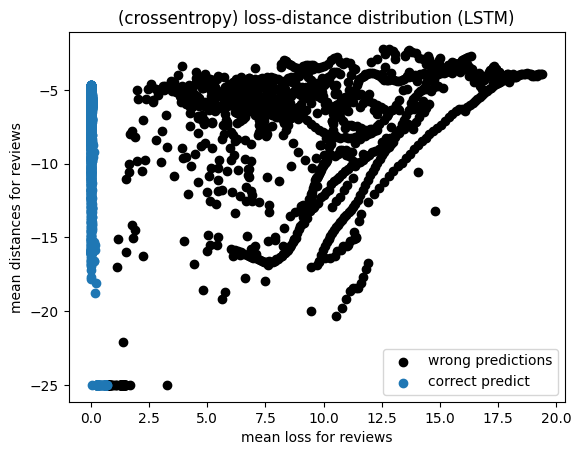

In [716]:
plt.scatter(mean_y,mean,color='black',label='wrong predictions')
plt.scatter(ean_y,ean,label='correct predict')
plt.xlabel('mean loss for reviews')
plt.legend()
plt.ylabel('mean distances for reviews')
plt.title('(crossentropy) loss-distance distribution (LSTM)')

In [152]:
xl=[]
with open('LSTM/vloss.txt') as f:
    for line in f.readlines():
        line=line.strip('\n')
        xl.append(float(line)) 
for i in range(len(xl)-1):
    if xl[i]-xl[i+1]>0.75:
        print(i+1)

16
516
711
831
913
998
1090


In [197]:
with open('lstm2.pkl', 'rb') as f:
        x2=pickle.load(f)
len(x2)

1000

/tmp/ipykernel_4145788/3194056780.py:3: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(-25,0,45)


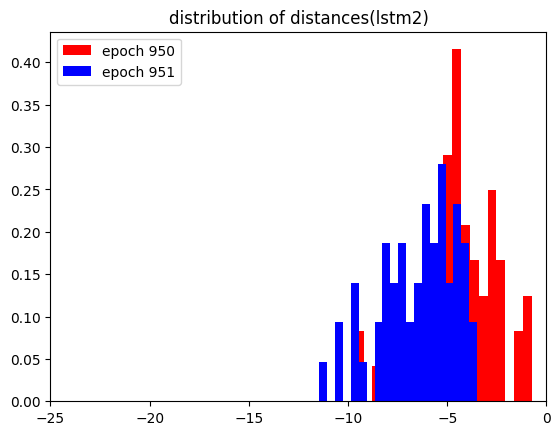

In [205]:
plt.hist(x2[949],color='red',bins=20,density=True,label='epoch 950')
plt.hist(x2[950],color='blue',bins=20,density=True,label='epoch 951')
plt.xlim(-25,0,45)
plt.title('distribution of distances(lstm2)')
plt.legend()